In [1]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, norm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import cgm_interpretability_extension as cie
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['axes.unicode_minus'] = False  # prevents minus sign issues
import matplotlib.gridspec as gridspec
from scipy import stats

In [2]:
df = pd.read_csv('df_metrics_CGM_biochem_demographics.csv')

# Display basic info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

DataFrame shape: (736, 65)
Columns: ['Patient_ID', 'TIR_Q1', 'TIR_Q2', 'TIR_Q3', 'TIR_Q4', 'TBR_Q1', 'TBR_Q2', 'TBR_Q3', 'TBR_Q4', 'CV_Q1', 'CV_Q2', 'CV_Q3', 'CV_Q4', 'slope_TIR_per_day', 'slope_mean_glucose_per_day', 'glucose_p10', 'glucose_p25', 'glucose_p50', 'glucose_p75', 'glucose_p90', 'rolling_mean_std', 'rolling_cv_std', 'MAGE', 'MODD', 'CONGA_4', 'hypo_count', 'hyper_count', 'avg_hypo_duration', 'avg_hyper_duration', 'TIR_day', 'TIR_night', 'TBR_day', 'TBR_night', 'CV_day', 'CV_night', 'rapid_spike_count', 'slope_CV_interaction', 'A1c_mean', 'A1c_SD', 'Sex', 'Number_of_days_with_measures', 'Number_of_measurements', 'Number_of_biochemical_parameters', 'Number_of_diagnostics', 'Age', 'Alanine transaminase (GPT)_mean', 'Albumin (urine)_mean', 'Chlorine_mean', 'Creatinine_mean', 'Creatinine (urine)_mean', 'Gamma-glutamyl Transferase (GGT)_mean', 'Glucose_mean', 'HDL cholesterol_mean', 'Potassium_mean', 'Sodium_mean', 'Thyrotropin (TSH)_mean', 'Total cholesterol_mean', 'Triglycerid

In [3]:
print("Class distribution:")
print(df['Hypothyroidism'].value_counts())
print(df['Hypertension'].value_counts()) 
print(df['Retinopathy'].value_counts())
print(df['Lipid metabolism'].value_counts())
print(df['Airway Disease'].value_counts())
print(df['Nephropathy and/or Neuropathy'].value_counts())

Class distribution:
Hypothyroidism
0    639
1     97
Name: count, dtype: int64
Hypertension
0    667
1     69
Name: count, dtype: int64
Retinopathy
0    640
1     96
Name: count, dtype: int64
Lipid metabolism
0    683
1     53
Name: count, dtype: int64
Airway Disease
0    697
1     39
Name: count, dtype: int64
Nephropathy and/or Neuropathy
0    697
1     39
Name: count, dtype: int64


In [4]:
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head())

Missing values per column:
Chlorine_mean            313
Number_of_diagnostics    225
A1c_SD                    30
Uric acid_mean            28
Albumin (urine)_mean      23
dtype: int64


In [5]:
# Create a new dataframe by dropping the high-missingness columns
df_clean = df.drop(columns=['Chlorine_mean', 'Number_of_diagnostics'])

# Keep only complete cases (rows with no missing values)
df_complete = df_clean.dropna()

print(f"Original dataframe shape: {df.shape}")
print(f"After dropping high-missing columns: {df_clean.shape}")
print(f"After keeping only complete cases: {df_complete.shape}")
print(f"Final patient count: {len(df_complete)}")

# Show missing values in the final dataset to verify
print("\nMissing values in final dataset:")
print(df_complete.isnull().sum().sum())  # Should be 0

Original dataframe shape: (736, 65)
After dropping high-missing columns: (736, 63)
After keeping only complete cases: (689, 63)
Final patient count: 689

Missing values in final dataset:
0


In [6]:
patients_with_lipid_issue = df_complete[df_complete['Lipid metabolism'] == 1]['Patient_ID']

patients_list = patients_with_lipid_issue.tolist()

print(patients_list)

['LIB193276', 'LIB193278', 'LIB193302', 'LIB193346', 'LIB193351', 'LIB193352', 'LIB193366', 'LIB193367', 'LIB193372', 'LIB193375', 'LIB193381', 'LIB193395', 'LIB193416', 'LIB193425', 'LIB193426', 'LIB193434', 'LIB193438', 'LIB193441', 'LIB193449', 'LIB193472', 'LIB193476', 'LIB193482', 'LIB193503', 'LIB193535', 'LIB193540', 'LIB193542', 'LIB193553', 'LIB193554', 'LIB193556', 'LIB193557', 'LIB193558', 'LIB193573', 'LIB193580', 'LIB193599', 'LIB193603', 'LIB193610', 'LIB193645', 'LIB193761', 'LIB193776', 'LIB193780', 'LIB193790', 'LIB193794', 'LIB193795', 'LIB193820', 'LIB193824', 'LIB193837', 'LIB193902', 'LIB193980', 'LIB194015', 'LIB194019', 'LIB194062', 'LIB194161']


In [7]:
tune_conditions = ['Retinopathy', 'Airway Disease', 'Nephropathy and/or Neuropathy']

# Combine patients from these conditions
df_tune = pd.concat([df_complete[df_complete[cond]==1] for cond in tune_conditions], axis=0)
df_tune = df_tune.drop_duplicates(subset='Patient_ID')  # avoid duplicates if patient has multiple conditions

if 'Sex' in df_tune.columns:
    df_tune = pd.get_dummies(df_tune, columns=['Sex'], drop_first=True)

target_col = 'Hypertension'  # placeholder for tuning
condition_cols = ['Hypothyroidism','Hypertension','Retinopathy','Lipid metabolism',
                  'Airway Disease','Nephropathy and/or Neuropathy']
cols_to_remove = ['Patient_ID'] + [c for c in condition_cols if c != target_col]

# CGM metrics
cgm_metrics = [
    "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4","TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
    "CV_Q1","CV_Q2","CV_Q3","CV_Q4","slope_TIR_per_day","slope_mean_glucose_per_day",
    "glucose_p10","glucose_p25","glucose_p50","glucose_p75","glucose_p90",
    "rolling_mean_std","rolling_cv_std","MAGE","MODD","CONGA_4","hypo_count",
    "hyper_count","avg_hypo_duration","avg_hyper_duration","TIR_day","TIR_night",
    "TBR_day","TBR_night","CV_day","CV_night","rapid_spike_count","slope_CV_interaction"
]

X = df_tune.drop(columns=cols_to_remove + [target_col], errors='ignore')
y = df_tune[target_col]

cat_cols = X.select_dtypes(include=['object','category']).columns
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_res, y_res)

print("Best hyperparameters:", grid.best_params_)

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [7]:
def run_cross_validation_xgboost(df, target_col, cgm_subset=None, n_splits=10, random_state=42):
    sex_encoded = False
    if 'Sex' in df.columns:
        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        sex_encoded = True
        sex_column_name = 'Sex_M' if 'Sex_M' in df.columns else next((col for col in df.columns if 'sex' in col.lower()), None)

    cgm_metrics = [
        "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4","TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
        "CV_Q1","CV_Q2","CV_Q3","CV_Q4","slope_TIR_per_day","slope_mean_glucose_per_day",
        "glucose_p10","glucose_p25","glucose_p50","glucose_p75","glucose_p90",
        "rolling_mean_std","rolling_cv_std","MAGE","MODD","CONGA_4","hypo_count",
        "hyper_count","avg_hypo_duration","avg_hyper_duration","TIR_day","TIR_night",
        "TBR_day","TBR_night","CV_day","CV_night","rapid_spike_count","slope_CV_interaction"
    ]

    condition_cols = [
        'Hypothyroidism', 'Hypertension', 'Retinopathy',
        'Lipid metabolism', 'Airway Disease', 'Nephropathy and/or Neuropathy'
    ]
    cols_to_remove = ['Patient_ID'] + [c for c in condition_cols if c != target_col]

    all_features = df.drop(columns=cols_to_remove + [target_col], errors='ignore').columns.tolist()
    
    non_cgm_features = [col for col in all_features if col not in cgm_metrics]
    
    X_base = df[non_cgm_features].copy()
    
    if cgm_subset is None:
        X_all = df[all_features].copy()
        X_only_cgm = df[cgm_metrics].copy()
    else:
        X_all = df[non_cgm_features + cgm_subset].copy()
        X_only_cgm = df[cgm_subset].copy()
    
    X_no_cgm = X_base.copy()
    
    y = df[target_col]

    all_feature_names = X_all.columns.tolist()
    no_cgm_feature_names = X_no_cgm.columns.tolist()
    only_cgm_feature_names = X_only_cgm.columns.tolist()
    
    scalers = {
        'with_cgm': [],
        'without_cgm': [],
    }

    results = {
        'with_cgm': {'fold_seed_data': [], 'models': [], 'X_test_scaled': [], 'X_test_raw': []},
        'without_cgm': {'fold_seed_data': [], 'models': [], 'X_test_scaled': [], 'X_test_raw': []},
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y), 1):
        X_train_all, X_test_all = X_all.iloc[train_idx], X_all.iloc[test_idx]
        X_train_no_cgm, X_test_no_cgm = X_no_cgm.iloc[train_idx], X_no_cgm.iloc[test_idx]
        X_train_only, X_test_only = X_only_cgm.iloc[train_idx], X_only_cgm.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler_all = StandardScaler().fit(X_train_all)
        scaler_no_cgm = StandardScaler().fit(X_train_no_cgm)
        scaler_only = StandardScaler().fit(X_train_only)
        
        scalers['with_cgm'].append(scaler_all)
        scalers['without_cgm'].append(scaler_no_cgm)

        X_train_all_scaled = scaler_all.transform(X_train_all)
        X_test_all_scaled = scaler_all.transform(X_test_all)
        X_train_no_cgm_scaled = scaler_no_cgm.transform(X_train_no_cgm)
        X_test_no_cgm_scaled = scaler_no_cgm.transform(X_test_no_cgm)
        X_train_only_scaled = scaler_only.transform(X_train_only)
        X_test_only_scaled = scaler_only.transform(X_test_only)

        results['with_cgm']['X_test_raw'].append(X_test_all)
        results['without_cgm']['X_test_raw'].append(X_test_no_cgm)

        smote = SMOTE(random_state=random_state + fold)
        X_train_all_smote, y_train_all_smote = smote.fit_resample(X_train_all_scaled, y_train)
        X_train_no_cgm_smote, y_train_no_cgm_smote = smote.fit_resample(X_train_no_cgm_scaled, y_train)
        X_train_only_smote, y_train_only_smote = smote.fit_resample(X_train_only_scaled, y_train)

        model_params = {
            'n_estimators': 500,
            'max_depth': 2,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'eval_metric': 'logloss',
            'use_label_encoder': False,
            'random_state': random_state
        }

        models = {
            'with_cgm': xgb.XGBClassifier(**model_params).fit(X_train_all_smote, y_train_all_smote),
            'without_cgm': xgb.XGBClassifier(**model_params).fit(X_train_no_cgm_smote, y_train_no_cgm_smote),
        }

        test_data = {
            'with_cgm': X_test_all_scaled,
            'without_cgm': X_test_no_cgm_scaled,
        }
        
        for key in ['with_cgm', 'without_cgm']:
            y_pred = models[key].predict_proba(test_data[key])[:,1]
            
            results[key]['models'].append(models[key])
            results[key]['X_test_scaled'].append(test_data[key])
            
            fold_data = {
                'fold': fold,
                'seed': random_state,
                'y_true': y_test.values,
                'y_pred': y_pred,
                'roc_auc': roc_auc_score(y_test, y_pred)
            }
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            fold_data['pr_auc'] = auc(recall, precision)
            
            results[key]['fold_seed_data'].append(fold_data)
        
        with_auc = results['with_cgm']['fold_seed_data'][-1]['roc_auc']
        without_auc = results['without_cgm']['fold_seed_data'][-1]['roc_auc']
        print(f"Fold {fold:2d}: With={with_auc:.3f}, Without={without_auc:.3f}, ")

    results['scalers'] = scalers
    results['feature_names'] = {
        'with_cgm': all_feature_names,
        'without_cgm': no_cgm_feature_names,
    }
    
    return results, all_feature_names, no_cgm_feature_names, only_cgm_feature_names

In [8]:
seeds = [42, 123, 99, 45, 48]

In [9]:
conditions = [
    'Hypothyroidism',
    'Hypertension',
    'Retinopathy',
    'Lipid metabolism',
    'Airway Disease',
    'Nephropathy and/or Neuropathy'
]
all_results = {}
for condition in conditions:
    all_results[condition] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_complete,
                target_col=condition,
                n_splits=10,
                random_state=seed
            )
            
            all_results[condition][seed] = results
            
            with_cgm_aucs = [d['roc_auc'] for d in results['with_cgm']['fold_seed_data']]
            without_cgm_aucs = [d['roc_auc'] for d in results['without_cgm']['fold_seed_data']]
            
            print(f"{condition} | Seed {seed} - Cross-validation complete")
            print(f"  ROC-AUC With CGM: {np.mean(with_cgm_aucs):.3f} ± {np.std(with_cgm_aucs):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(without_cgm_aucs):.3f} ± {np.std(without_cgm_aucs):.3f}")
            print(f"  Features: With CGM = {len(features_with)}, Without CGM = {len(features_without)}\n")
            
        except Exception as e:
            print(f"Error processing {condition} with seed {seed}: {e}")
            continue

Fold  1: With=0.752, Without=0.757, 
Fold  2: With=0.630, Without=0.626, 
Fold  3: With=0.556, Without=0.589, 
Fold  4: With=0.809, Without=0.837, 
Fold  5: With=0.789, Without=0.756, 
Fold  6: With=0.752, Without=0.646, 
Fold  7: With=0.509, Without=0.600, 
Fold  8: With=0.711, Without=0.696, 
Fold  9: With=0.629, Without=0.654, 
Fold 10: With=0.793, Without=0.750, 
Hypothyroidism | Seed 42 - Cross-validation complete
  ROC-AUC With CGM: 0.693 ± 0.100
  ROC-AUC Without CGM: 0.691 ± 0.077
  Features: With CGM = 56, Without CGM = 20

Fold  1: With=0.754, Without=0.843, 
Fold  2: With=0.661, Without=0.689, 
Fold  3: With=0.693, Without=0.633, 
Fold  4: With=0.828, Without=0.819, 
Fold  5: With=0.622, Without=0.719, 
Fold  6: With=0.722, Without=0.626, 
Fold  7: With=0.574, Without=0.572, 
Fold  8: With=0.635, Without=0.556, 
Fold  9: With=0.651, Without=0.653, 
Fold 10: With=0.680, Without=0.725, 
Hypothyroidism | Seed 123 - Cross-validation complete
  ROC-AUC With CGM: 0.682 ± 0.069
  R

In [11]:
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + norm.logsf(z, loc=0, scale=1) / np.log(10)

def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

def delong_roc_test_pvalue(ground_truth, predictions_one, predictions_two):
    log10_pvalue = delong_roc_test(ground_truth, predictions_one, predictions_two)
    return 10 ** log10_pvalue[0][0]

models = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical-and-Demographic',
    'with_cgm': 'Combined'
}
alpha = 0.05

table_data = []
for condition in conditions:
    seeds_results = all_results[condition]
    
    all_fold_vals_biochem = []
    all_fold_vals_cgm = []
    y_true_all_folds = []
    y_pred_biochem_all_folds = []
    y_pred_cgm_all_folds = []
    
    for seed, seed_res in seeds_results.items():
        for fold_data in seed_res['without_cgm']['fold_seed_data']:
            all_fold_vals_biochem.append(fold_data['roc_auc'])
            y_true_all_folds.append(fold_data['y_true'])
            y_pred_biochem_all_folds.append(fold_data['y_pred'])
        
        for fold_data in seed_res['with_cgm']['fold_seed_data']:
            all_fold_vals_cgm.append(fold_data['roc_auc'])
            y_pred_cgm_all_folds.append(fold_data['y_pred'])
    
    y_true_concat = np.concatenate(y_true_all_folds)
    y_pred_biochem_concat = np.concatenate(y_pred_biochem_all_folds)
    y_pred_cgm_concat = np.concatenate(y_pred_cgm_all_folds)
    
    mean_biochem = np.mean(all_fold_vals_biochem)
    std_biochem = np.std(all_fold_vals_biochem, ddof=1)
    mean_cgm = np.mean(all_fold_vals_cgm)
    std_cgm = np.std(all_fold_vals_cgm, ddof=1)
    
    p_value = delong_roc_test_pvalue(y_true_concat, y_pred_cgm_concat, y_pred_biochem_concat)
    
    signif = '*' if p_value < alpha else ''
    
    row = {
        'Comorbidity': condition,
        model_labels['without_cgm']: f"{mean_biochem:.3f} ± {std_biochem:.3f}",
        model_labels['with_cgm']: f"{mean_cgm:.3f} ± {std_cgm:.3f}",
        'p-value': f"{p_value:.4f}",
        'Significance': signif,
        'n_folds': len(all_fold_vals_biochem)
    }
    
    table_data.append(row)

df_summary = pd.DataFrame(table_data).set_index('Comorbidity')

print(f"\n=== ROC-AUC SUMMARY WITH DELONG TEST (2-SIDED) ===")
print(f"Note: DeLong test performed on concatenated predictions from all folds")
display(df_summary.drop(columns=['n_folds']))


=== ROC-AUC SUMMARY WITH DELONG TEST (2-SIDED) ===
Note: DeLong test performed on concatenated predictions from all folds


Biochemical-and-Demographic       Combined  \
Comorbidity                                                                
Hypothyroidism                              0.697 ± 0.078  0.690 ± 0.082   
Hypertension                                0.748 ± 0.092  0.770 ± 0.088   
Retinopathy                                 0.683 ± 0.072  0.684 ± 0.079   
Lipid metabolism                            0.738 ± 0.105  0.721 ± 0.107   
Airway Disease                              0.544 ± 0.131  0.534 ± 0.148   
Nephropathy and/or Neuropathy               0.849 ± 0.109  0.814 ± 0.119   

                              p-value Significance  
Comorbidity                                         
Hypothyroidism                 0.5013               
Hypertension                   0.0191            *  
Retinopathy                    0.8295               
Lipid metabolism               0.0947               
Airway Disease                 0.7429               
Nephropathy and/or Neuropathy  0.0002            *

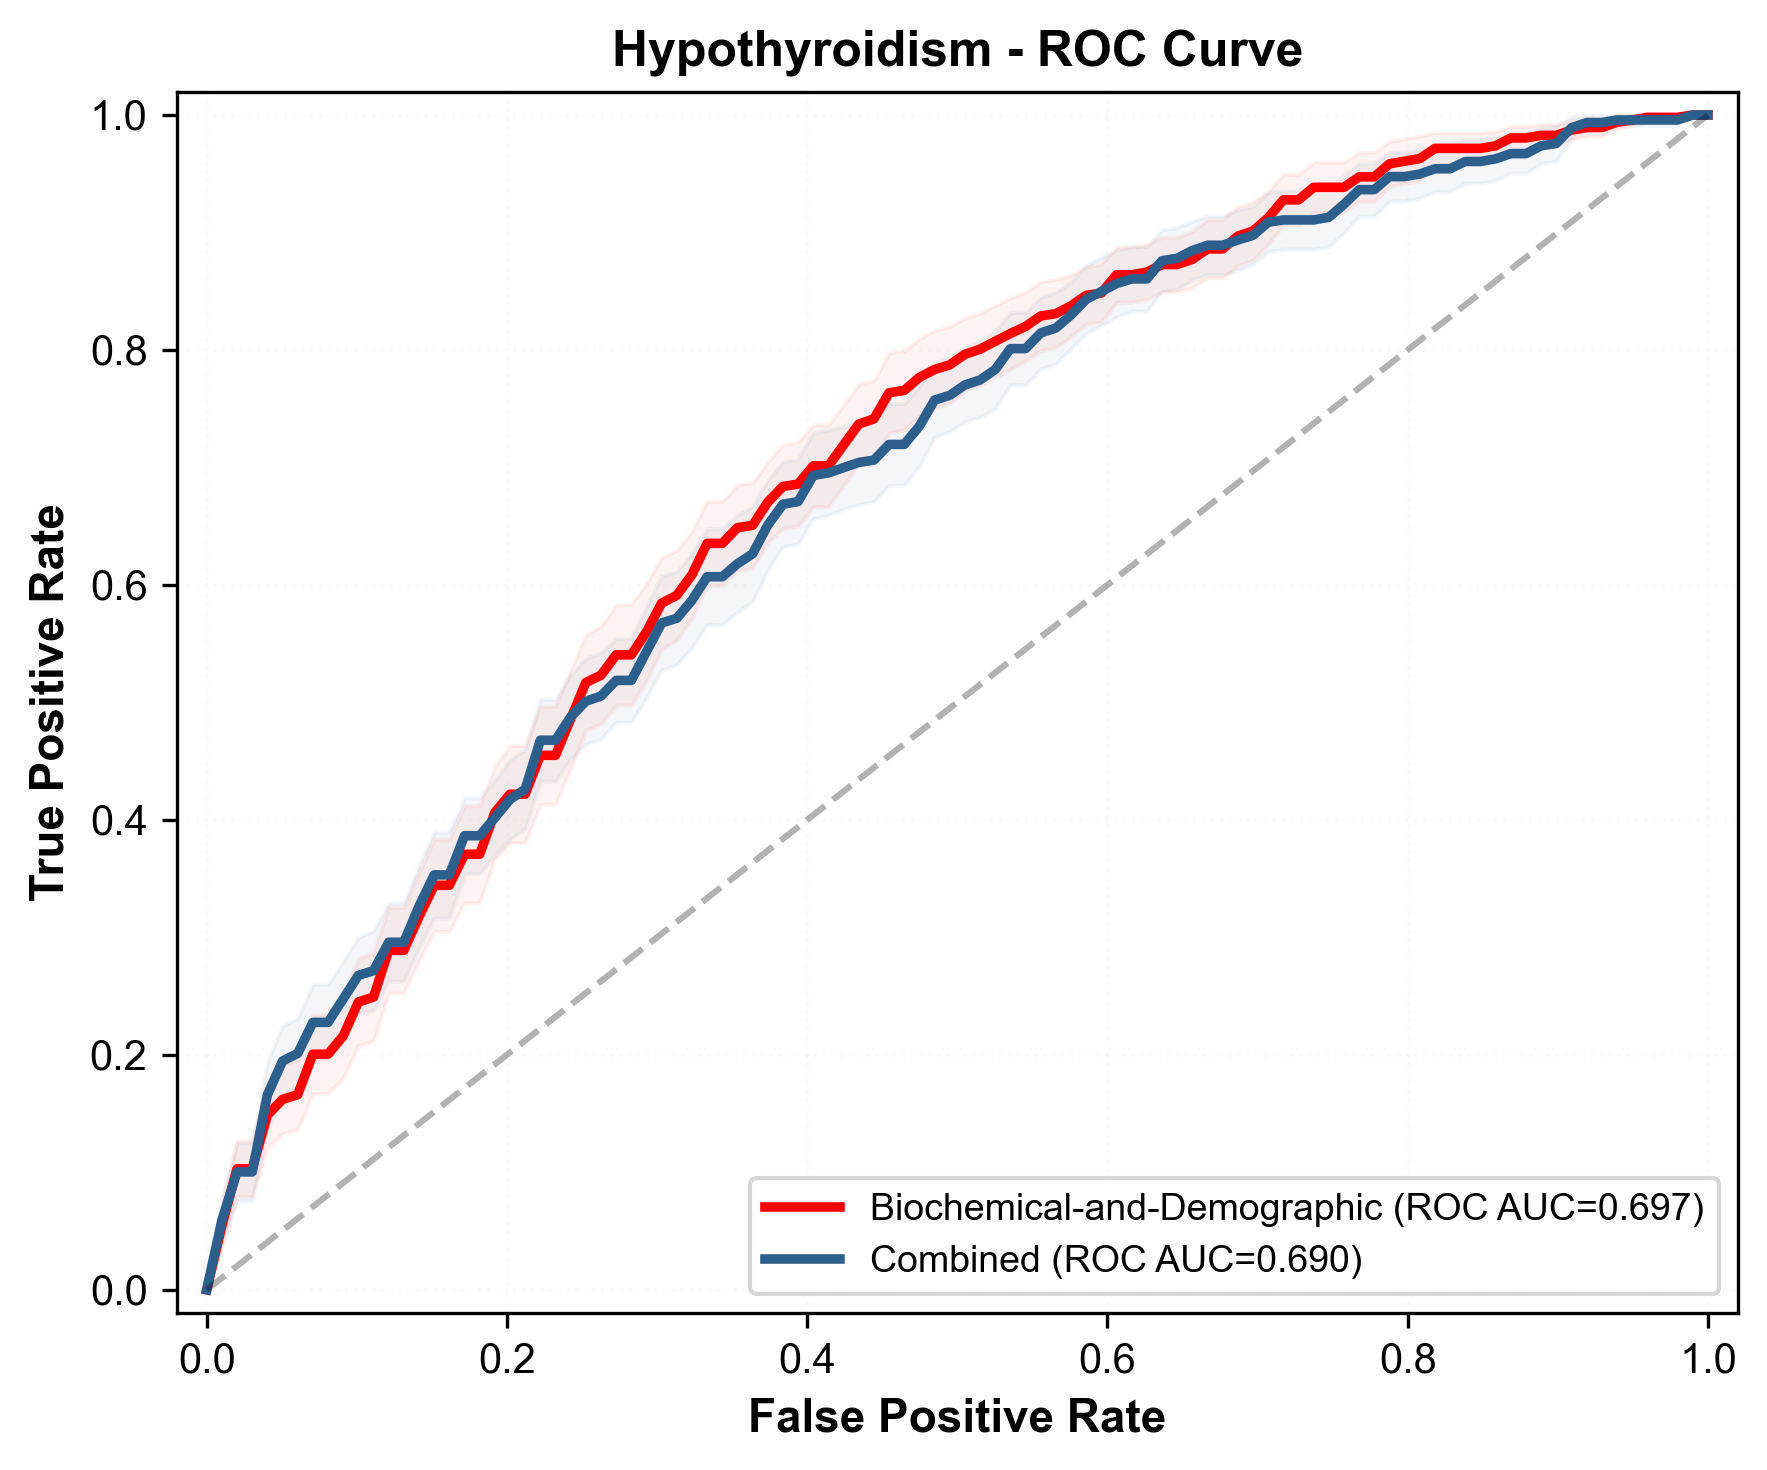

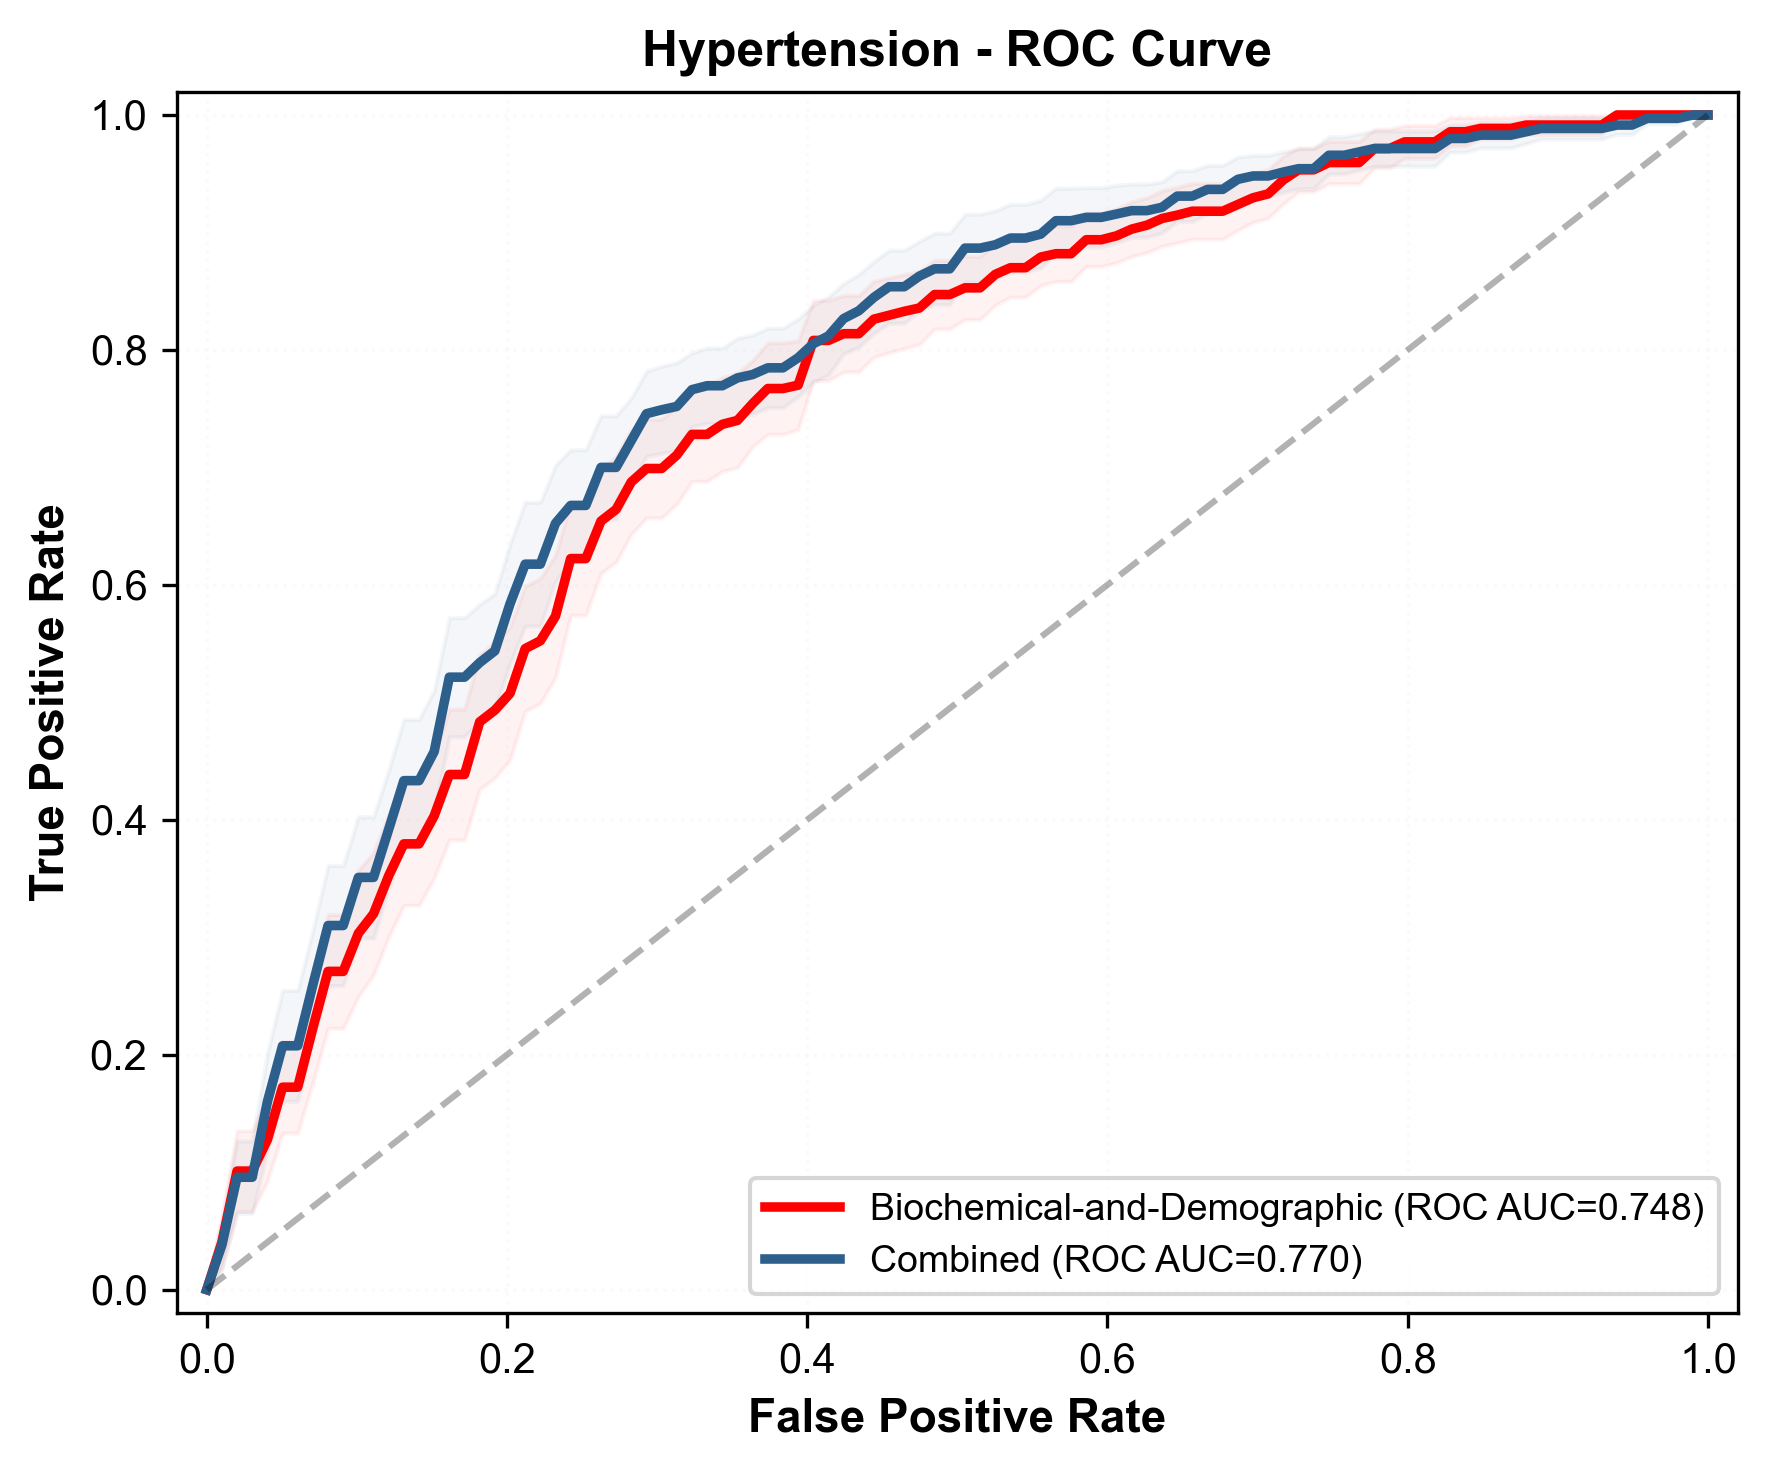

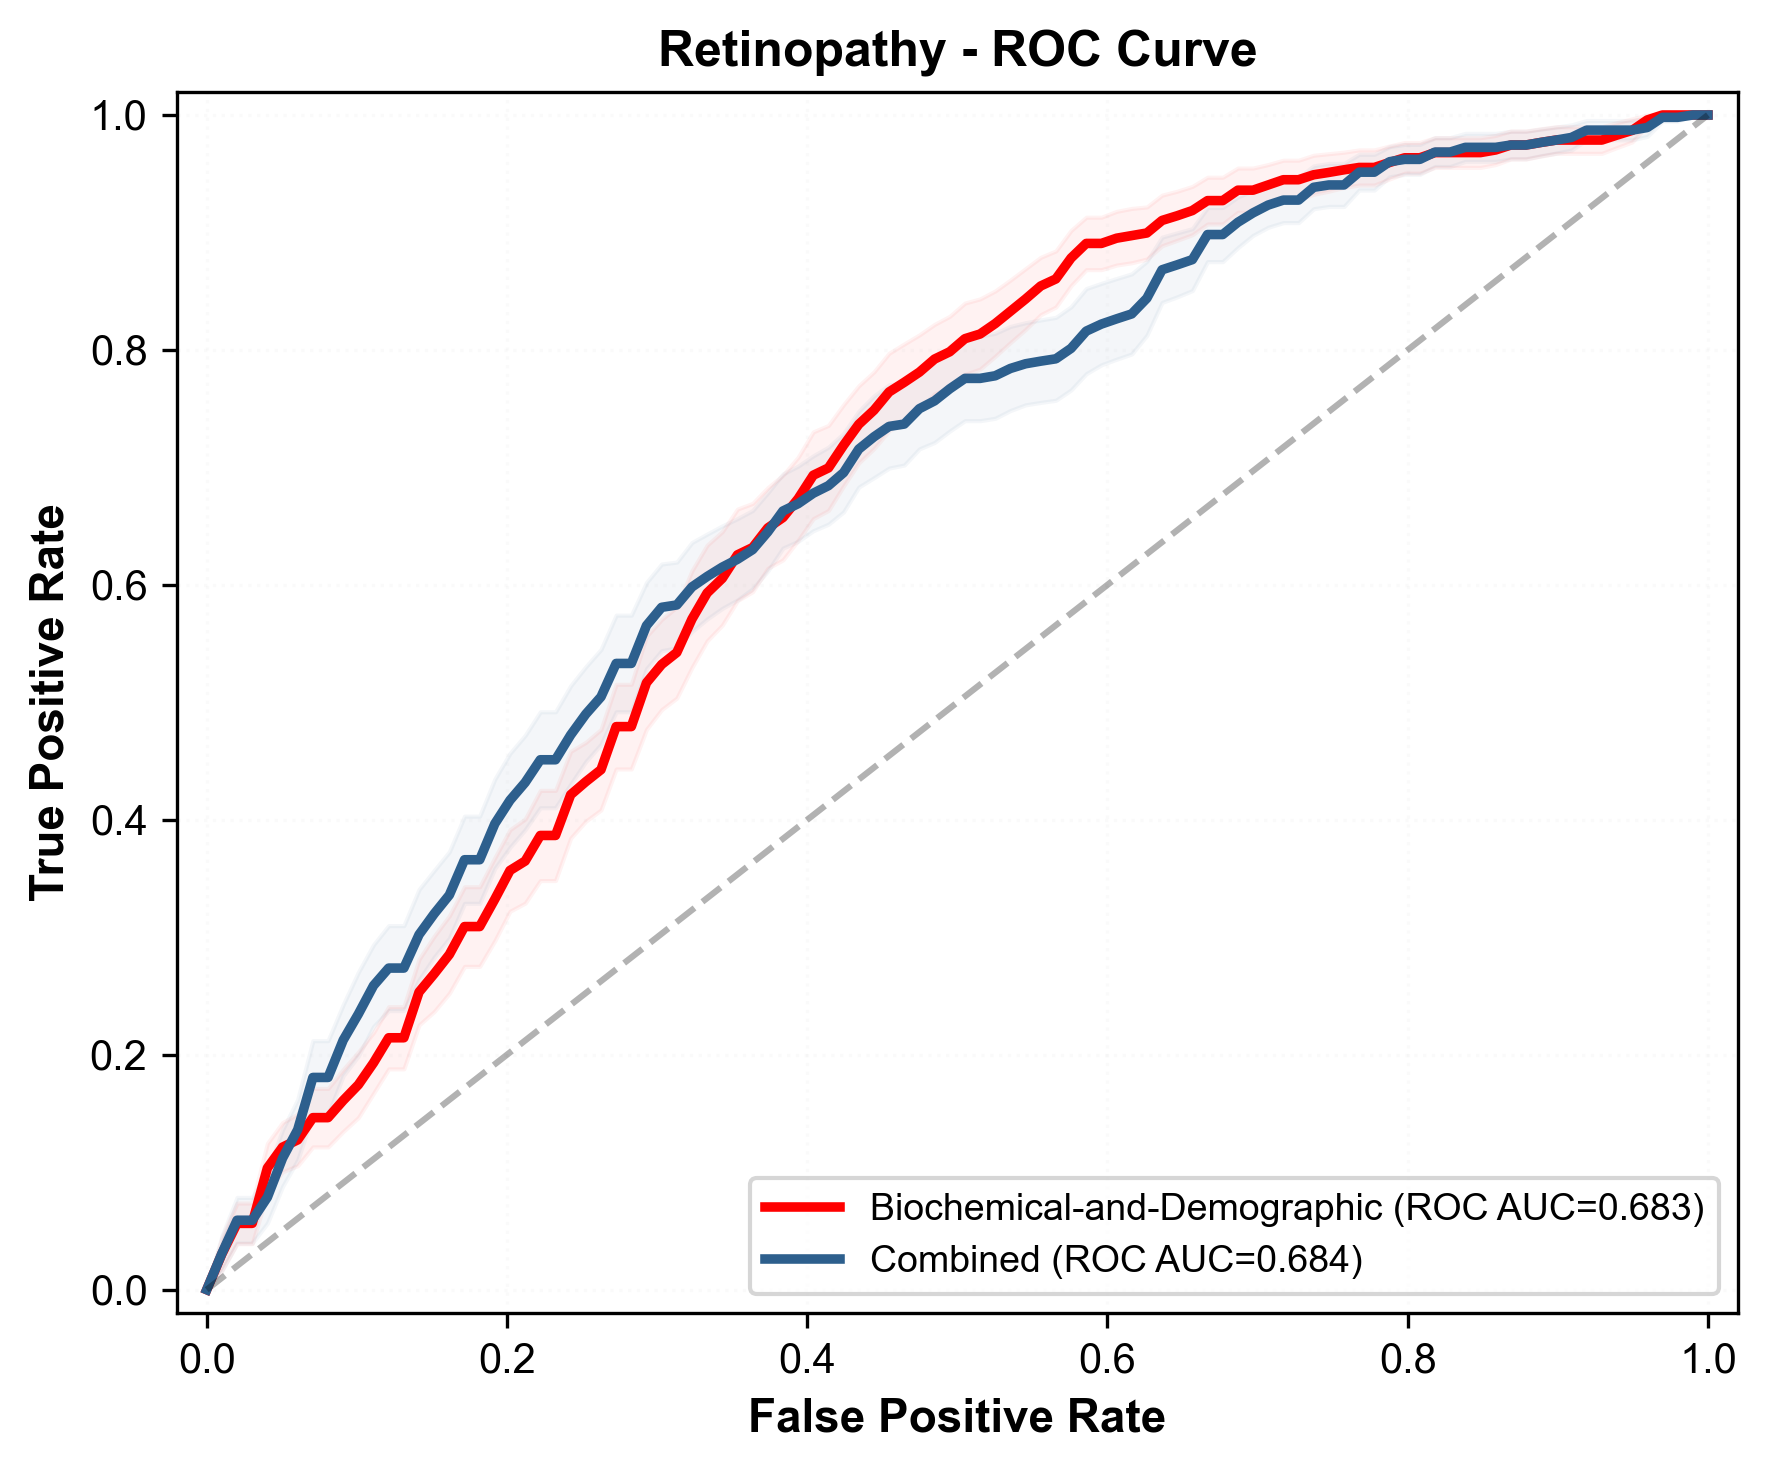

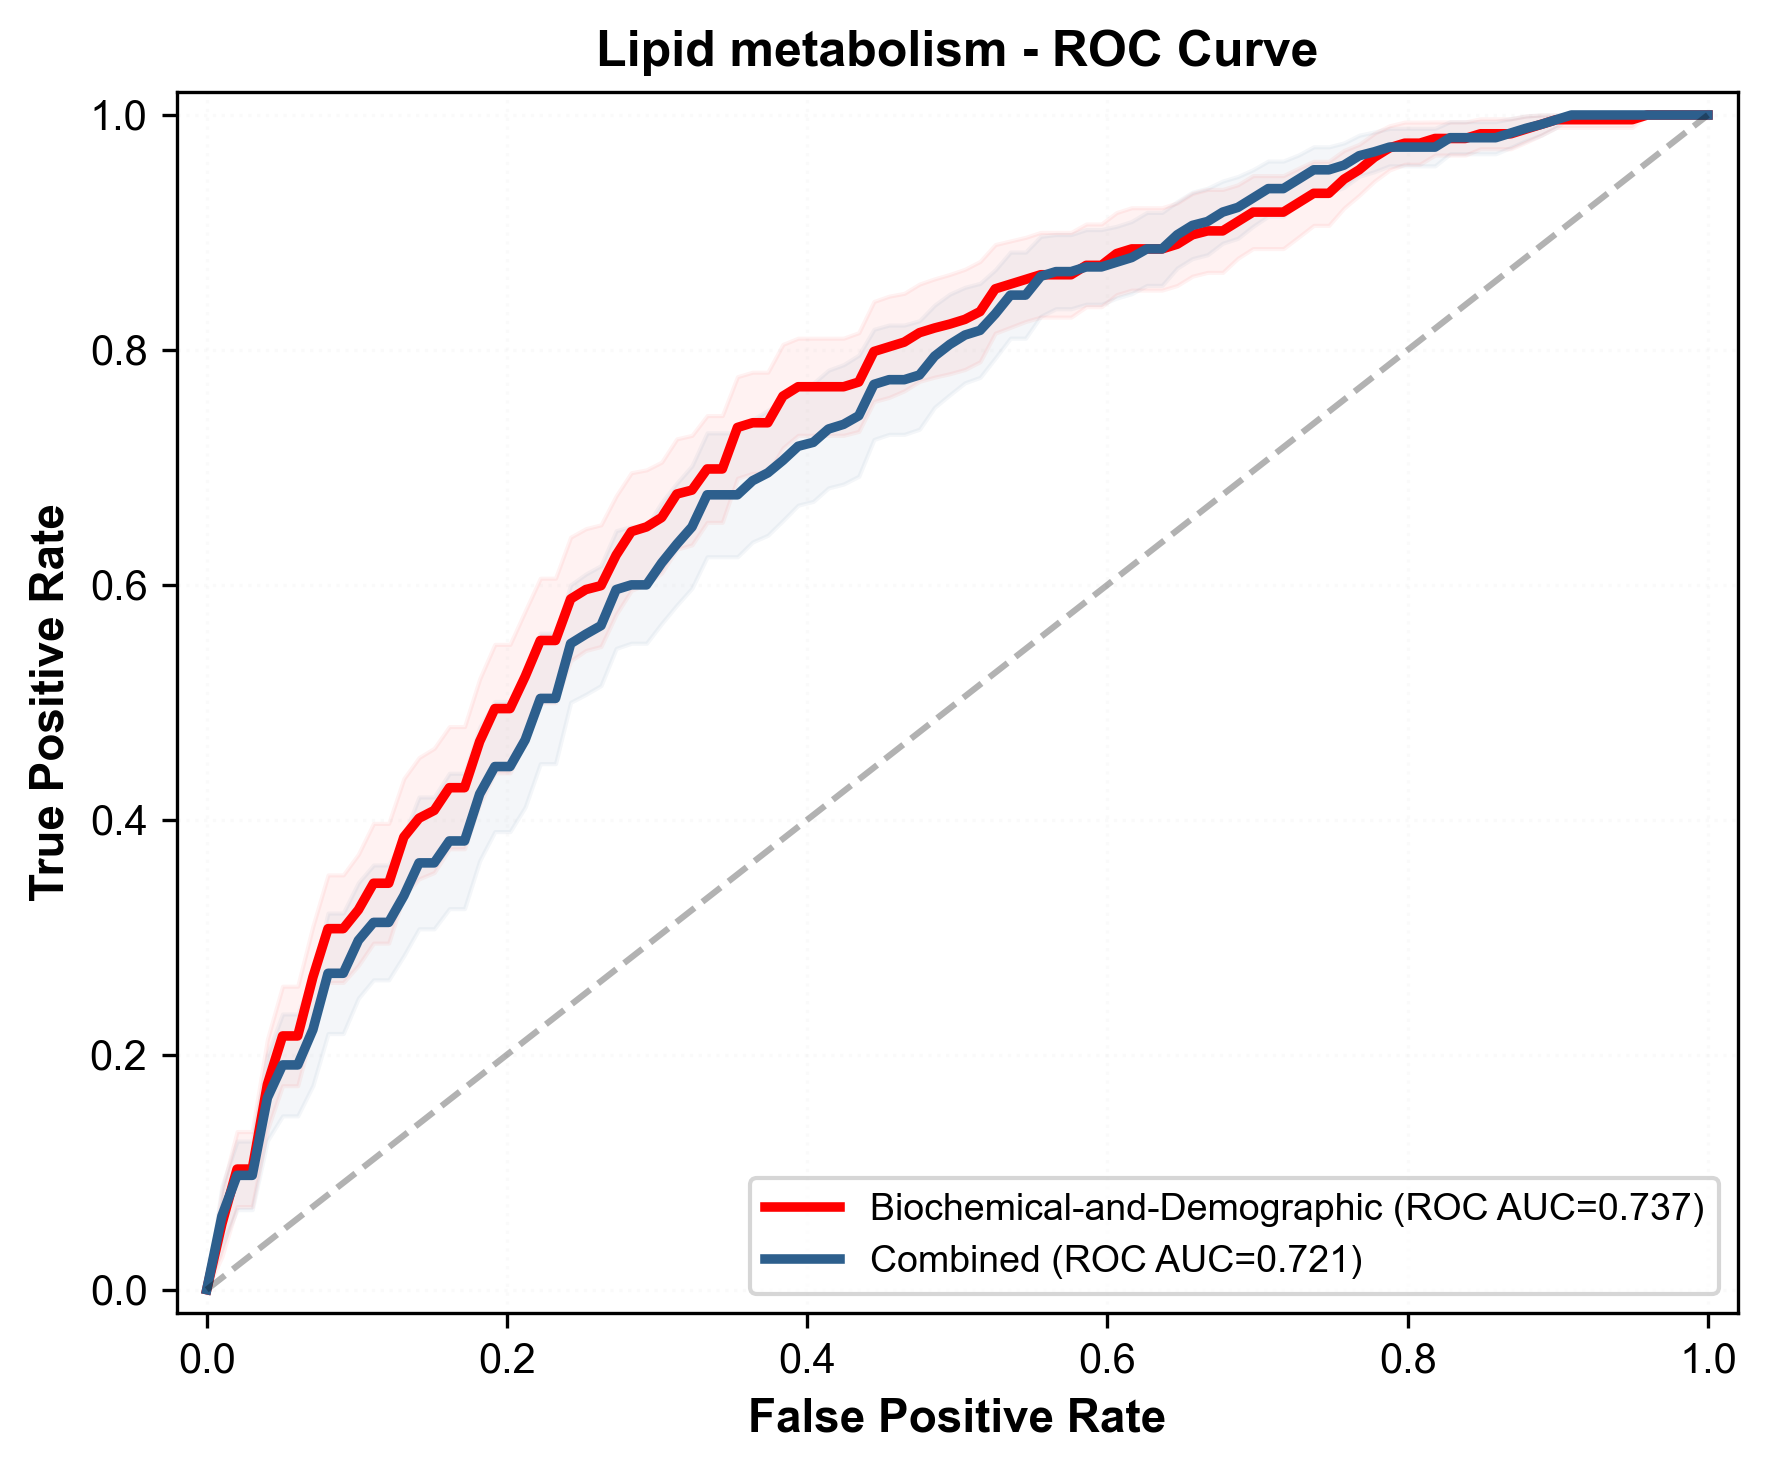

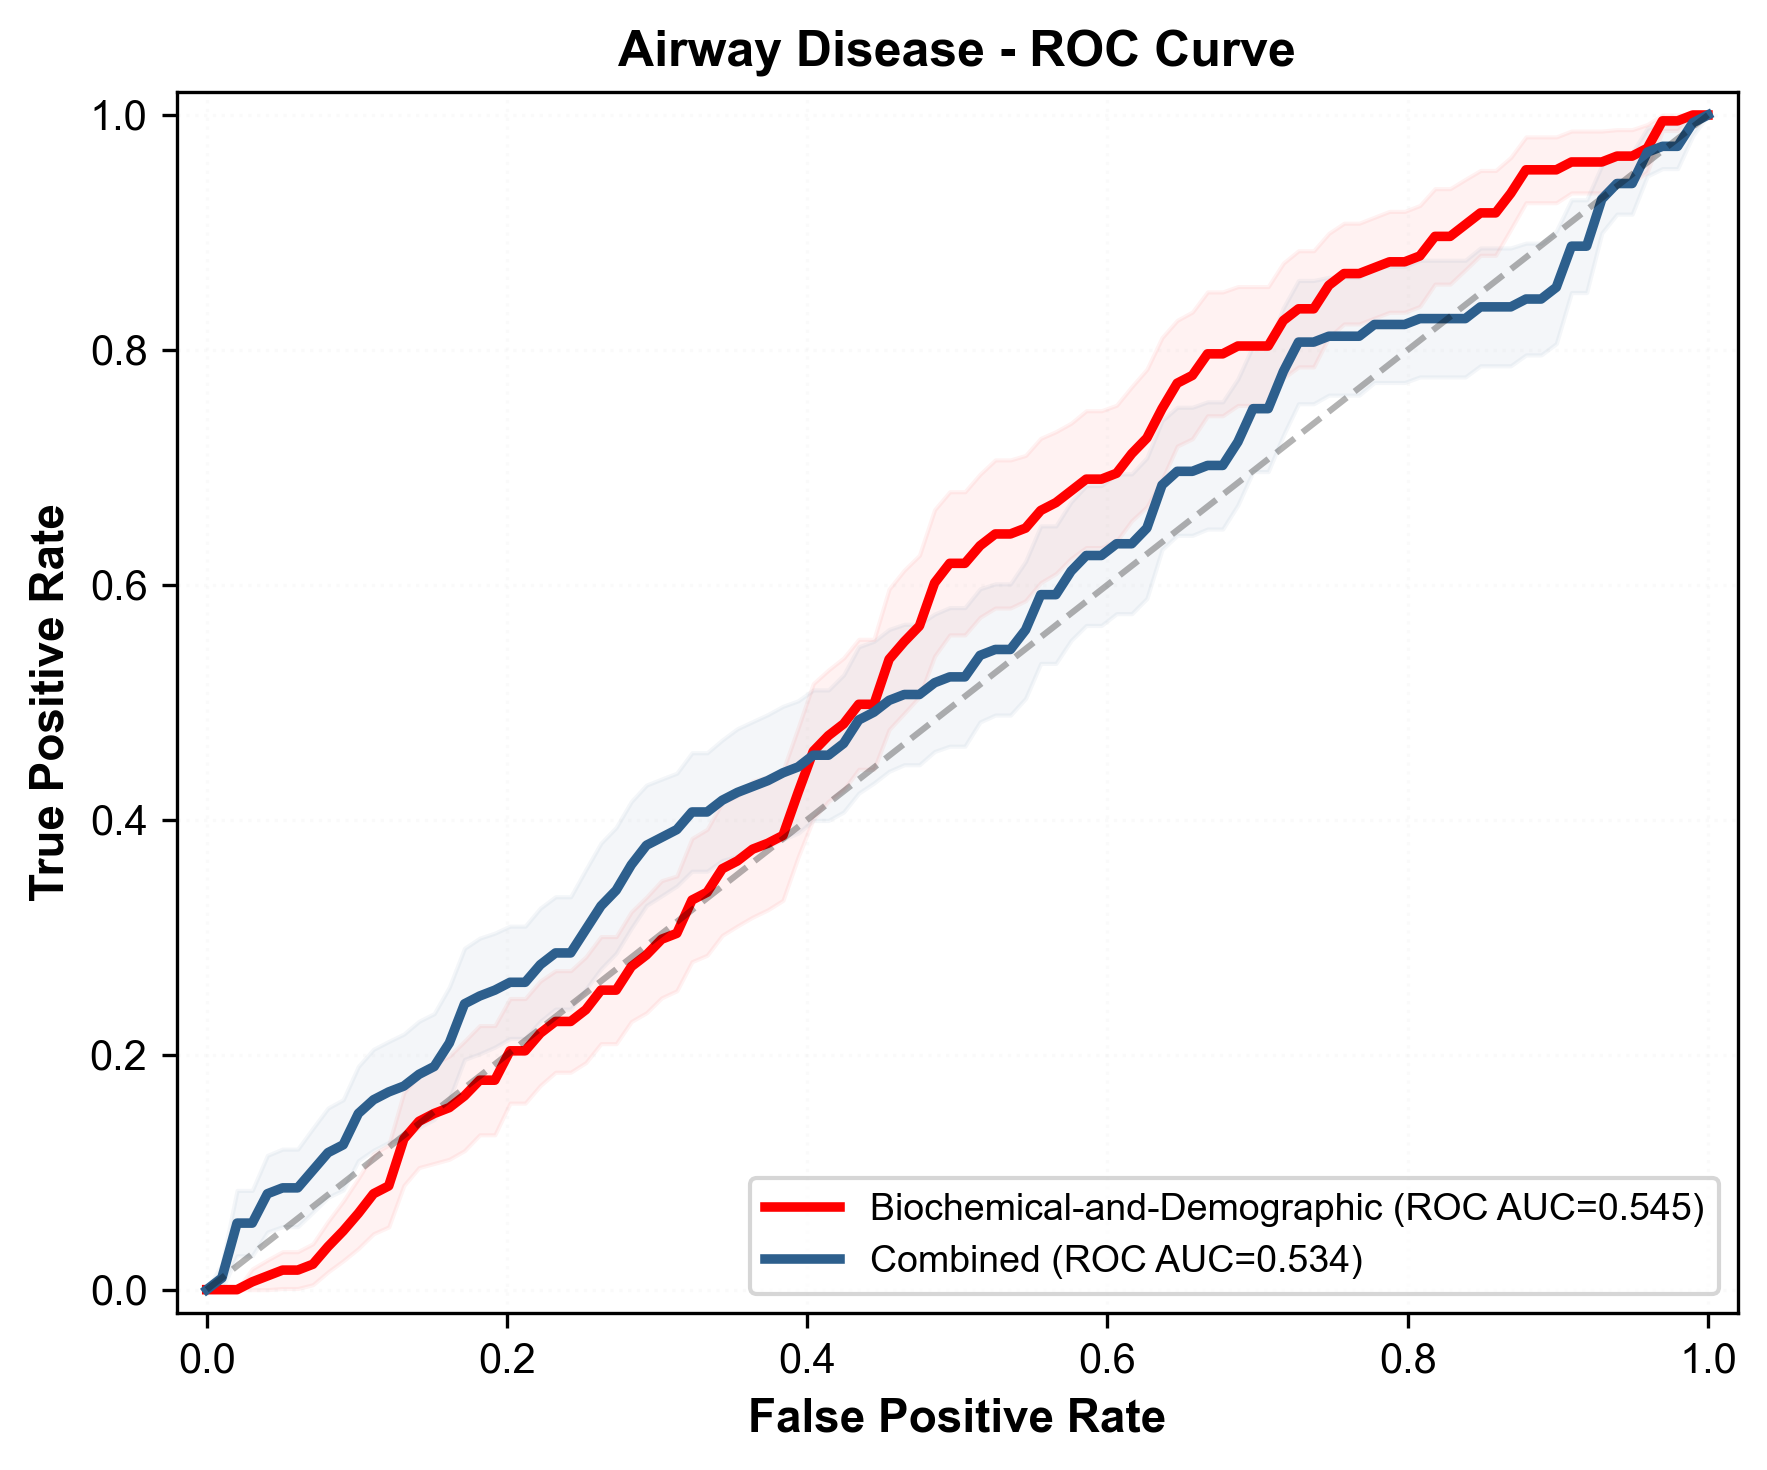

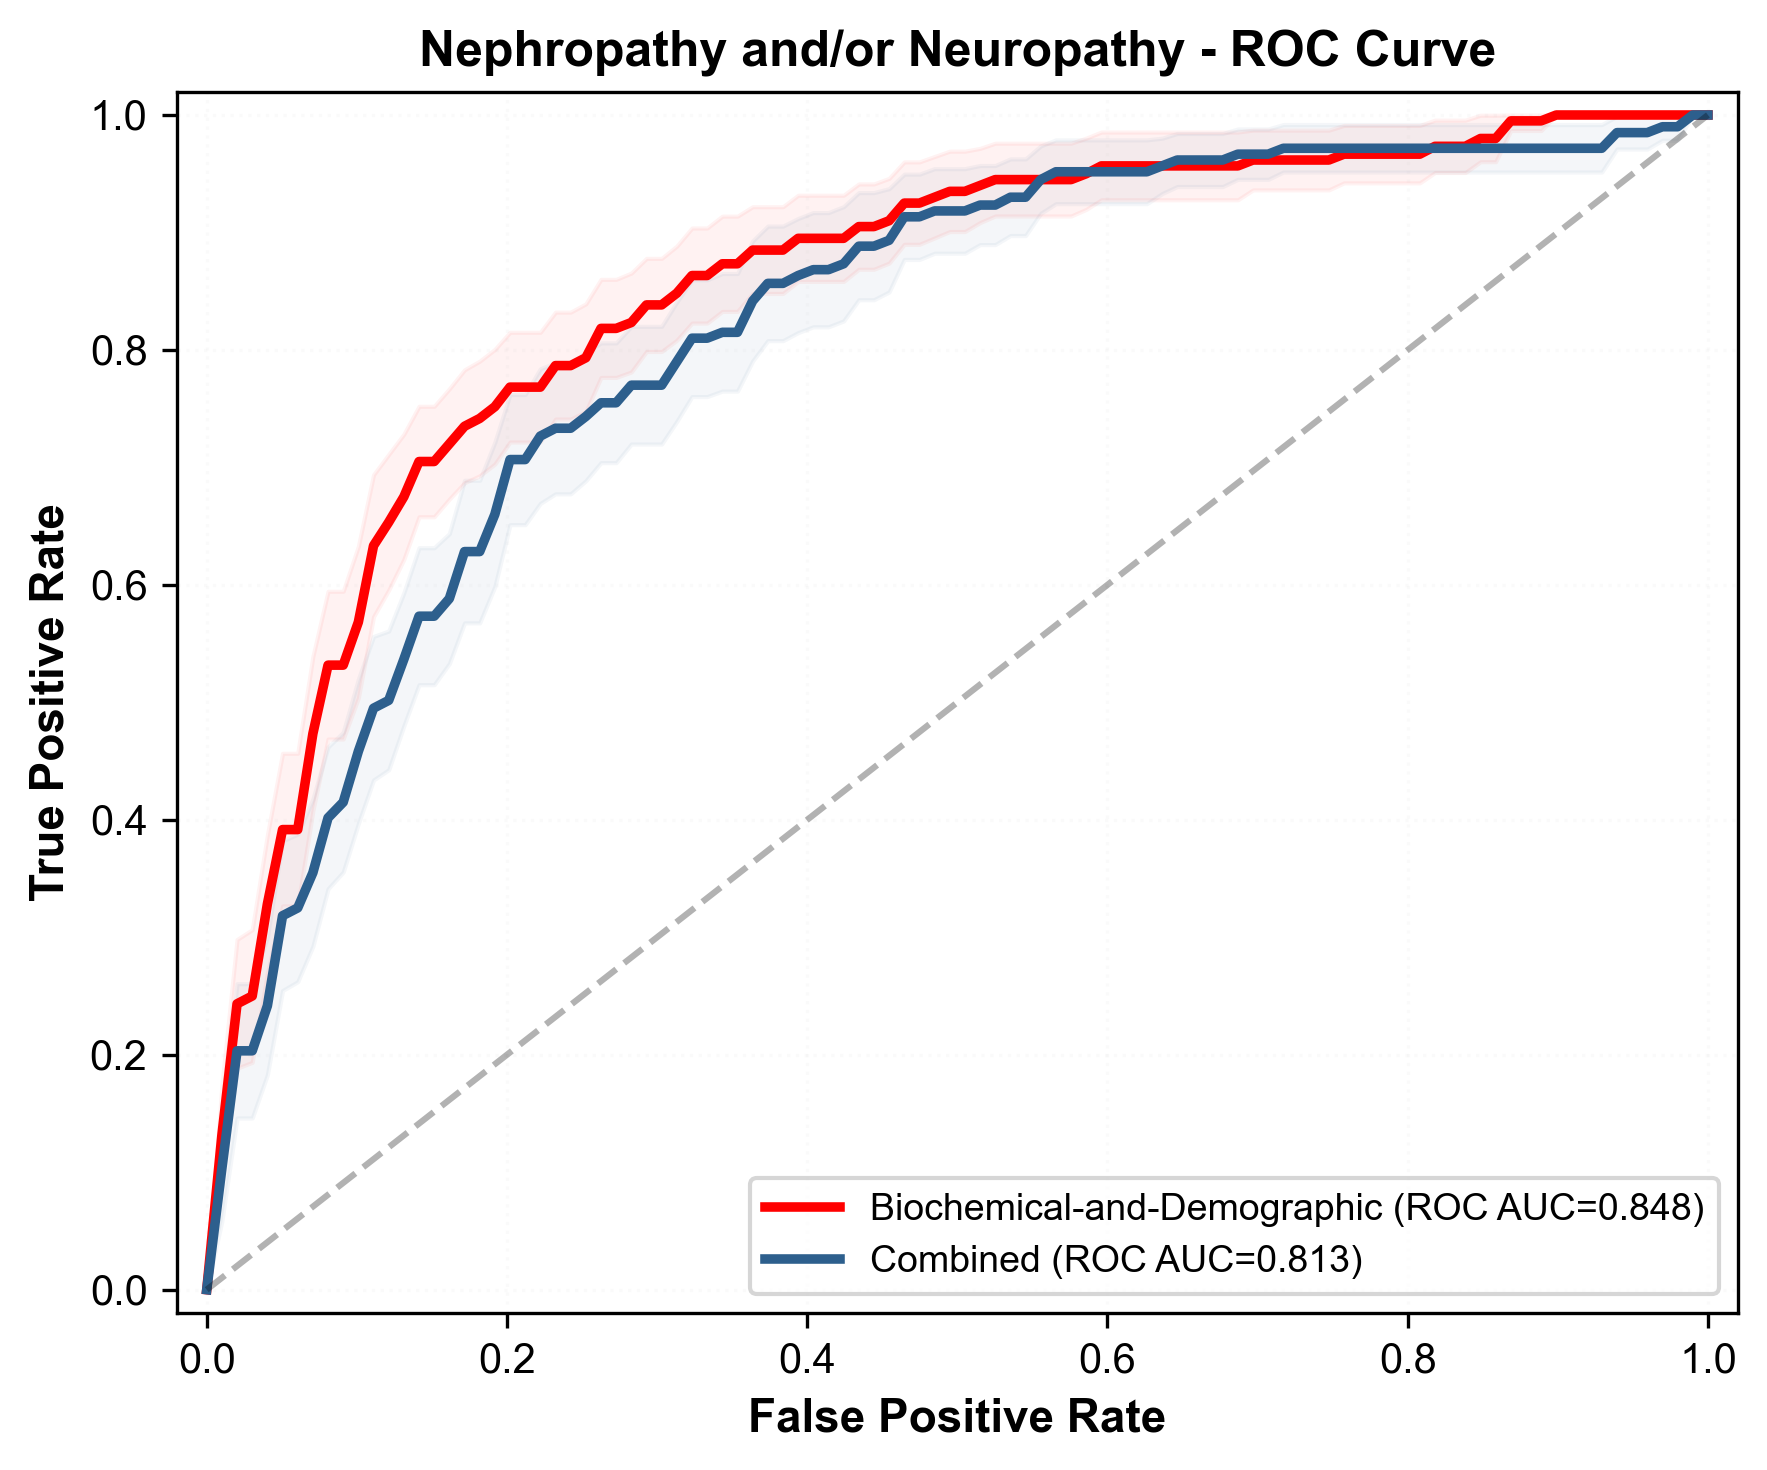

In [12]:
def mean_roc_curve_with_ci(y_trues_list, y_preds_list, n_points=100):
    tprs = []
    mean_fpr = np.linspace(0, 1, n_points)

    for y_true, y_pred in zip(y_trues_list, y_preds_list):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    tprs = np.asarray(tprs)

    mean_tpr = tprs.mean(axis=0)
    mean_tpr[-1] = 1.0

    se = tprs.std(axis=0, ddof=1) / np.sqrt(tprs.shape[0])

    lower = mean_tpr - 1.645 * se
    upper = mean_tpr + 1.645 * se

    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)

    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, lower, upper, mean_auc

model_types = ['without_cgm', 'with_cgm']
model_labels = {
    'without_cgm': 'Biochemical-and-Demographic',
    'with_cgm': 'Combined'
}
colors = {
    'without_cgm': 'red',
    'with_cgm': '#2d5f8d'
}

for condition in conditions:
    results = all_results[condition]

    y_trues_all = {m: [] for m in model_types}
    y_preds_all = {m: [] for m in model_types}

    for seed in results:
        for m in model_types:
            for fold_data in results[seed][m]['fold_seed_data']:
                y_trues_all[m].append(fold_data['y_true'])
                y_preds_all[m].append(fold_data['y_pred'])

    plt.figure(figsize=(6, 5))

    for m in model_types:
        fpr, mean_tpr, lo, hi, mean_auc = mean_roc_curve_with_ci(
            y_trues_all[m],
            y_preds_all[m]
        )

        plt.plot(
            fpr,
            mean_tpr,
            color=colors[m],
            linewidth=2.3,
            label=f"{model_labels[m]} (ROC AUC={mean_auc:.3f})"
        )
        plt.fill_between(
            fpr,
            lo,
            hi,
            color=colors[m],
            alpha=0.05
        )

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    plt.title(f'{condition} - ROC Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(alpha=0.05, linestyle=':')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.tight_layout()
    plt.show()

In [13]:
# Extract from your data
patient_chars = {
    'Characteristic': [
        'Number of patients',
        'Age (years)',
        'Sex, n (% male)',
        'HbA1c (%)',
        'CGM monitoring days',
        'CGM measurements per patient',
        'Number of biochemical parameters',
        '',
        'Comorbidities, n (%)',
        '  Retinopathy',
        '  Hypothyroidism',
        '  Hypertension',
        '  Lipid metabolism',
        '  Nephropathy and/or Retinopathy',
        '  Airway Disease',
    ],
    'Value': [
    '689',
    f"{df_complete['Age'].mean():.1f} ± {df_complete['Age'].std():.1f}",
    f"{(df_complete['Sex']=='M').sum()} ({(df_complete['Sex']=='M').mean()*100:.1f})",
    f"{df_complete['A1c_mean'].mean():.2f} ± {df_complete['A1c_SD'].mean():.2f}",  # <-- comma here
    f"{df_complete['Number_of_days_with_measures'].median():.0f} " + 
        f"[{df_complete['Number_of_days_with_measures'].quantile(0.25):.0f}-" +
        f"{df_complete['Number_of_days_with_measures'].quantile(0.75):.0f}]",
    f"{df_complete['Number_of_measurements'].median():.0f} " +
        f"[{df_complete['Number_of_measurements'].quantile(0.25):.0f}-" +
        f"{df_complete['Number_of_measurements'].quantile(0.75):.0f}]",
    f"{df_complete['Number_of_biochemical_parameters'].mean():.1f} ± {df_complete['Number_of_biochemical_parameters'].std():.1f}",
    '',
    '',
    f"93 (13.5)",
    f"91 (13.2)",
    f"67 (9.7)",
    f"52 (7.5)",
    f"38 (5.5)",
    f"37 (5.4)"

    ]
}

df_table1 = pd.DataFrame(patient_chars)

# Export to LaTeX
print(df_table1)

# Or export to CSV for Word
df_table1.to_csv('Table1_patient_characteristics.csv', index=False)

                      Characteristic                Value
0                 Number of patients                  689
1                        Age (years)          41.7 ± 15.7
2                    Sex, n (% male)           335 (48.6)
3                          HbA1c (%)          7.89 ± 0.74
4                CGM monitoring days        288 [123-522]
5       CGM measurements per patient  25182 [10682-45199]
6   Number of biochemical parameters         124.7 ± 87.8
7                                                        
8               Comorbidities, n (%)                     
9                        Retinopathy            93 (13.5)
10                    Hypothyroidism            91 (13.2)
11                      Hypertension             67 (9.7)
12                  Lipid metabolism             52 (7.5)
13    Nephropathy and/or Retinopathy             38 (5.5)
14                    Airway Disease             37 (5.4)


In [14]:
hyperparams = {
    'Hyperparameter': [
        'n_estimators',
        'max_depth',
        'learning_rate',
        'subsample',
        'colsample_bytree',
        'eval_metric',
        'random_state',
        '',
        'Cross-validation',
        'SMOTE sampling_strategy',
        'Feature scaling'
    ],
    'Value': [
        '500',
        '2',
        '0.05',
        '0.8',
        '1.0',
        'logloss',
        '42, 123, 99, 45, 48',
        '',
        '10-fold stratified',
        '1.0 (balanced)',
        'StandardScaler'
    ]
}

df_supp_table3 = pd.DataFrame(hyperparams)
print(df_supp_table3)

             Hyperparameter                Value
0              n_estimators                  500
1                 max_depth                    2
2             learning_rate                 0.05
3                 subsample                  0.8
4          colsample_bytree                  1.0
5               eval_metric              logloss
6              random_state  42, 123, 99, 45, 48
7                                               
8          Cross-validation   10-fold stratified
9   SMOTE sampling_strategy       1.0 (balanced)
10          Feature scaling       StandardScaler



BIOCHEMICAL-AND-DEMOGRAPHIC MODEL (Without CGM)

Aggregating SHAP values across all folds (Without CGM)...
  Computing SHAP for fold 1/10...
  Computing SHAP for fold 2/10...
  Computing SHAP for fold 3/10...
  Computing SHAP for fold 4/10...
  Computing SHAP for fold 5/10...
  Computing SHAP for fold 6/10...
  Computing SHAP for fold 7/10...
  Computing SHAP for fold 8/10...
  Computing SHAP for fold 9/10...
  Computing SHAP for fold 10/10...
  Aggregated SHAP shape: (689, 20)
Using SHAP values shape: (689, 20)


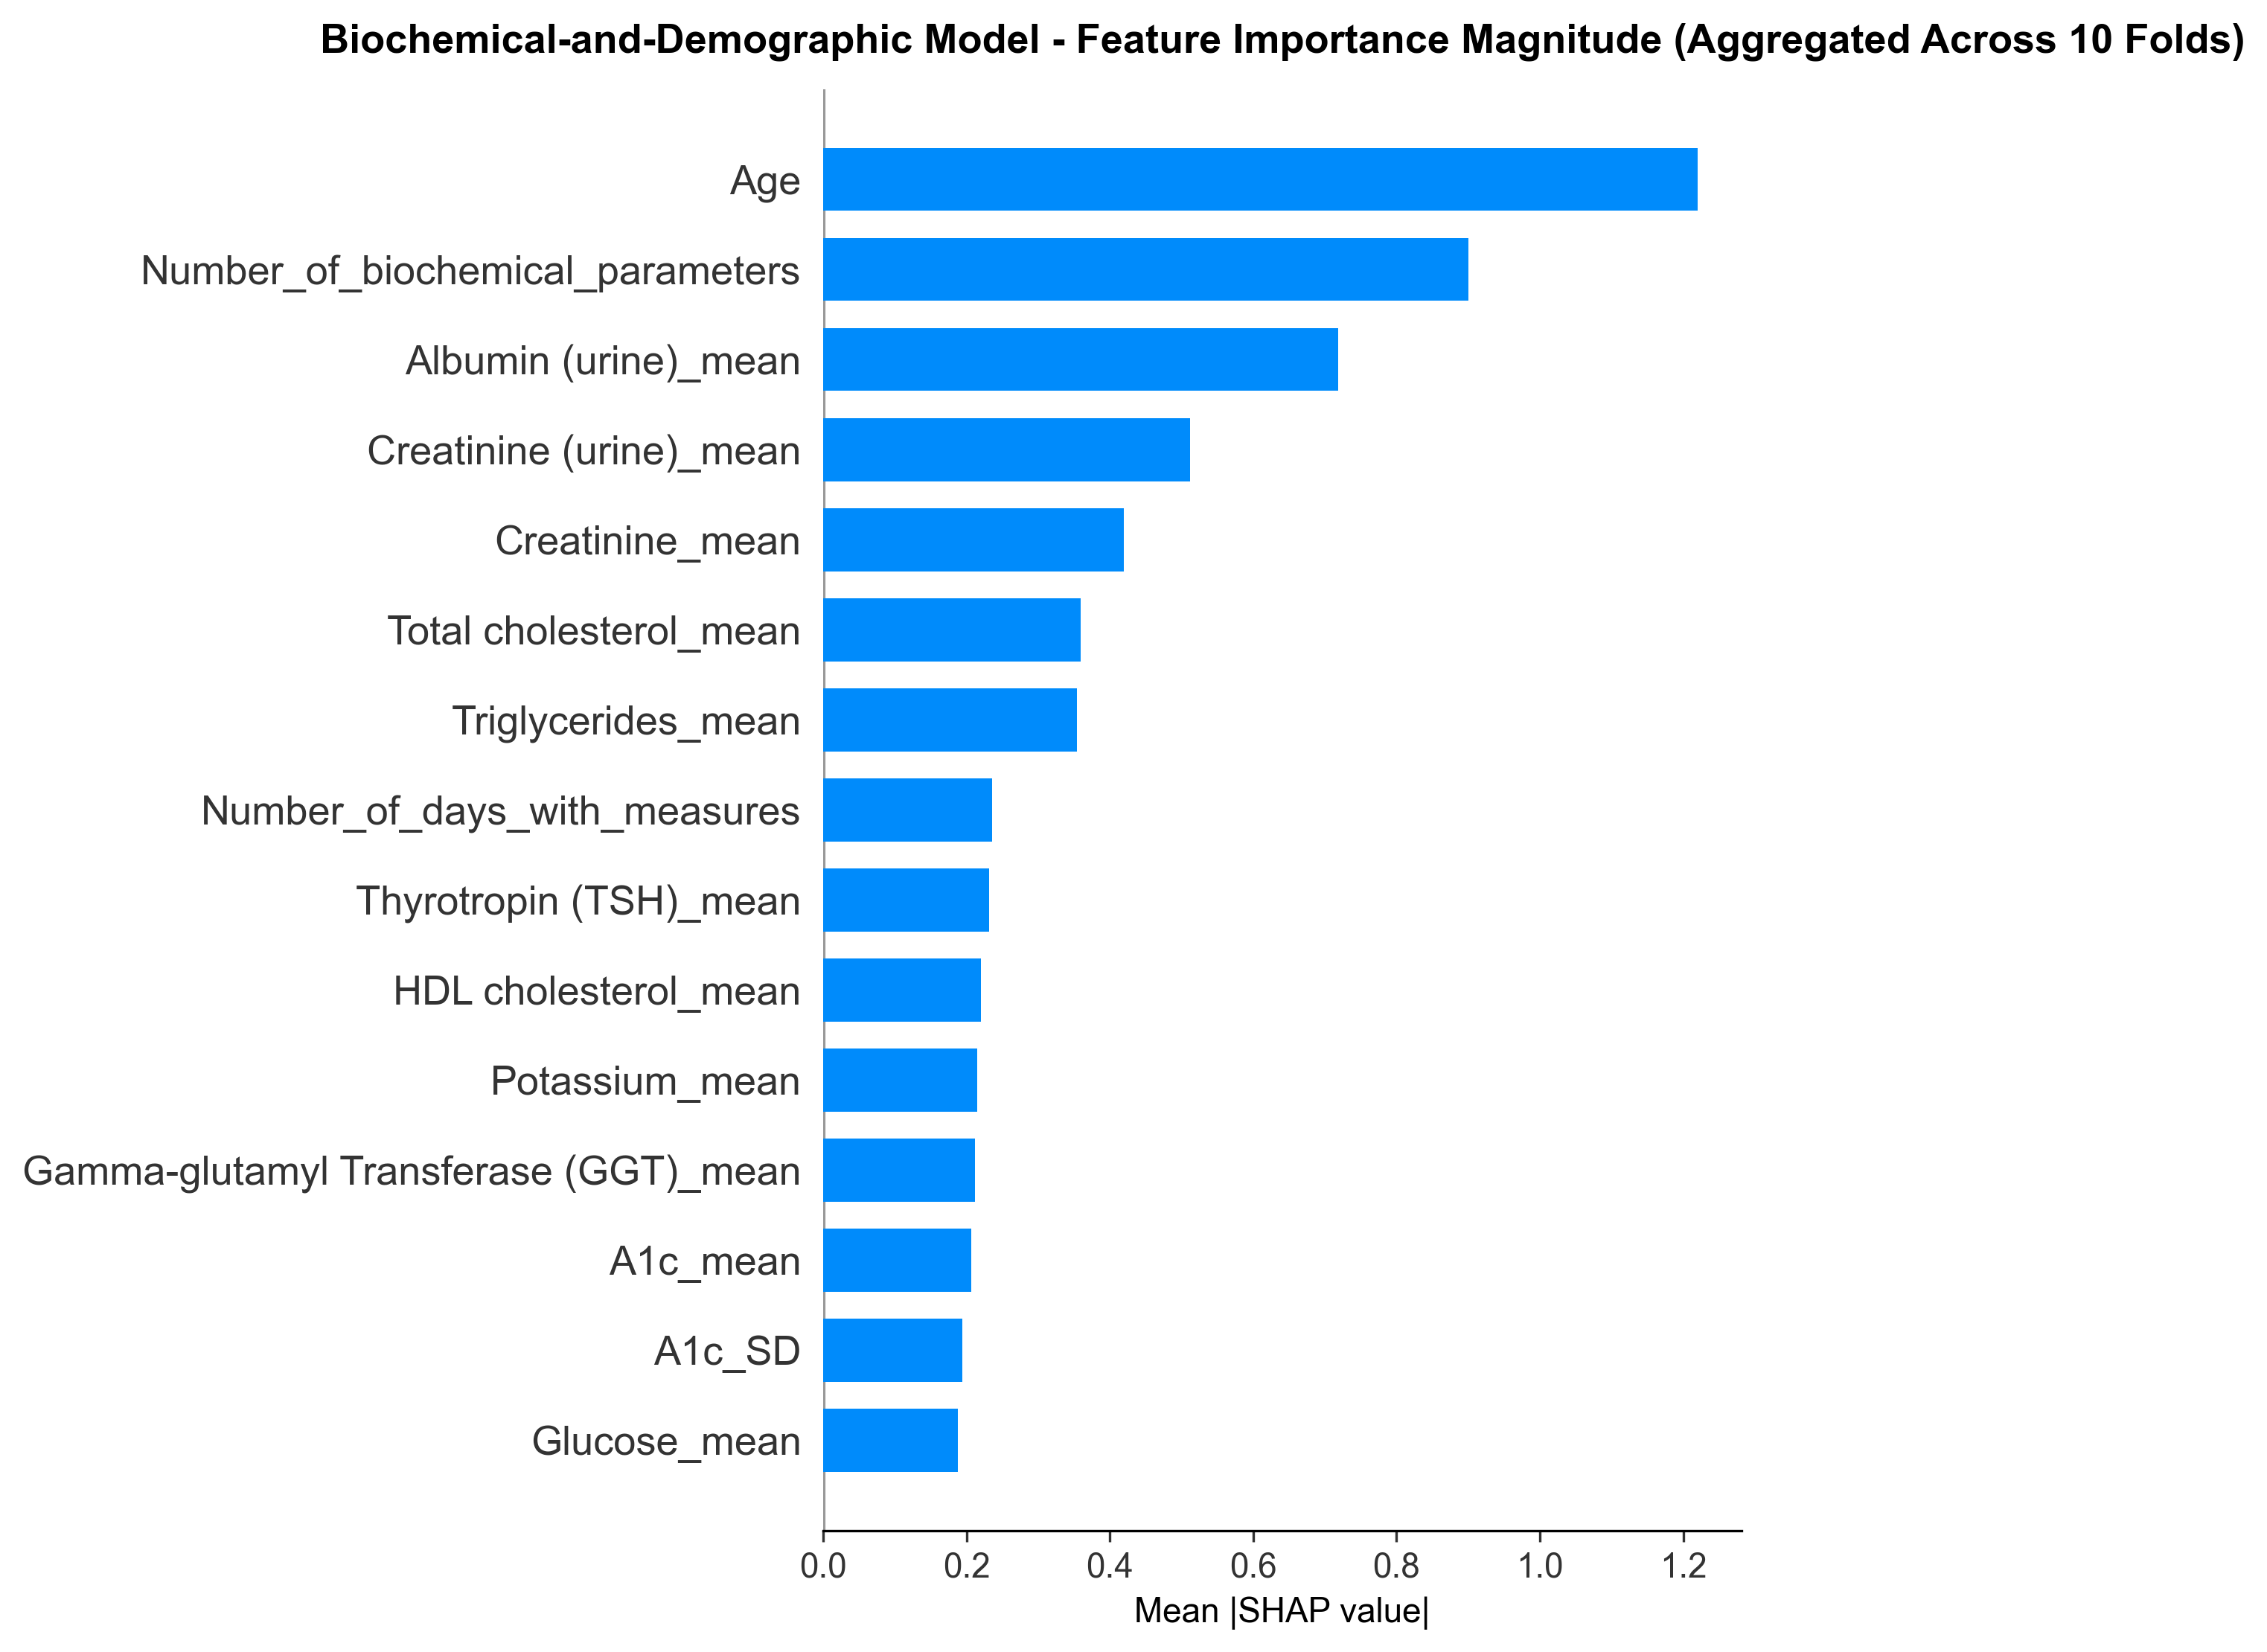

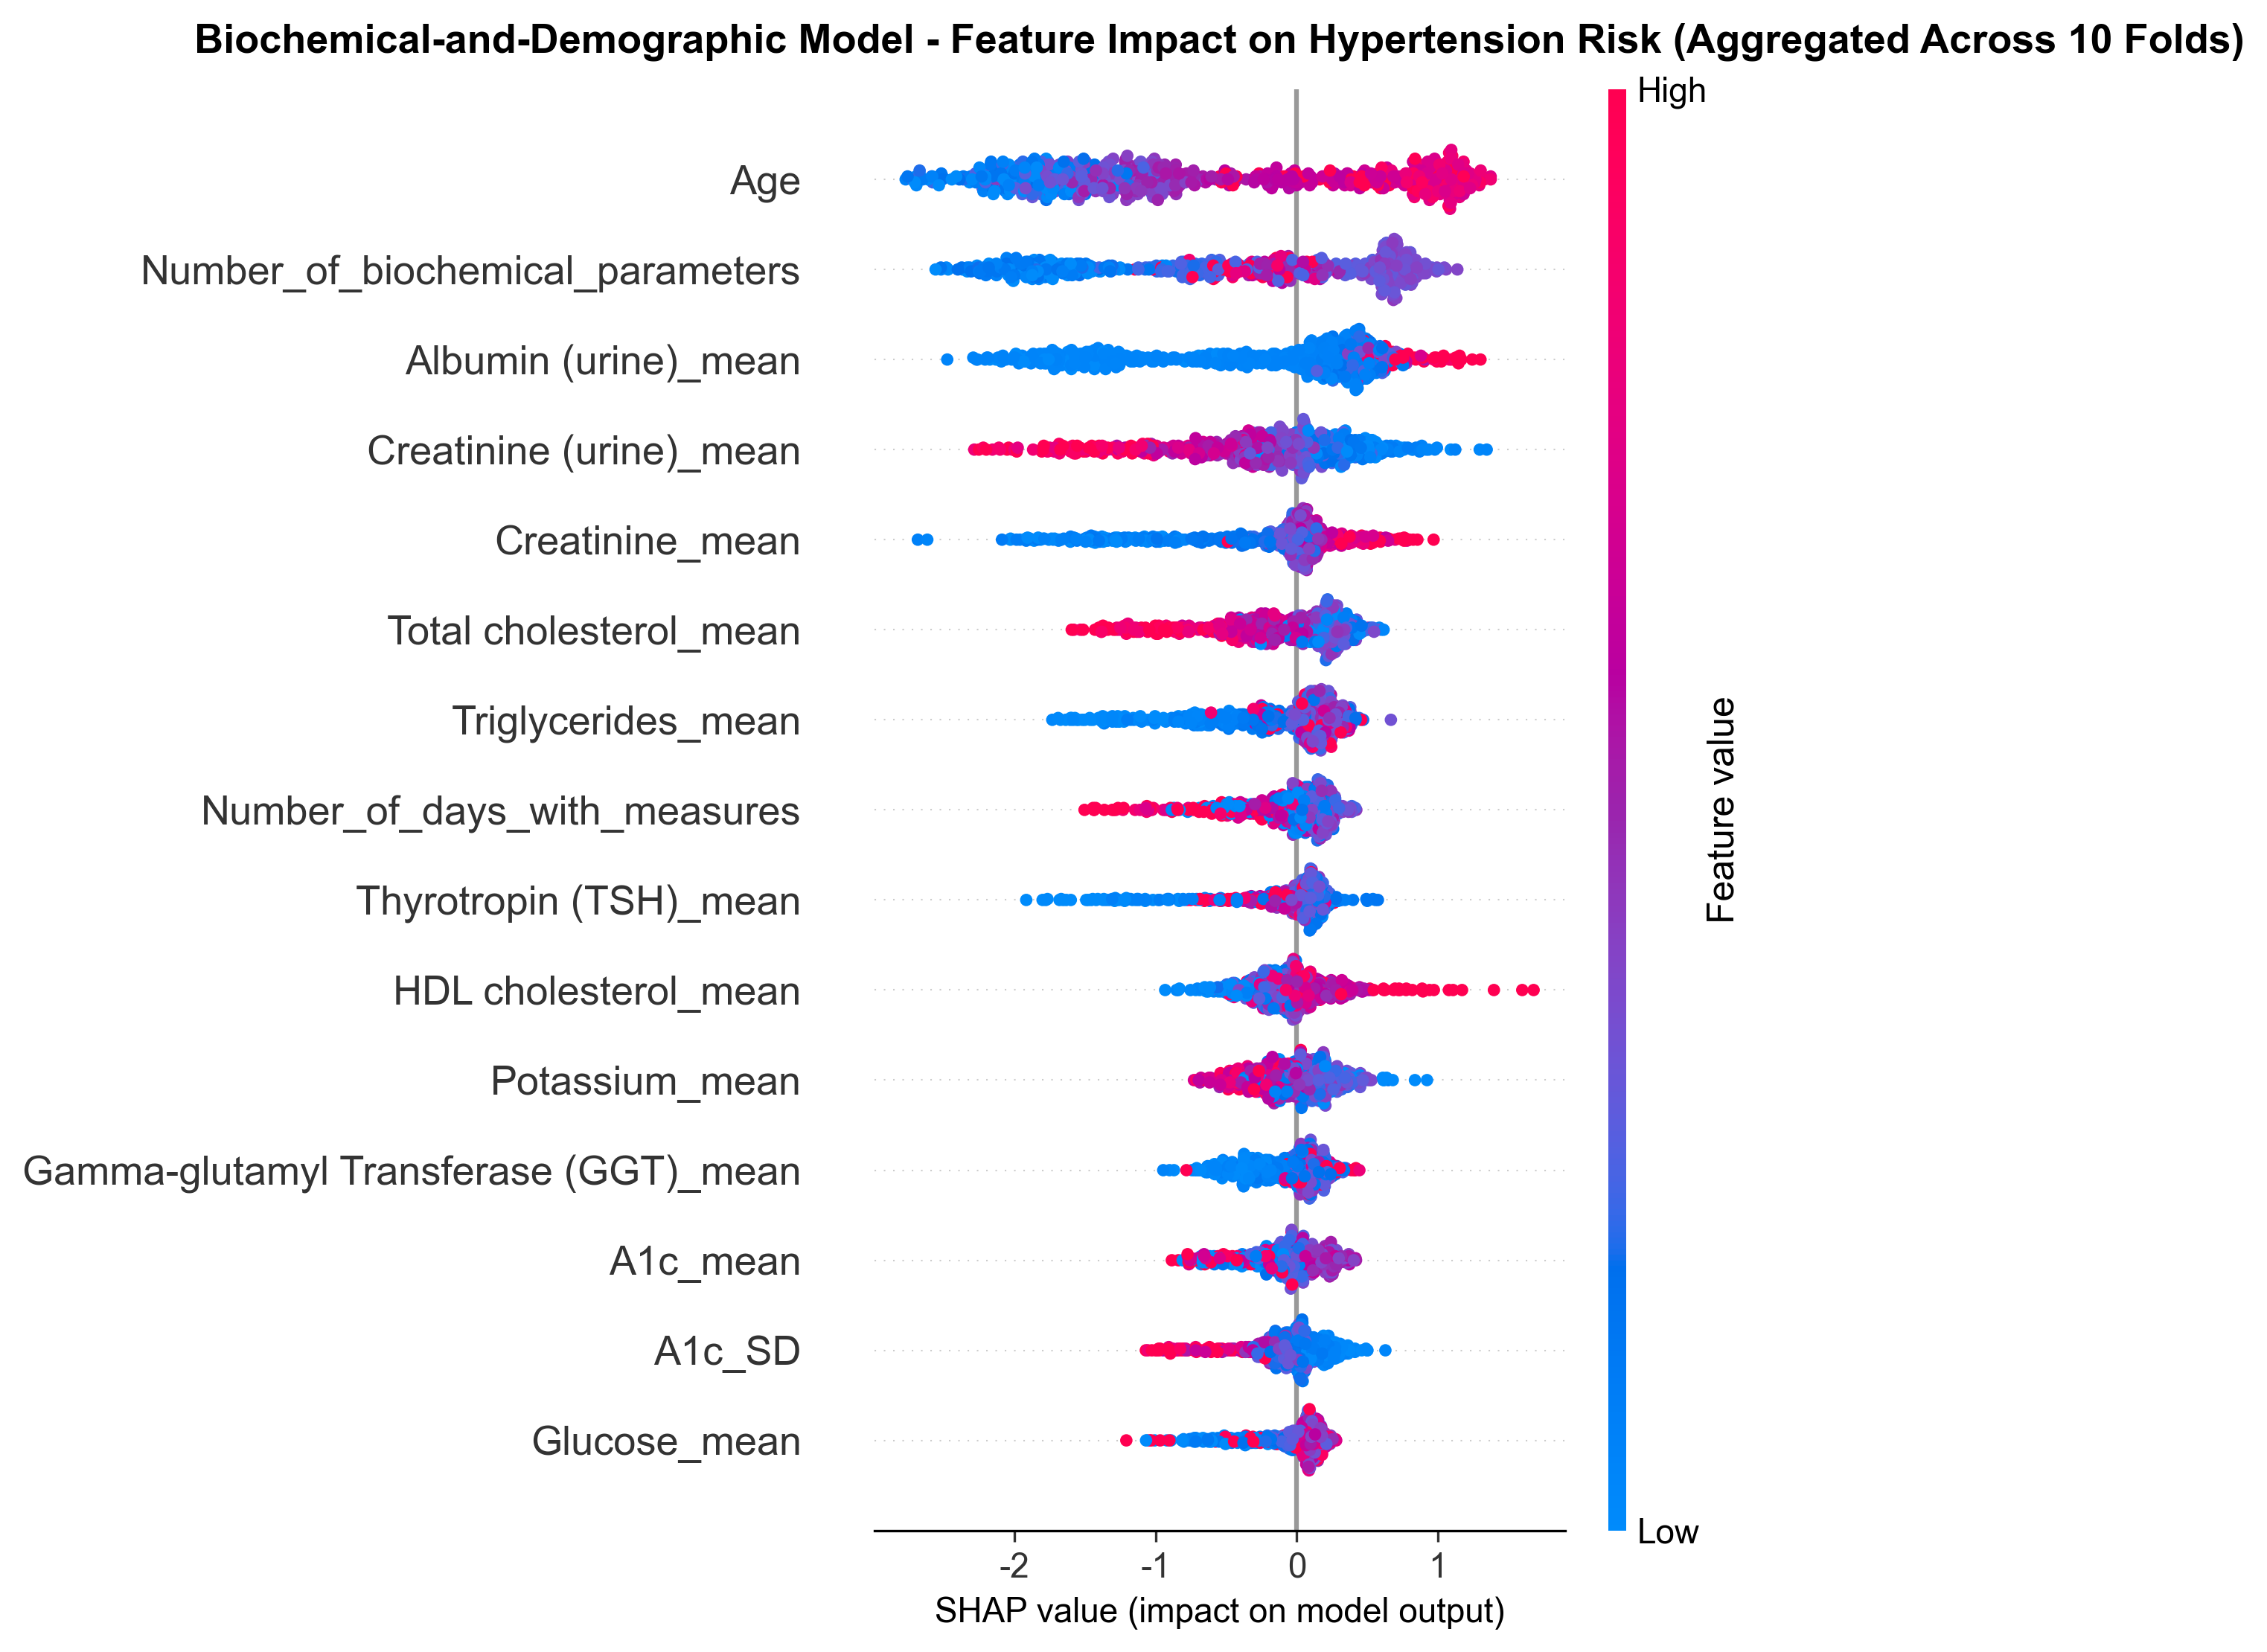


Top 20 Most Important Features (Biochemical-and-Demographic):
                                  Feature  Mean_|SHAP|  Mean_SHAP
5                                     Age     1.220267  -0.689693
4        Number_of_biochemical_parameters     0.900368  -0.459572
7                    Albumin (urine)_mean     0.718291  -0.273032
9                 Creatinine (urine)_mean     0.511752  -0.255577
8                         Creatinine_mean     0.419730  -0.233531
16                 Total cholesterol_mean     0.359137  -0.128923
17                     Triglycerides_mean     0.353830  -0.159744
2            Number_of_days_with_measures     0.235486  -0.082310
15                 Thyrotropin (TSH)_mean     0.231584  -0.086843
12                   HDL cholesterol_mean     0.220486  -0.050023
13                         Potassium_mean     0.214936  -0.038465
10  Gamma-glutamyl Transferase (GGT)_mean     0.212308  -0.091211
0                                A1c_mean     0.207184  -0.071347
1            

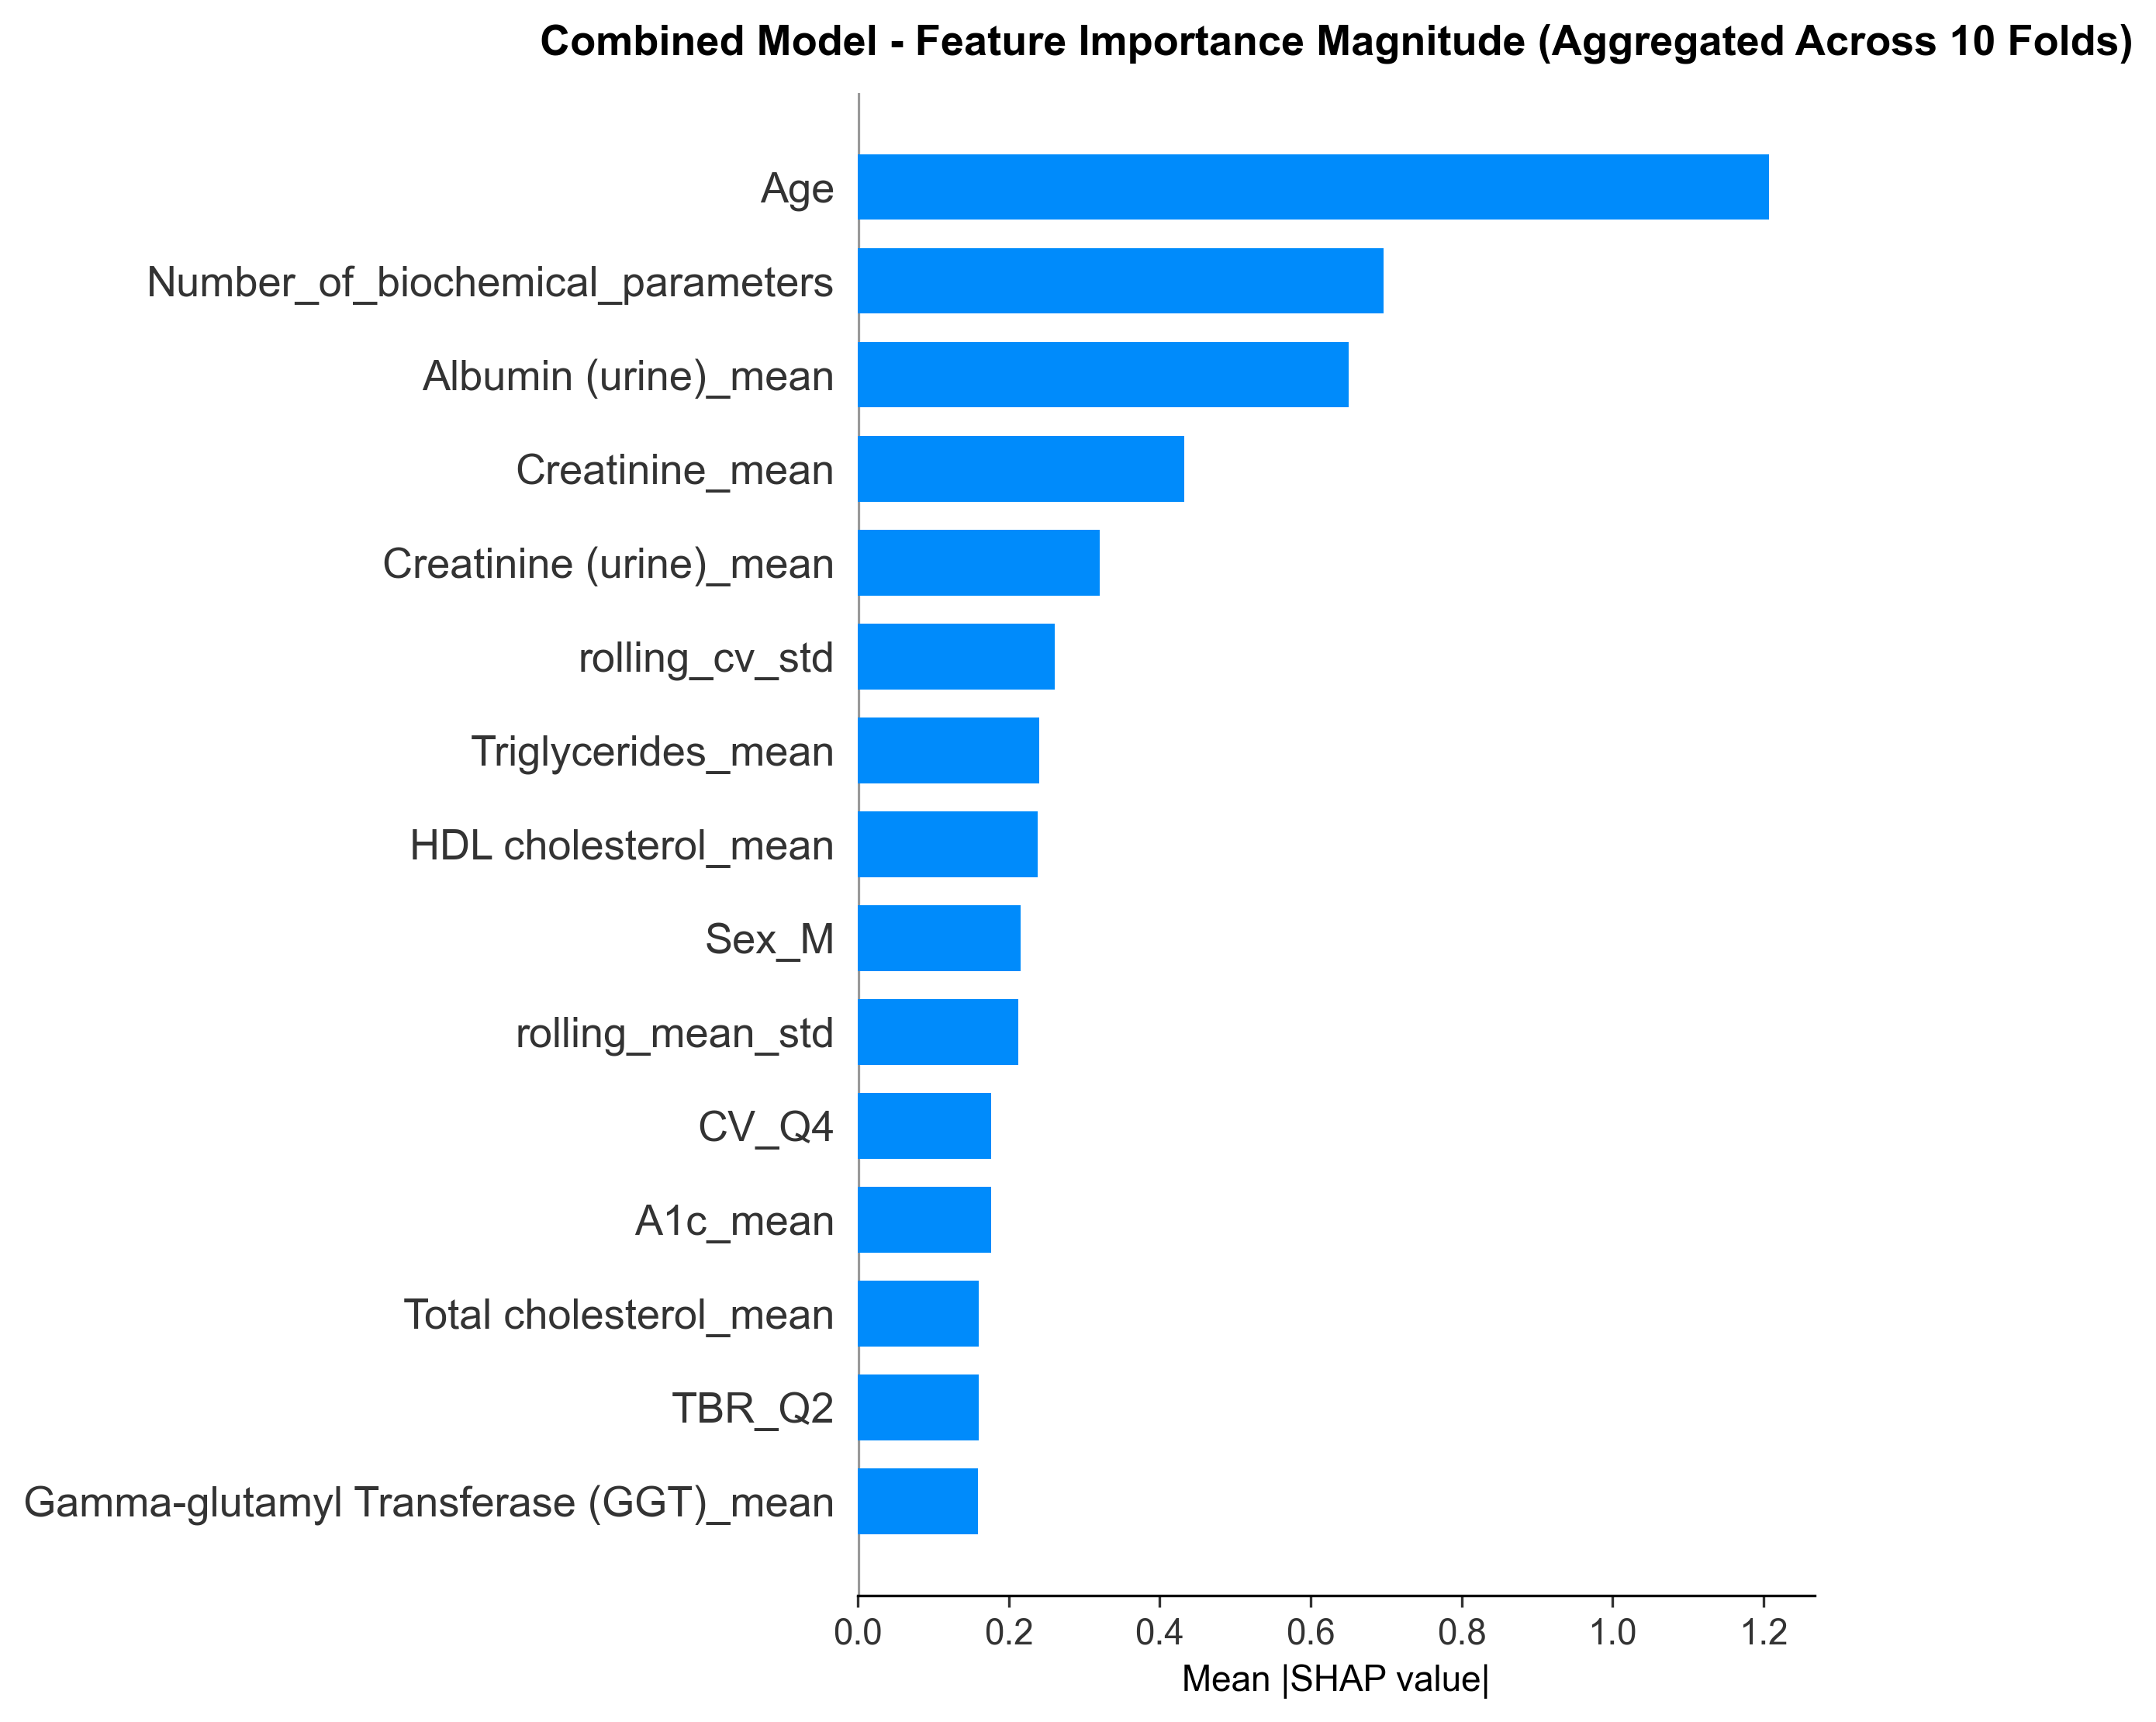

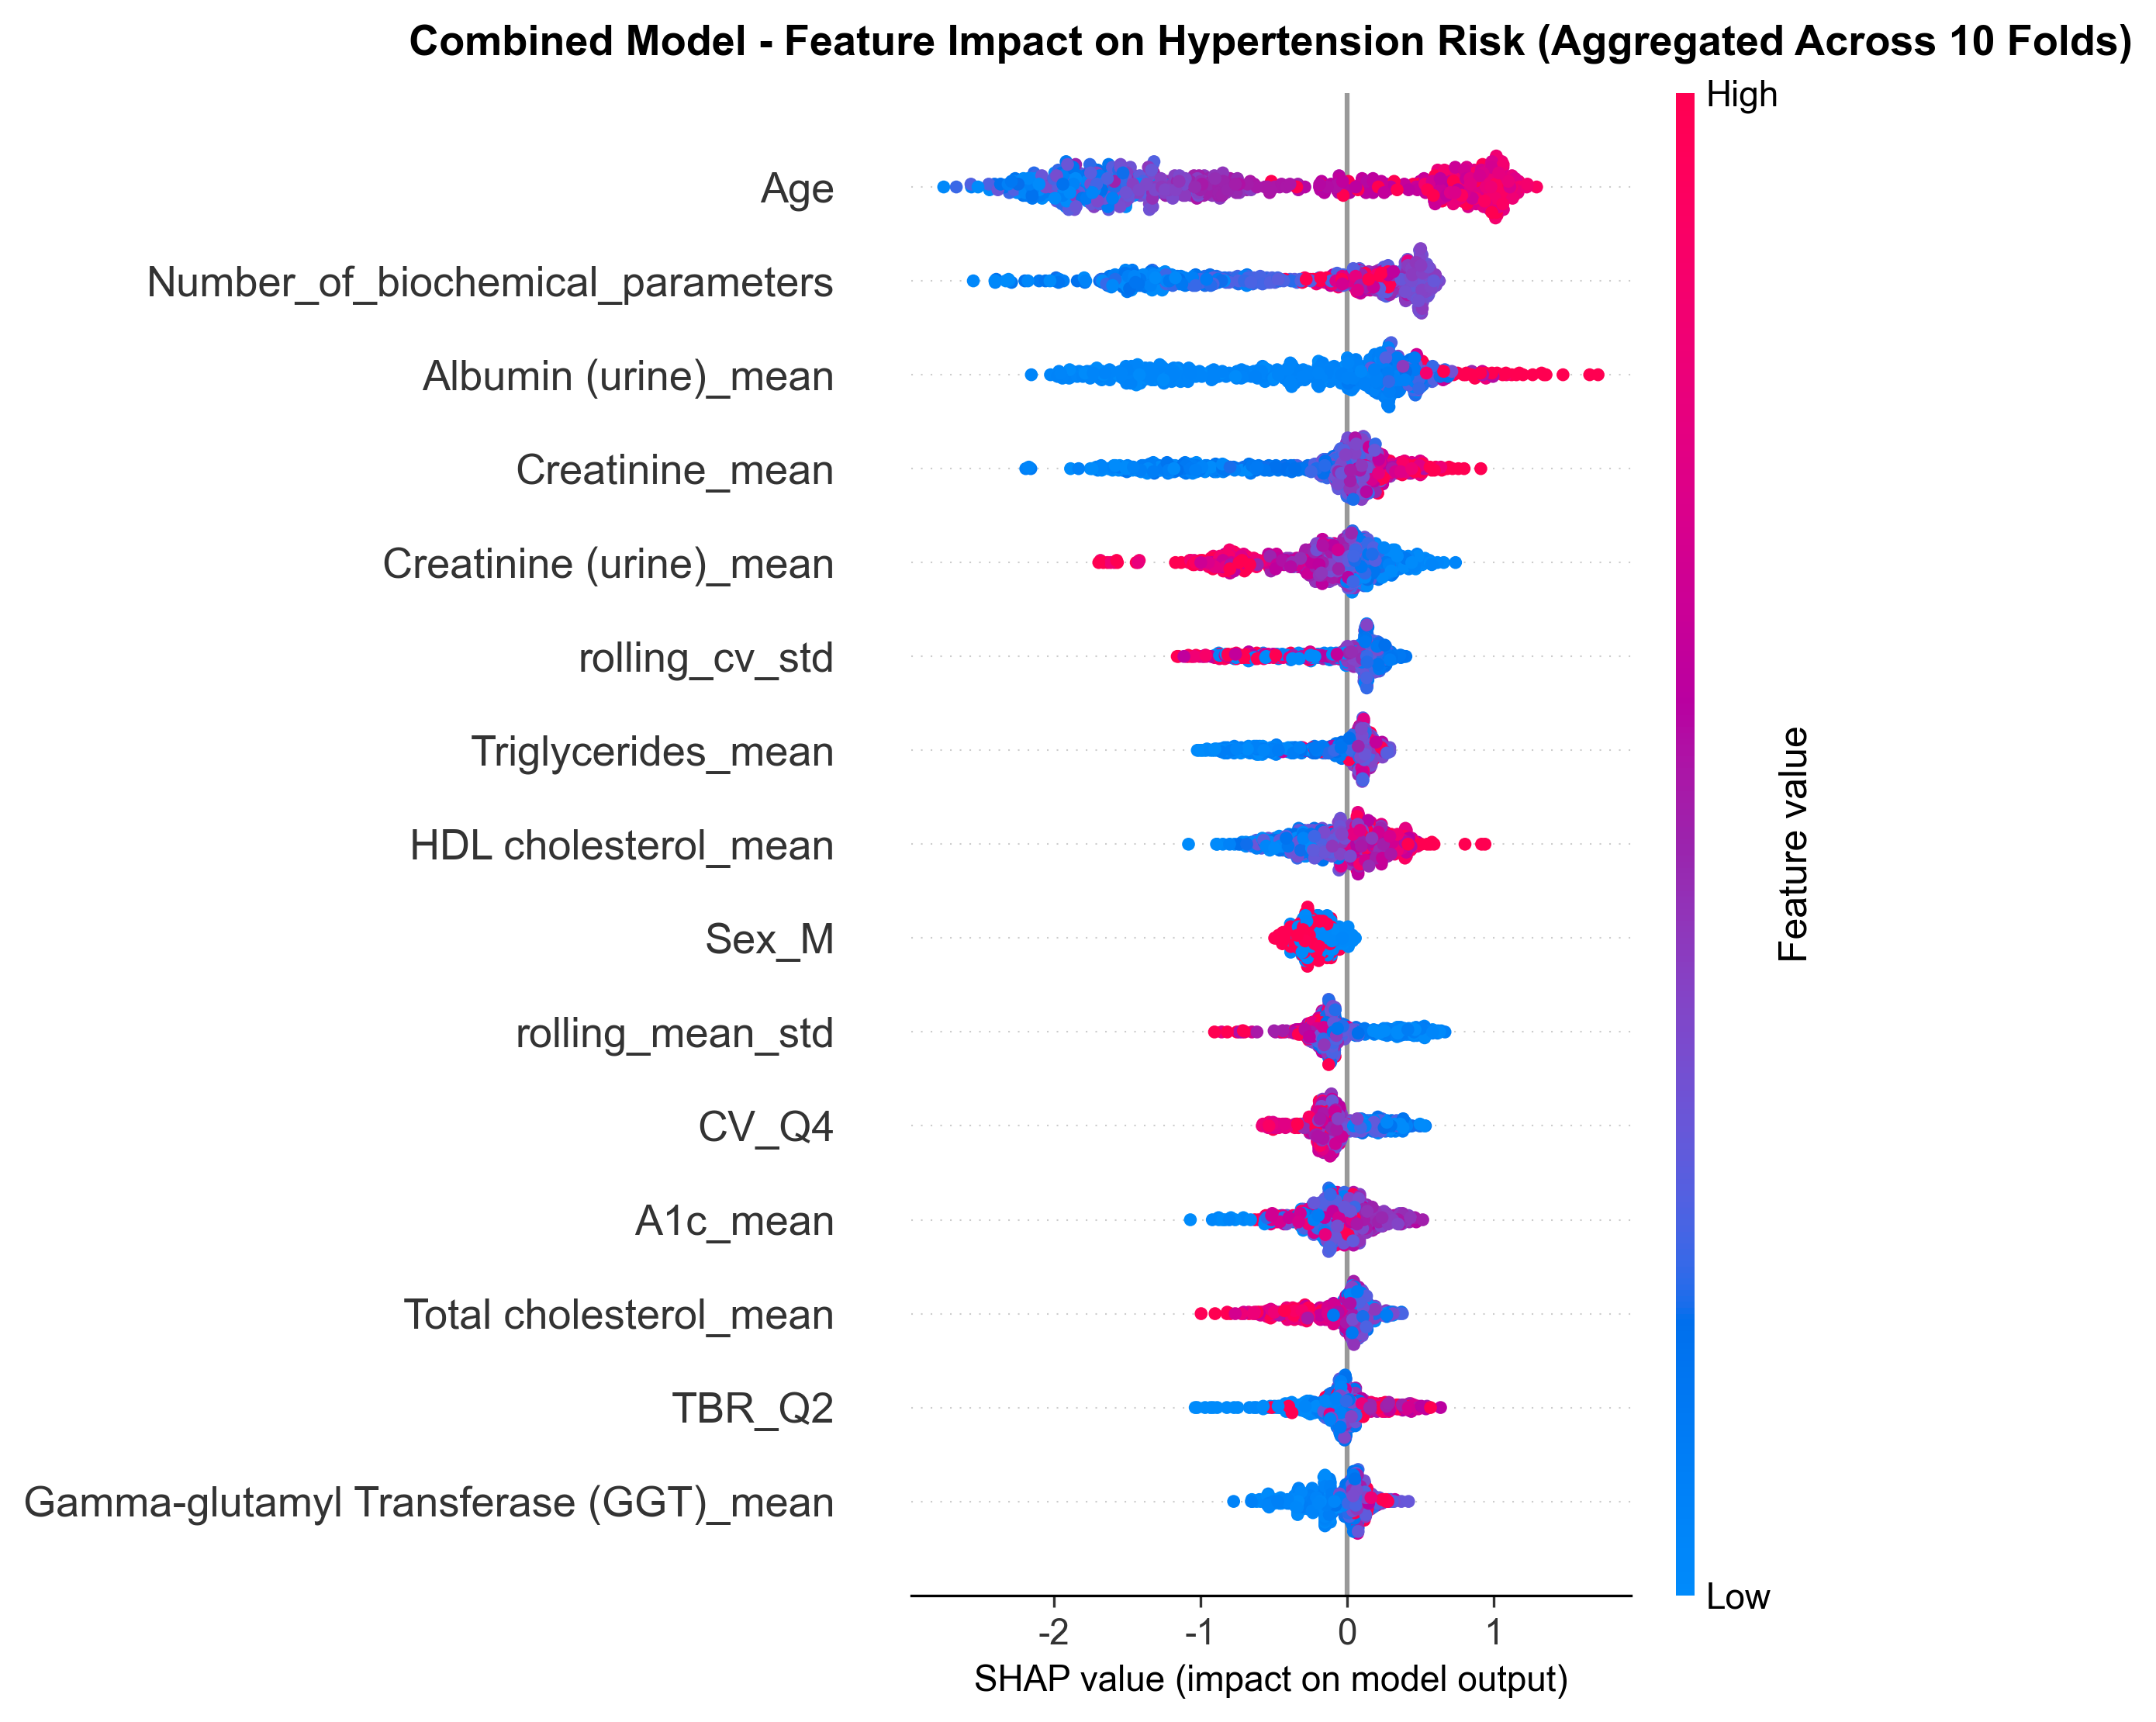


Top 20 Most Important Features (Combined):
                                  Feature  Mean_|SHAP|  Mean_SHAP
41                                    Age     1.207364  -0.657457
40       Number_of_biochemical_parameters     0.696913  -0.349968
43                   Albumin (urine)_mean     0.650473  -0.256554
44                        Creatinine_mean     0.432519  -0.223073
45                Creatinine (urine)_mean     0.320474  -0.149912
20                         rolling_cv_std     0.261311  -0.062359
53                     Triglycerides_mean     0.240774  -0.102361
48                   HDL cholesterol_mean     0.238668  -0.038557
55                                  Sex_M     0.215459  -0.213920
19                       rolling_mean_std     0.213017  -0.022240
11                                  CV_Q4     0.177110  -0.047395
36                               A1c_mean     0.177088  -0.055400
52                 Total cholesterol_mean     0.160004  -0.057597
5                               

In [10]:
def plot_shap_summary(shap_values, X_test_array, feature_names,
                      model_name='Combined',
                      condition='Hypertension',
                      display=True):
    print(f"Using SHAP values shape: {shap_values.shape}")

    # --- Plot A: Bar plot (Mean |SHAP|) ---
    plt.figure(figsize=(8, 8))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="bar",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"{model_name} Model - Feature Importance Magnitude (Aggregated Across 10 Folds)",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("Mean |SHAP value|", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()

    # --- Plot B: Beeswarm (directionality) ---
    plt.figure(figsize=(8, 10))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="dot",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"{model_name} Model - Feature Impact on {condition} Risk (Aggregated Across 10 Folds)",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("SHAP value (impact on model output)", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()

    shap_importance = pd.DataFrame({
        "Feature": feature_names,
        "Mean_|SHAP|": np.abs(shap_values).mean(axis=0),
        "Mean_SHAP": shap_values.mean(axis=0)
    }).sort_values("Mean_|SHAP|", ascending=False)

    return shap_importance


def aggregate_shap_across_folds(results, cgm_key, feature_names, n_folds=10):
    shap_values_all = []
    X_test_all = []

    for fold_idx in range(n_folds):
        print(f"  Computing SHAP for fold {fold_idx + 1}/{n_folds}...")

        model = results[cgm_key]['models'][fold_idx]
        X_test = results[cgm_key]['X_test_scaled'][fold_idx]

        if not isinstance(X_test, np.ndarray):
            X_test = X_test.values if hasattr(X_test, 'values') else np.array(X_test)

        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X_test)

        if isinstance(sv, list):
            print(f"    SHAP is list with {len(sv)} elements — using index 1 (positive class)")
            sv = sv[1]

        shap_values_all.append(sv)
        X_test_all.append(X_test)

    shap_values_agg = np.concatenate(shap_values_all, axis=0)
    X_test_agg = np.concatenate(X_test_all, axis=0)

    print(f"  Aggregated SHAP shape: {shap_values_agg.shape}")
    return shap_values_agg, X_test_agg


def compute_shap_stability(results, cgm_key, feature_names, n_folds=10):
    fold_shap_means = []

    for fold_idx in range(n_folds):
        model = results[cgm_key]['models'][fold_idx]
        X_test = results[cgm_key]['X_test_scaled'][fold_idx]

        if not isinstance(X_test, np.ndarray):
            X_test = X_test.values if hasattr(X_test, 'values') else np.array(X_test)

        explainer = shap.TreeExplainer(model)
        sv = explainer.shap_values(X_test)

        if isinstance(sv, list):
            sv = sv[1]

        fold_shap_means.append(np.abs(sv).mean(axis=0))

    fold_shap_means = np.array(fold_shap_means)  # shape: (n_folds, n_features)

    stability_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean_|SHAP|_across_folds": fold_shap_means.mean(axis=0),
        "SD_|SHAP|_across_folds": fold_shap_means.std(axis=0)
    }).sort_values("Mean_|SHAP|_across_folds", ascending=False)

    return stability_df

# MAIN PIPELINE

condition = 'Hypertension'
seed = 42
n_folds = 10
results = all_results[condition][seed]

feature_names_with = results['feature_names']['with_cgm']
feature_names_without = results['feature_names']['without_cgm']

# ── BIOCHEMICAL-AND-DEMOGRAPHIC MODEL (Without CGM) ──
print("\n" + "="*60)
print("BIOCHEMICAL-AND-DEMOGRAPHIC MODEL (Without CGM)")
print("="*60)

print("\nAggregating SHAP values across all folds (Without CGM)...")
shap_values_without_agg, X_test_without_agg = aggregate_shap_across_folds(
    results, 'without_cgm', feature_names_without, n_folds=n_folds
)

shap_importance_without = plot_shap_summary(
    shap_values=shap_values_without_agg,
    X_test_array=X_test_without_agg,
    feature_names=feature_names_without,
    model_name='Biochemical-and-Demographic',
    condition=condition,
    display=True
)

print("\nTop 20 Most Important Features (Biochemical-and-Demographic):")
print(shap_importance_without.head(20).to_string())

print("\nFeature Stability Across Folds (Biochemical-and-Demographic):")
stability_without = compute_shap_stability(
    results, 'without_cgm', feature_names_without, n_folds=n_folds
)
print(stability_without.head(20).to_string())


# ── COMBINED MODEL (With CGM) ──
print("\n" + "="*60)
print("COMBINED MODEL (With CGM)")
print("="*60)

print("\nAggregating SHAP values across all folds (With CGM)...")
shap_values_with_agg, X_test_with_agg = aggregate_shap_across_folds(
    results, 'with_cgm', feature_names_with, n_folds=n_folds
)

shap_importance_with = plot_shap_summary(
    shap_values=shap_values_with_agg,
    X_test_array=X_test_with_agg,
    feature_names=feature_names_with,
    model_name='Combined',
    condition=condition,
    display=True
)

print("\nTop 20 Most Important Features (Combined):")
print(shap_importance_with.head(20).to_string())

print("\nFeature Stability Across Folds (Combined):")
stability_with = compute_shap_stability(
    results, 'with_cgm', feature_names_with, n_folds=n_folds
)
print(stability_with.head(20).to_string())


BIOCHEMICAL-AND-DEMOGRAPHIC MODEL (Without CGM)

Running interpretability pipeline for Biochemical-and-Demographic model...
Computing SHAP values...
SHAP values type: <class 'numpy.ndarray'>
Using SHAP values shape: (69, 20)


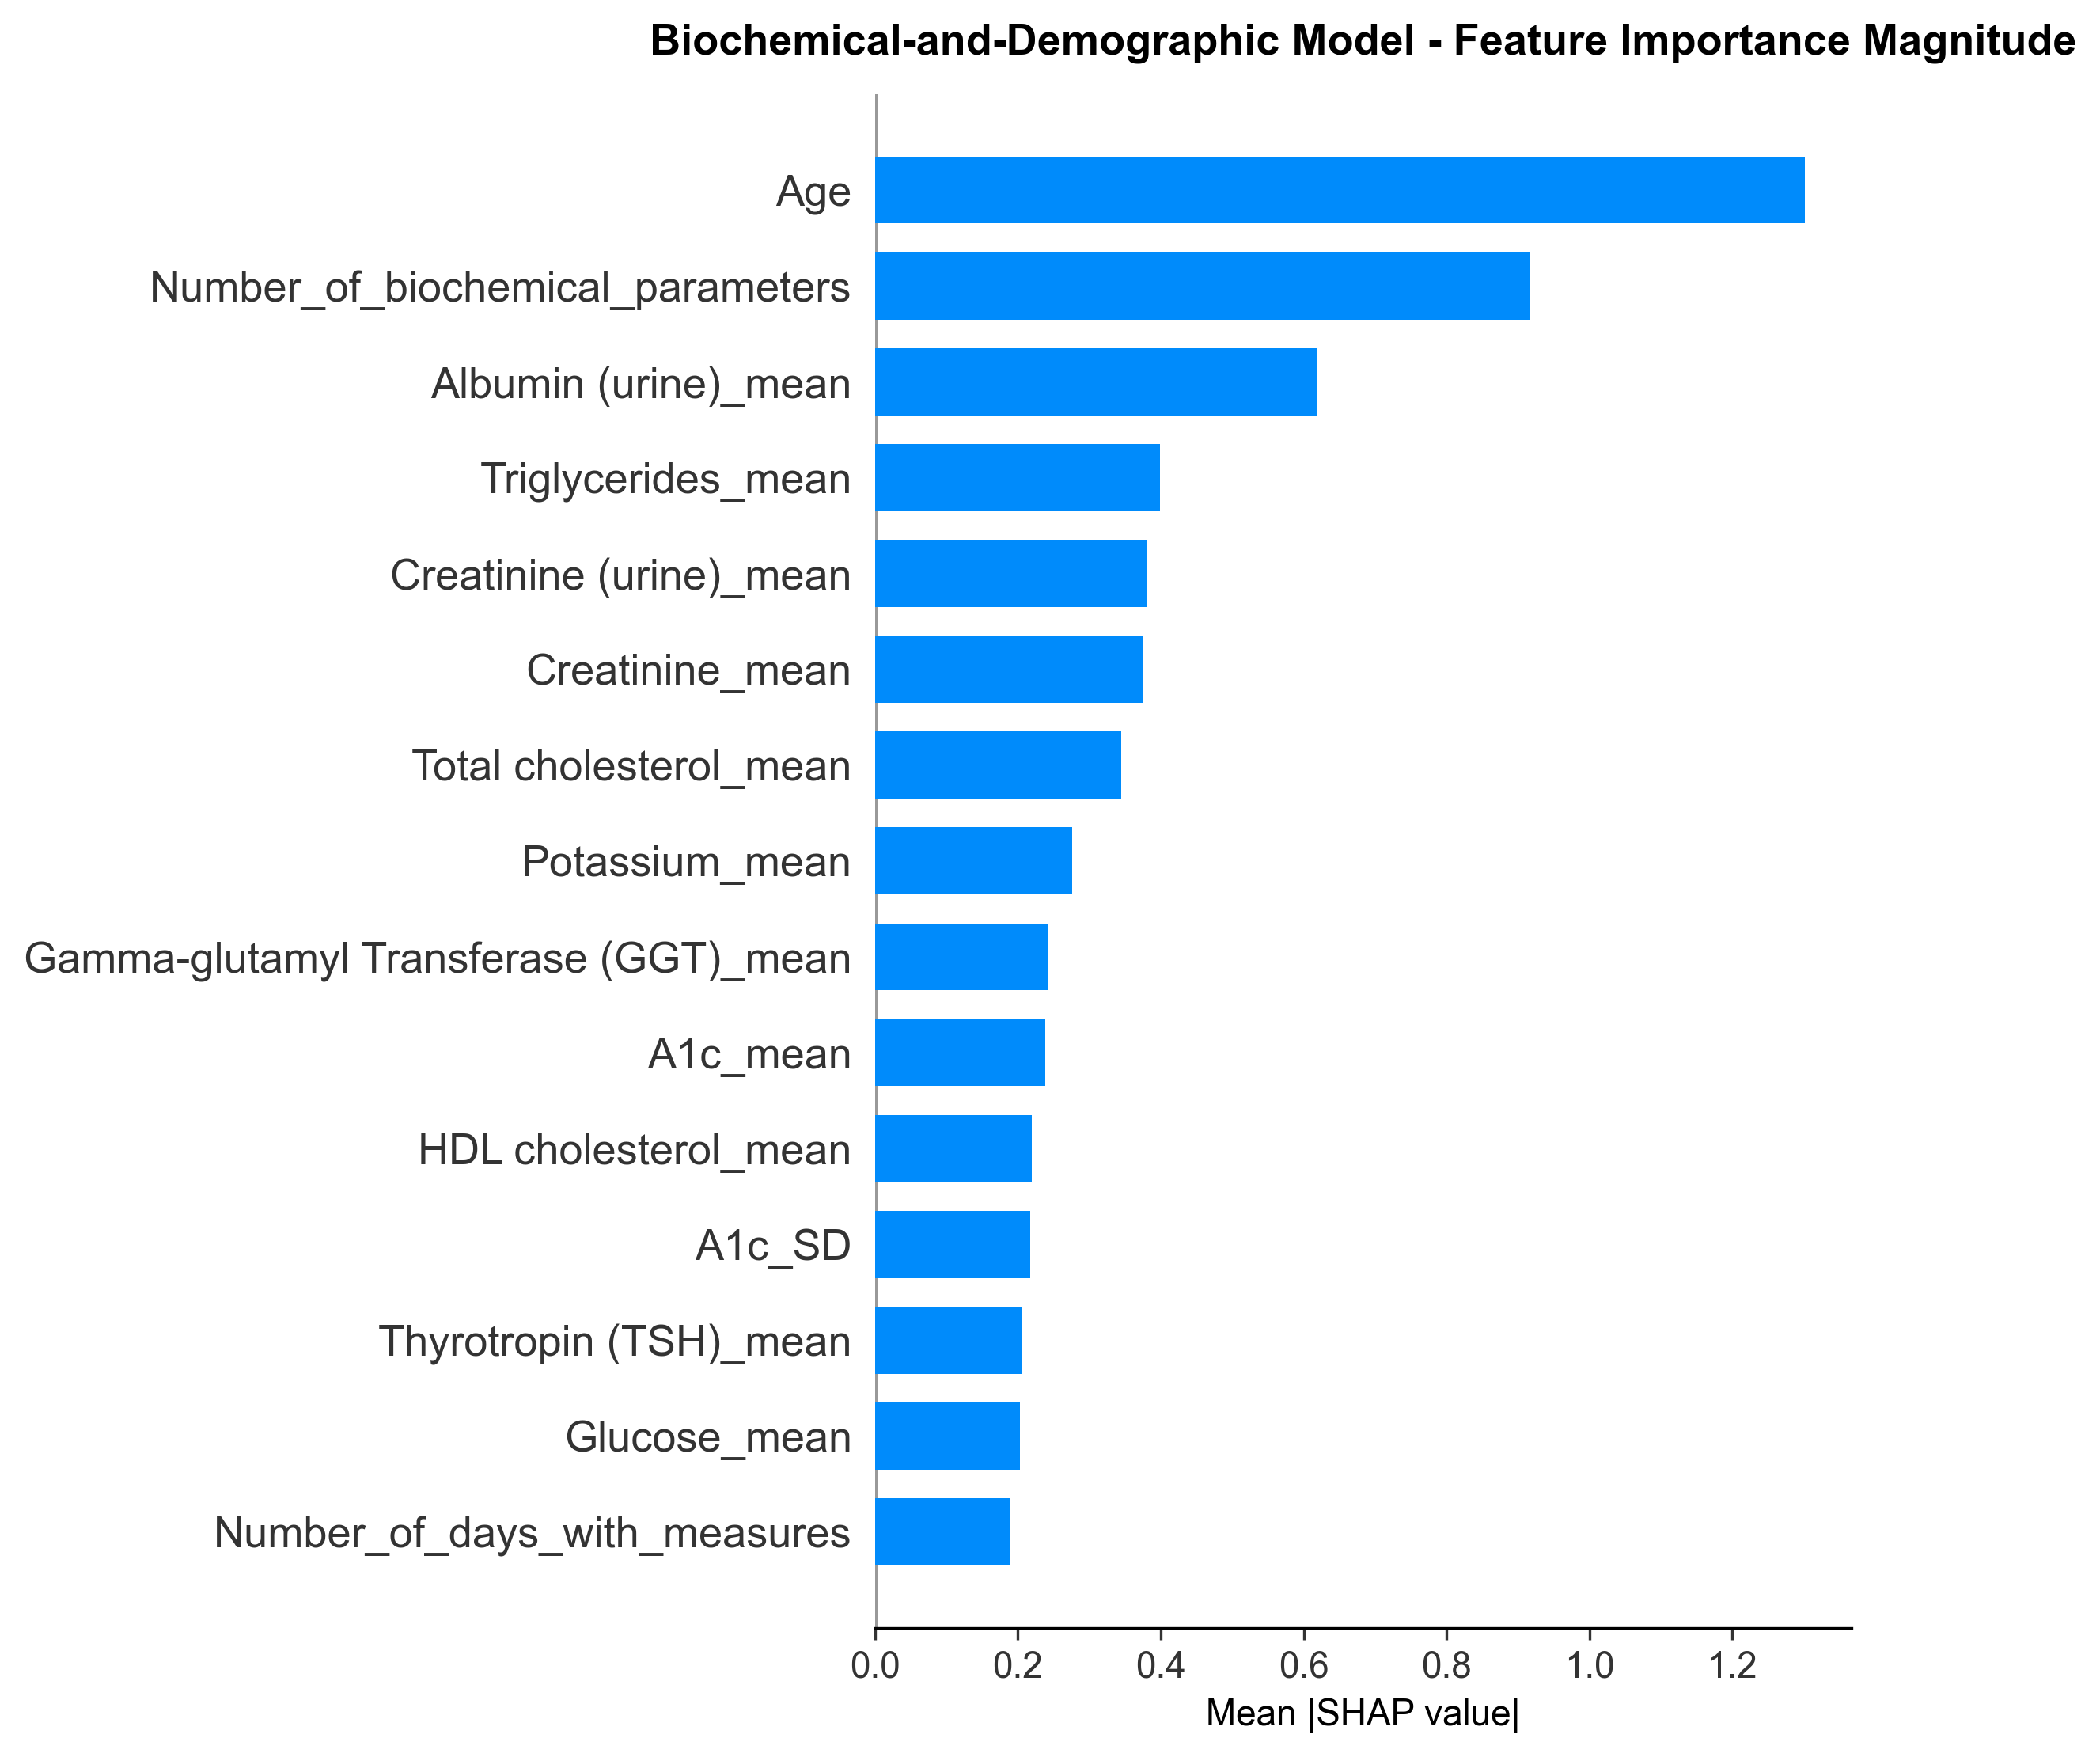

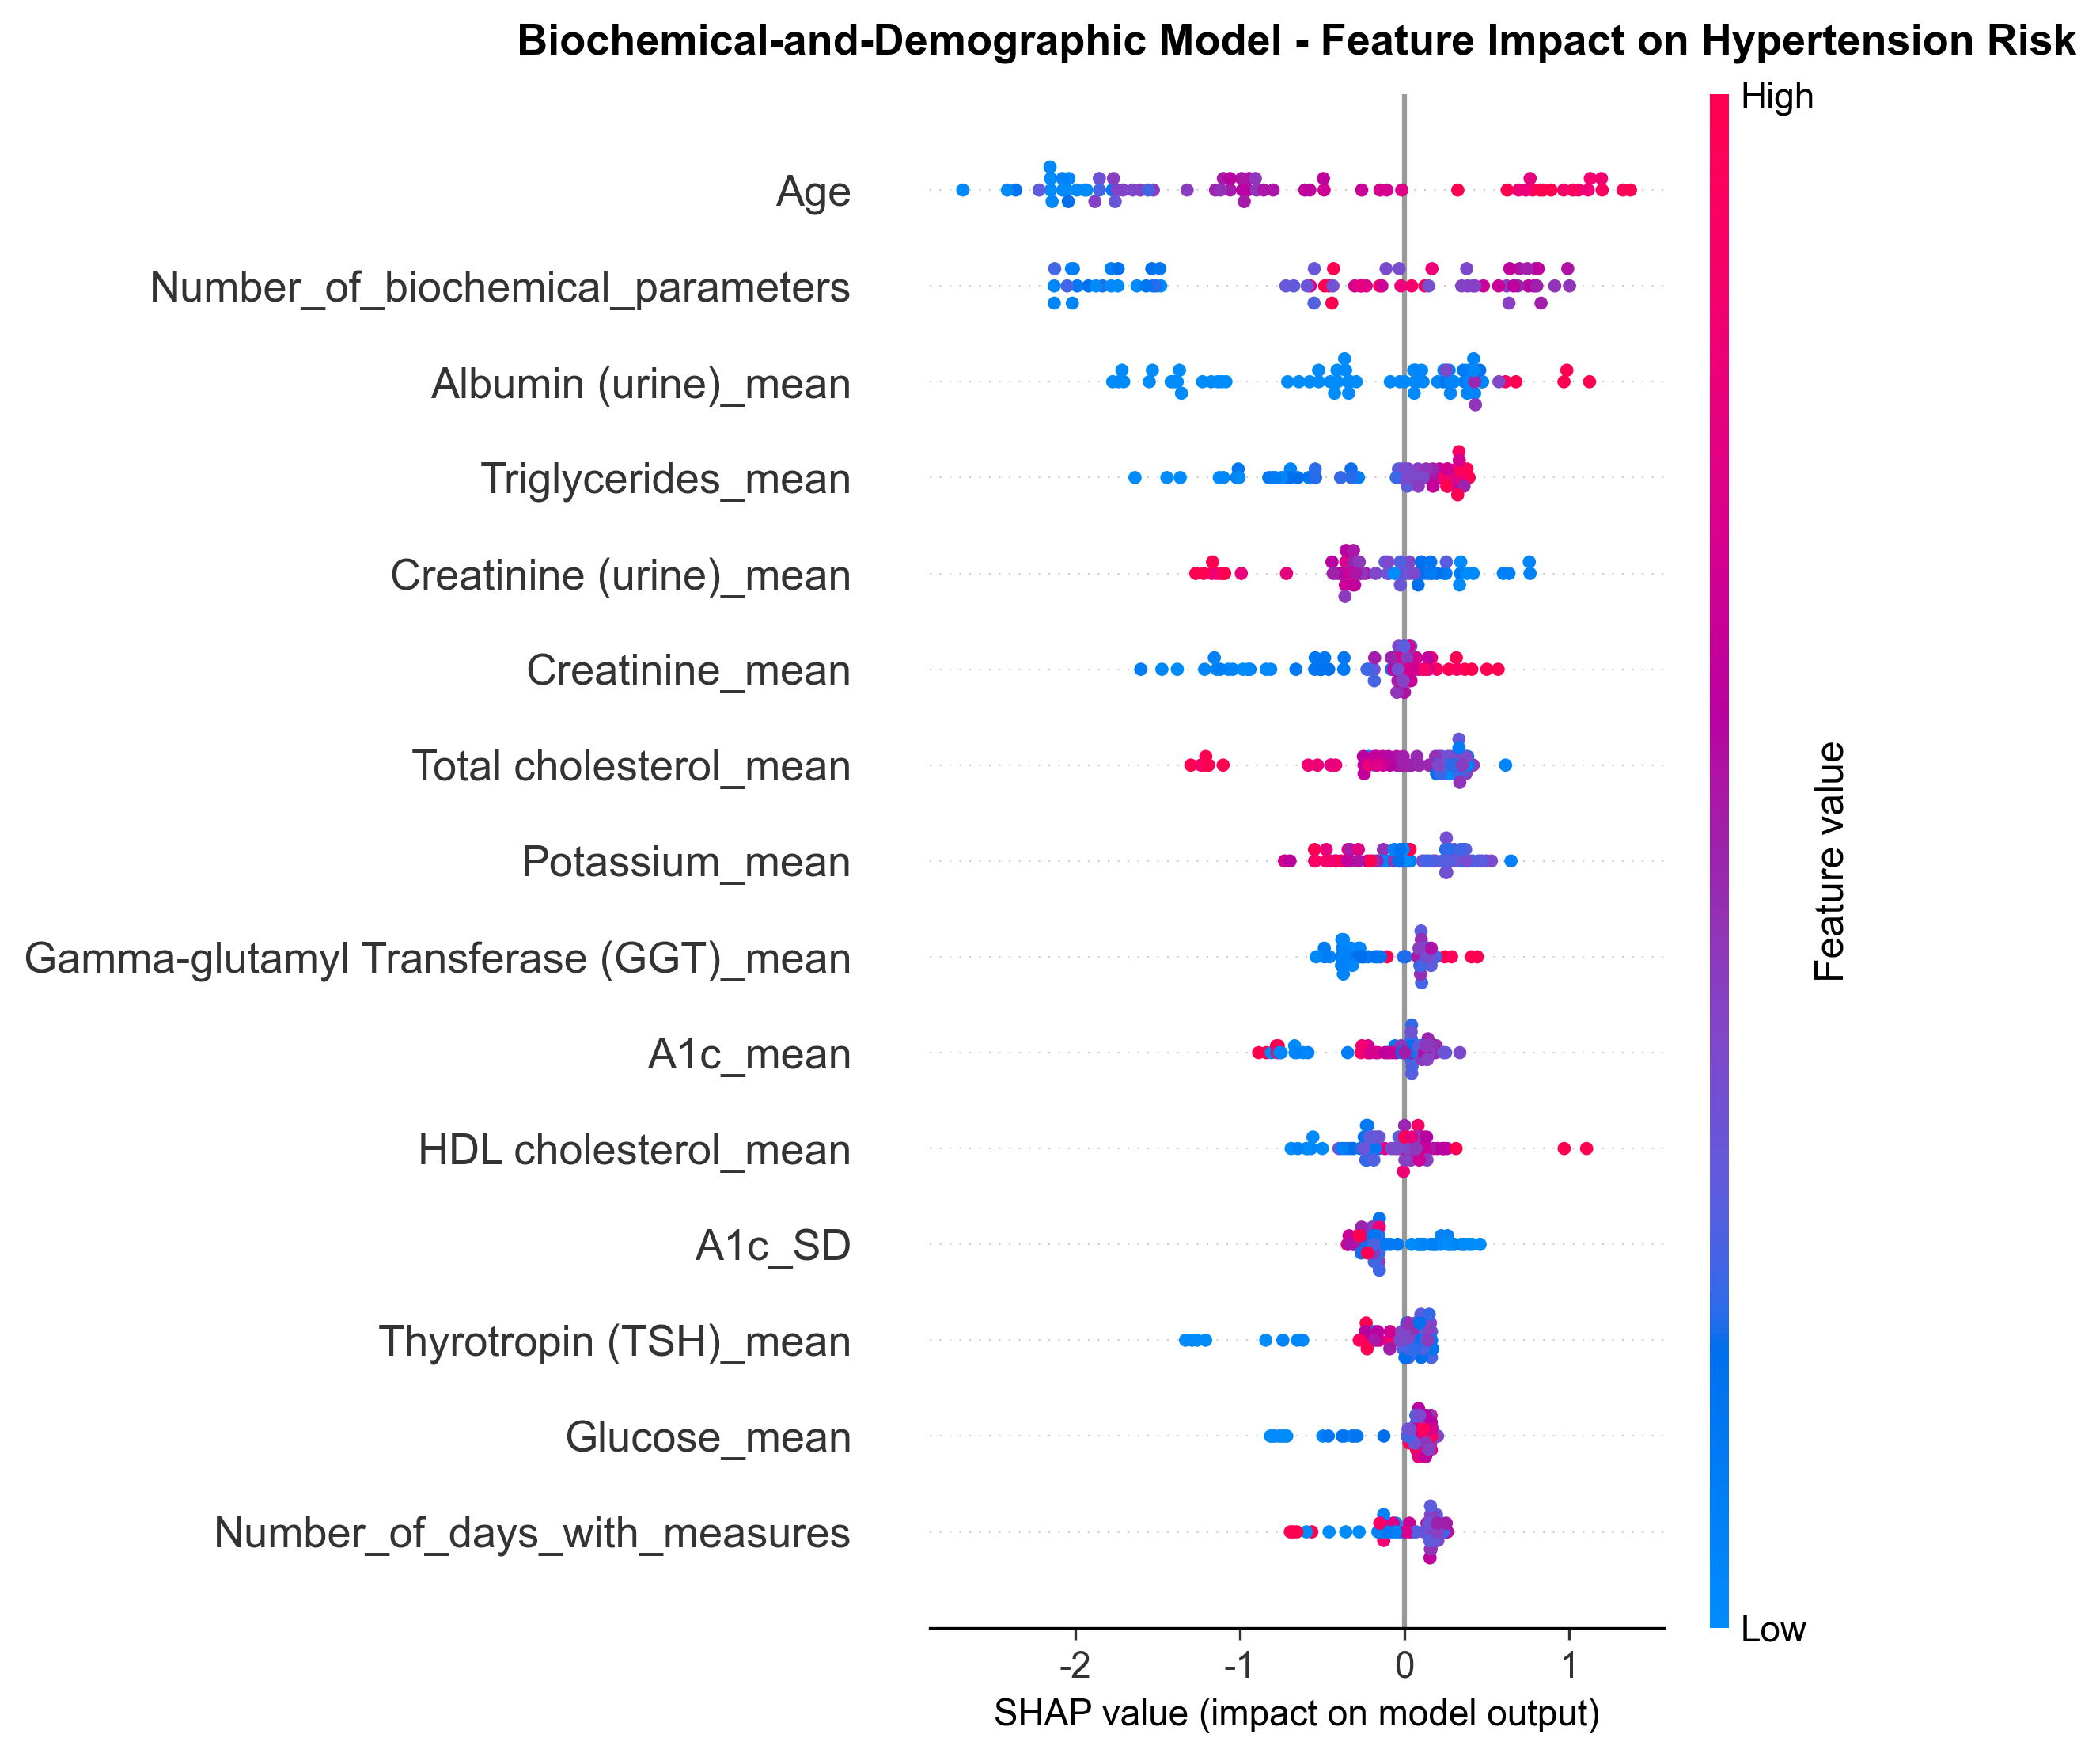


Biochemical-and-Demographic model interpretability figures generated.

Top 20 Most Important Features (Biochemical-and-Demographic):
                                  Feature  Mean_|SHAP|  Mean_SHAP
5                                     Age     1.301891  -0.812659
4        Number_of_biochemical_parameters     0.916066  -0.455862
7                    Albumin (urine)_mean     0.618903  -0.235696
17                     Triglycerides_mean     0.399363  -0.144304
9                 Creatinine (urine)_mean     0.380022  -0.184676
8                         Creatinine_mean     0.375084  -0.254305
16                 Total cholesterol_mean     0.344305  -0.042029
13                         Potassium_mean     0.275363   0.011170
10  Gamma-glutamyl Transferase (GGT)_mean     0.242433  -0.121150
0                                A1c_mean     0.238595  -0.115509
12                   HDL cholesterol_mean     0.219592  -0.070234
1                                  A1c_SD     0.217586  -0.057133
15      

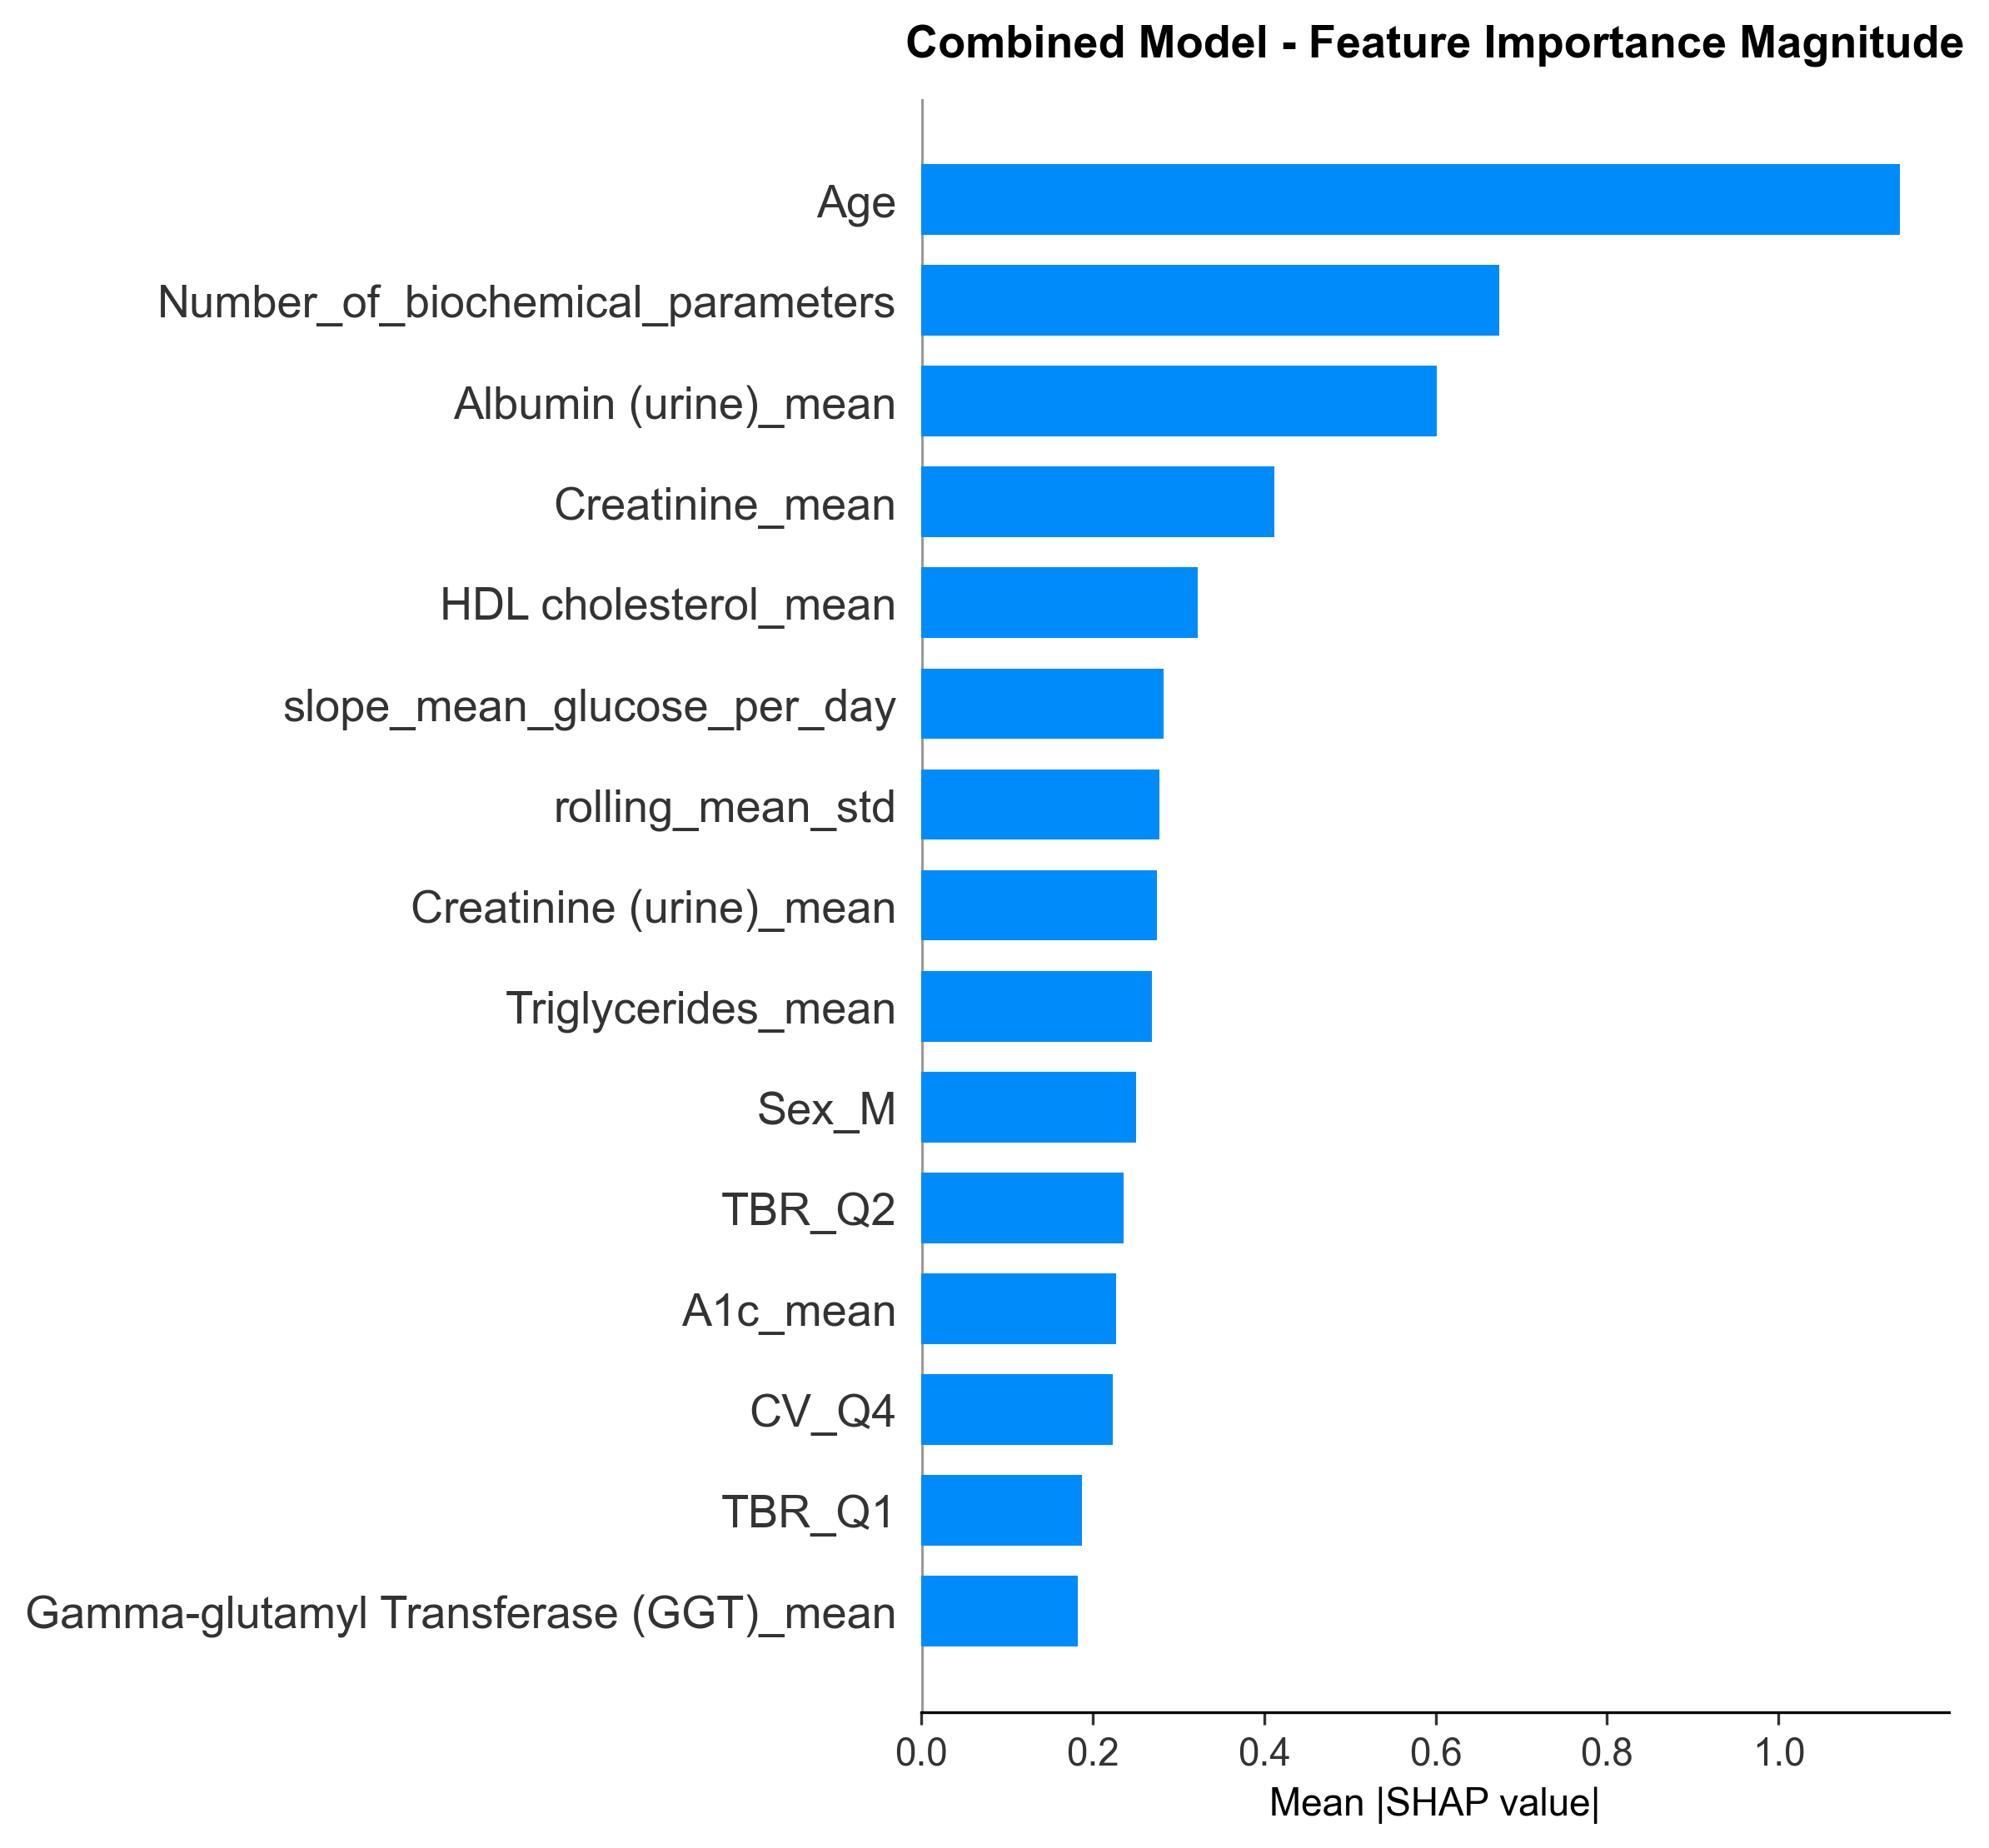

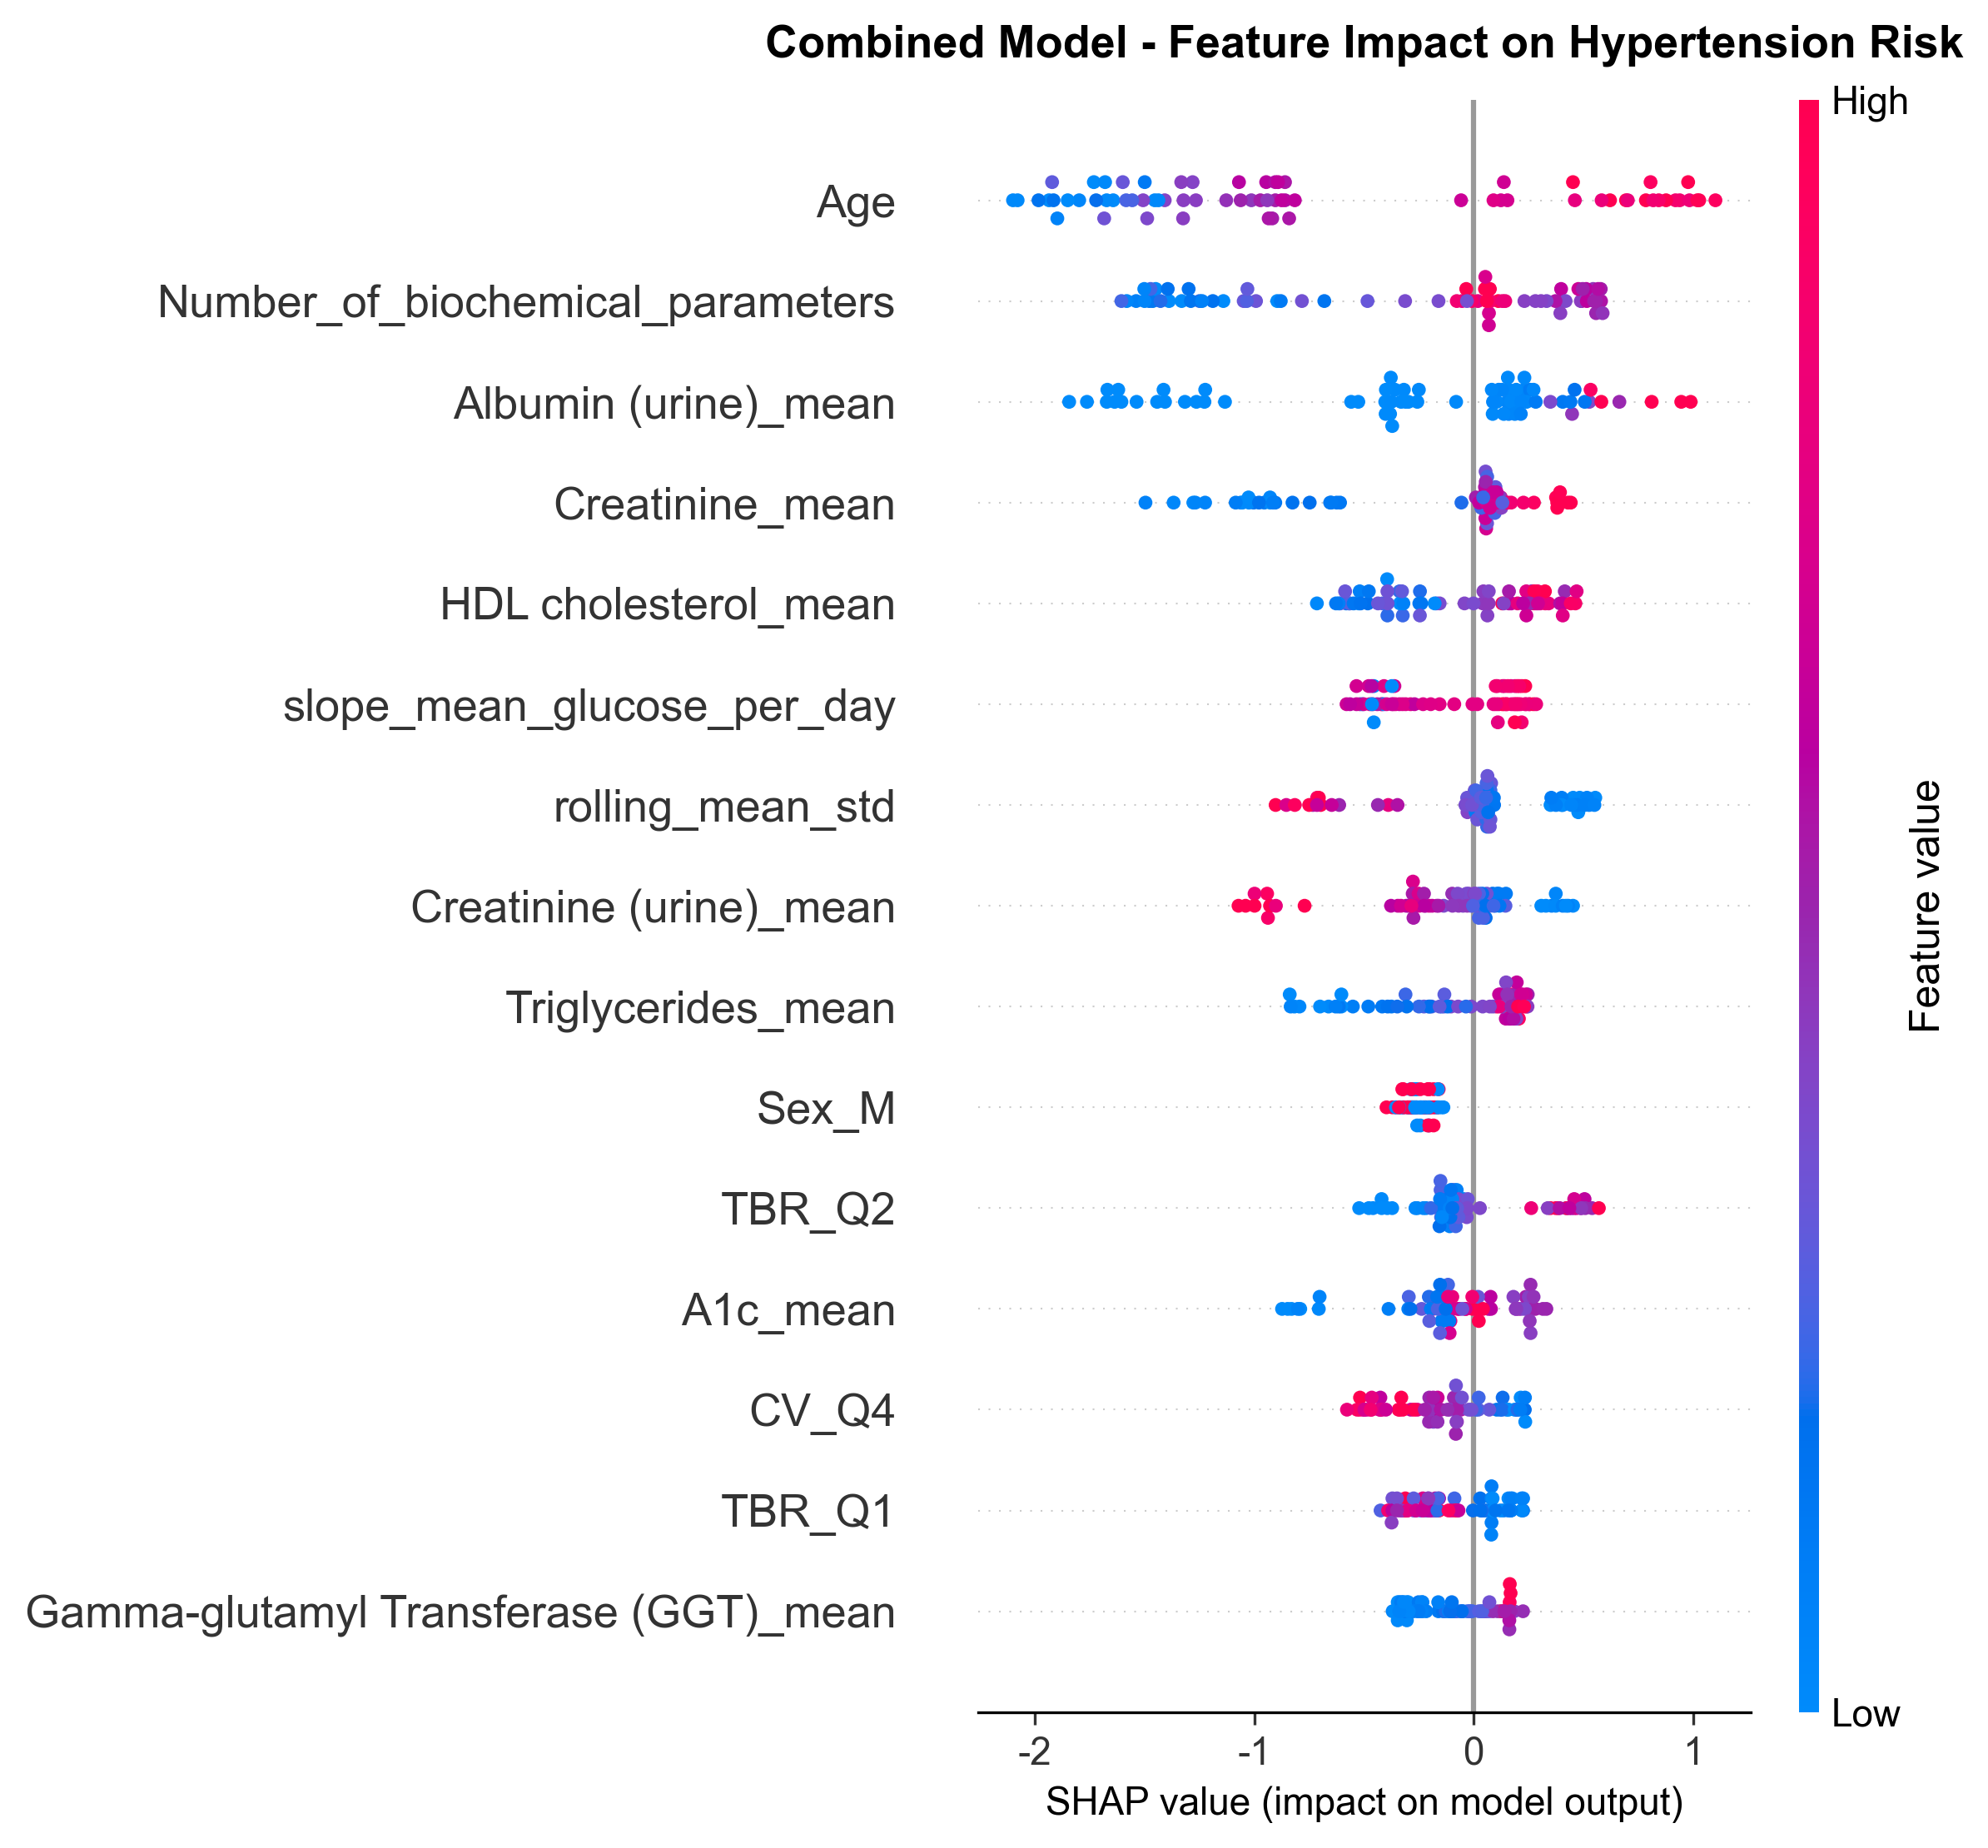


Combined model interpretability figures generated.

Top 20 Most Important Features (Combined):
                                  Feature  Mean_|SHAP|  Mean_SHAP
41                                    Age     1.141673  -0.703001
40       Number_of_biochemical_parameters     0.674579  -0.340585
43                   Albumin (urine)_mean     0.601390  -0.261011
44                        Creatinine_mean     0.412364  -0.244100
48                   HDL cholesterol_mean     0.322424  -0.068966
13             slope_mean_glucose_per_day     0.282373  -0.108882
19                       rolling_mean_std     0.277831   0.004126
45                Creatinine (urine)_mean     0.274690  -0.134309
53                     Triglycerides_mean     0.268920  -0.085925
55                                  Sex_M     0.250660  -0.250660
5                                  TBR_Q2     0.236457   0.005816
36                               A1c_mean     0.227244  -0.080062
11                                  CV_Q4     

In [15]:
def plot_shap_summary(explainer, X_test, feature_names,
                      model_name='Combined',
                      condition='Hypertension',
                      display=True):
    """
    Two separate plots:
      A) Mean |SHAP| bar plot (overall importance)
      B) Beeswarm (directionality)
    """
    print("Computing SHAP values...")
    shap_values_all = explainer.shap_values(X_test)
    
    print(f"SHAP values type: {type(shap_values_all)}")
    
    if isinstance(shap_values_all, list):
        print(f"SHAP values is a list with {len(shap_values_all)} elements")
        print("Assuming index 1 = hypertension class (positive class)")
        shap_values = shap_values_all[1]
    else:
        shap_values = shap_values_all
    
    print(f"Using SHAP values shape: {shap_values.shape}")
    
    if not isinstance(X_test, np.ndarray):
        X_test_array = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
    else:
        X_test_array = X_test
    
    plt.figure(figsize=(8, 8))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="bar",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"{model_name} Model - Feature Importance Magnitude",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("Mean |SHAP value|", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()
    
    plt.figure(figsize=(8, 10))
    shap.summary_plot(
        shap_values,
        X_test_array,
        plot_type="dot",
        max_display=15,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"{model_name} Model - Feature Impact on {condition} Risk",
              fontsize=13, fontweight="bold", pad=12)
    plt.xlabel("SHAP value (impact on model output)", fontsize=11)
    plt.tight_layout()
    if display:
        plt.show()
    else:
        plt.close()
    
    shap_importance = pd.DataFrame({
        "Feature": feature_names,
        "Mean_|SHAP|": np.abs(shap_values).mean(axis=0),
        "Mean_SHAP": shap_values.mean(axis=0)
    }).sort_values("Mean_|SHAP|", ascending=False)
    
    return shap_values, shap_importance


def run_complete_interpretability_pipeline(model, X_test, y_test,
                                           feature_names,
                                           model_name='Combined',
                                           condition='Hypertension',
                                           save_dir='figures/',
                                           display=True):
    print(f"\nRunning interpretability pipeline for {model_name} model...")
    
    explainer = shap.TreeExplainer(model)
    shap_values, shap_importance = plot_shap_summary(
        explainer,
        X_test,
        feature_names,
        model_name,
        condition,
        display=display
    )
    
    print(f"\n{model_name} model interpretability figures generated.")
    return {
        "shap_importance": shap_importance,
        "shap_values": shap_values
    }


condition = 'Hypertension'
seed = 42
results = all_results[condition][seed]

fold_idx = 0

model_with = results['with_cgm']['models'][fold_idx]
X_test_with = results['with_cgm']['X_test_scaled'][fold_idx]
feature_names_with = results['feature_names']['with_cgm']

model_without = results['without_cgm']['models'][fold_idx]
X_test_without = results['without_cgm']['X_test_scaled'][fold_idx]
feature_names_without = results['feature_names']['without_cgm']

y_test = None
for fold_data in results['with_cgm']['fold_seed_data']:
    if fold_data['fold'] == fold_idx + 1:
        y_test = fold_data['y_true']
        break

print("\n" + "="*60)
print("BIOCHEMICAL-AND-DEMOGRAPHIC MODEL (Without CGM)")
print("="*60)
shap_result_without = run_complete_interpretability_pipeline(
    model=model_without,
    X_test=X_test_without,
    y_test=y_test,
    feature_names=feature_names_without,
    model_name='Biochemical-and-Demographic',
    condition=condition,
    display=True
)

print("\nTop 20 Most Important Features (Biochemical-and-Demographic):")
print(shap_result_without["shap_importance"].head(20).to_string())

print("\n" + "="*60)
print("COMBINED MODEL (With CGM)")
print("="*60)
shap_result_with = run_complete_interpretability_pipeline(
    model=model_with,
    X_test=X_test_with,
    y_test=y_test,
    feature_names=feature_names_with,
    model_name='Combined',
    condition=condition,
    display=True
)

print("\nTop 20 Most Important Features (Combined):")
print(shap_result_with["shap_importance"].head(20).to_string())

In [16]:
CGM_GROUPS = {
    "variability": [
        "CV_Q1","CV_Q2","CV_Q3","CV_Q4",
        "CV_day","CV_night",
        "MAGE","MODD","CONGA_4"
    ],
    "time_in_range": [
        "TIR_Q1","TIR_Q2","TIR_Q3","TIR_Q4",
        "TBR_Q1","TBR_Q2","TBR_Q3","TBR_Q4",
        "TIR_day","TIR_night",
        "TBR_day","TBR_night"
    ],
    "temporal_trends": [
        "slope_TIR_per_day",
        "slope_mean_glucose_per_day",
        "rolling_mean_std",
        "rolling_cv_std",
        "slope_CV_interaction"
    ],
    "events": [
        "hypo_count","hyper_count",
        "avg_hypo_duration","avg_hyper_duration",
        "rapid_spike_count"
    ],
    "distribution": [
        "glucose_p10","glucose_p25","glucose_p50",
        "glucose_p75","glucose_p90"
    ]
}

ALL_CGM_FEATURES = sorted(
    set().union(*CGM_GROUPS.values())
)

ablation_results = {}
for group_name, group_features in CGM_GROUPS.items():
    ablation_results[group_name] = {
        'fold_level_aucs': [],
        'y_true_folds': [],
        'y_pred_folds': [],
        'seed_results': []
    }
    
    ablated_features = sorted(
        set(ALL_CGM_FEATURES) - set(group_features)
    )
    
    for seed in seeds:
        results, _, _, _ = run_cross_validation_xgboost(
            df_complete,
            target_col="Hypertension",
            cgm_subset=ablated_features,
            n_splits=10,
            random_state=seed
        )
        
        ablation_results[group_name]['seed_results'].append(results)
        
        for fold_data in results["with_cgm"]["fold_seed_data"]:
            ablation_results[group_name]['fold_level_aucs'].append(fold_data['roc_auc'])
            ablation_results[group_name]['y_true_folds'].append(fold_data['y_true'])
            ablation_results[group_name]['y_pred_folds'].append(fold_data['y_pred'])
    
    mean_auc = np.mean(ablation_results[group_name]['fold_level_aucs'])
    std_auc = np.std(ablation_results[group_name]['fold_level_aucs'], ddof=1)
    
    print(
        f"Ablate {group_name}: "
        f"{mean_auc:.3f} ± {std_auc:.3f}"
    )

Fold  1: With=0.870, Without=0.815, 
Fold  2: With=0.810, Without=0.796, 
Fold  3: With=0.956, Without=0.882, 
Fold  4: With=0.691, Without=0.767, 
Fold  5: With=0.664, Without=0.726, 
Fold  6: With=0.763, Without=0.737, 
Fold  7: With=0.786, Without=0.682, 
Fold  8: With=0.707, Without=0.659, 
Fold  9: With=0.717, Without=0.703, 
Fold 10: With=0.796, Without=0.766, 
Fold  1: With=0.892, Without=0.741, 
Fold  2: With=0.741, Without=0.749, 
Fold  3: With=0.694, Without=0.664, 
Fold  4: With=0.855, Without=0.832, 
Fold  5: With=0.588, Without=0.576, 
Fold  6: With=0.774, Without=0.707, 
Fold  7: With=0.740, Without=0.717, 
Fold  8: With=0.733, Without=0.666, 
Fold  9: With=0.908, Without=0.912, 
Fold 10: With=0.866, Without=0.952, 
Fold  1: With=0.778, Without=0.746, 
Fold  2: With=0.878, Without=0.894, 
Fold  3: With=0.756, Without=0.673, 
Fold  4: With=0.793, Without=0.763, 
Fold  5: With=0.700, Without=0.714, 
Fold  6: With=0.601, Without=0.624, 
Fold  7: With=0.876, Without=0.929, 
F

In [17]:
full_model_results = all_results['Hypertension']

full_model_fold_aucs = []
full_model_y_true = []
full_model_y_pred = []

for seed, seed_res in full_model_results.items():
    for fold_data in seed_res['with_cgm']['fold_seed_data']:
        full_model_fold_aucs.append(fold_data['roc_auc'])
        full_model_y_true.append(fold_data['y_true'])
        full_model_y_pred.append(fold_data['y_pred'])

full_model_mean = np.mean(full_model_fold_aucs)
full_model_std = np.std(full_model_fold_aucs, ddof=1)

y_true_concat_full = np.concatenate(full_model_y_true)
y_pred_concat_full = np.concatenate(full_model_y_pred)

group_display_names = {
    "variability": "Glycemic Variability",
    "time_in_range": "Time-in-Range",
    "temporal_trends": "Temporal",
    "events": "Events",
    "distribution": "Distribution"
}

table_data = []

for group_name in CGM_GROUPS.keys():
    ablated_mean = np.mean(ablation_results[group_name]['fold_level_aucs'])
    ablated_std = np.std(ablation_results[group_name]['fold_level_aucs'], ddof=1)
    delta_auc = ablated_mean - full_model_mean
    
    y_true_concat_ablated = np.concatenate(ablation_results[group_name]['y_true_folds'])
    y_pred_concat_ablated = np.concatenate(ablation_results[group_name]['y_pred_folds'])
    
    p_value = delong_roc_test_pvalue(y_true_concat_full, y_pred_concat_full, y_pred_concat_ablated)
    
    signif = '*' if p_value < 0.05 else ''
    
    row = {
        'Feature Group Removed': group_display_names[group_name],
        'Mean ROC-AUC ± SD': f"{ablated_mean:.3f} ± {ablated_std:.3f}",
        'ΔAUC vs. Full Model': f"{delta_auc:+.3f}",
        'p-value': f"{p_value:.4f}",
        'Significance': signif
    }
    
    table_data.append(row)

baseline_row = {
    'Feature Group Removed': 'Full Model (All Features)',
    'Mean ROC-AUC ± SD': f"{full_model_mean:.3f} ± {full_model_std:.3f}",
    'ΔAUC vs. Full Model': 'Baseline',
    'p-value': '—',
    'Significance': ''
}
table_data.append(baseline_row)

df_ablation = pd.DataFrame(table_data)

print("\n=== Table 4. Ablation Analysis of CGM Feature Groups ===")
print("Note: DeLong test compares each ablated model to the full model")
display(df_ablation)


=== Table 4. Ablation Analysis of CGM Feature Groups ===
Note: DeLong test compares each ablated model to the full model


Feature Group Removed Mean ROC-AUC ± SD ΔAUC vs. Full Model p-value  \
0       Glycemic Variability     0.770 ± 0.085              +0.000  0.7137   
1              Time-in-Range     0.769 ± 0.090              -0.000  0.9301   
2                   Temporal     0.753 ± 0.092              -0.017  0.0000   
3                     Events     0.766 ± 0.092              -0.004  0.3786   
4               Distribution     0.765 ± 0.092              -0.005  0.2268   
5  Full Model (All Features)     0.770 ± 0.088            Baseline       —   

  Significance  
0               
1               
2            *  
3               
4               
5

SHAP values shape: (69, 56)
Expected: (69, 56)

COUNTERFACTUAL PROXY ANALYSIS: Hypertension False Negatives

=== INPUT DIAGNOSTICS ===
X_test shape: (69, 56)
SHAP values shape: (69, 56)
Number of features: 56
y_test shape: (69,)
y_pred_proba shape: (69,)

=== FALSE NEGATIVE STATISTICS ===
Found 2 false-negative cases (threshold=0.22)
Predicted risk range in FN: [0.068, 0.104]
Mean predicted risk in FN: 0.086

=== SEX FEATURE ANALYSIS ===
Using sex feature: 'Sex_M' at index 55
Sex distribution in false negatives: {np.float64(-0.9745181037780646): np.int64(1), np.float64(1.026148201991472): np.int64(1)}

=== PATIENT SELECTION ===
Random state: 42
Using all 2 false negative cases
Selected patient indices: [13 19]

=== VERIFYING PATIENT UNIQUENESS ===
Unique patients in selection: 2/2

✓ Counterfactual analysis saved to: figures/counterfactual_analysis.png


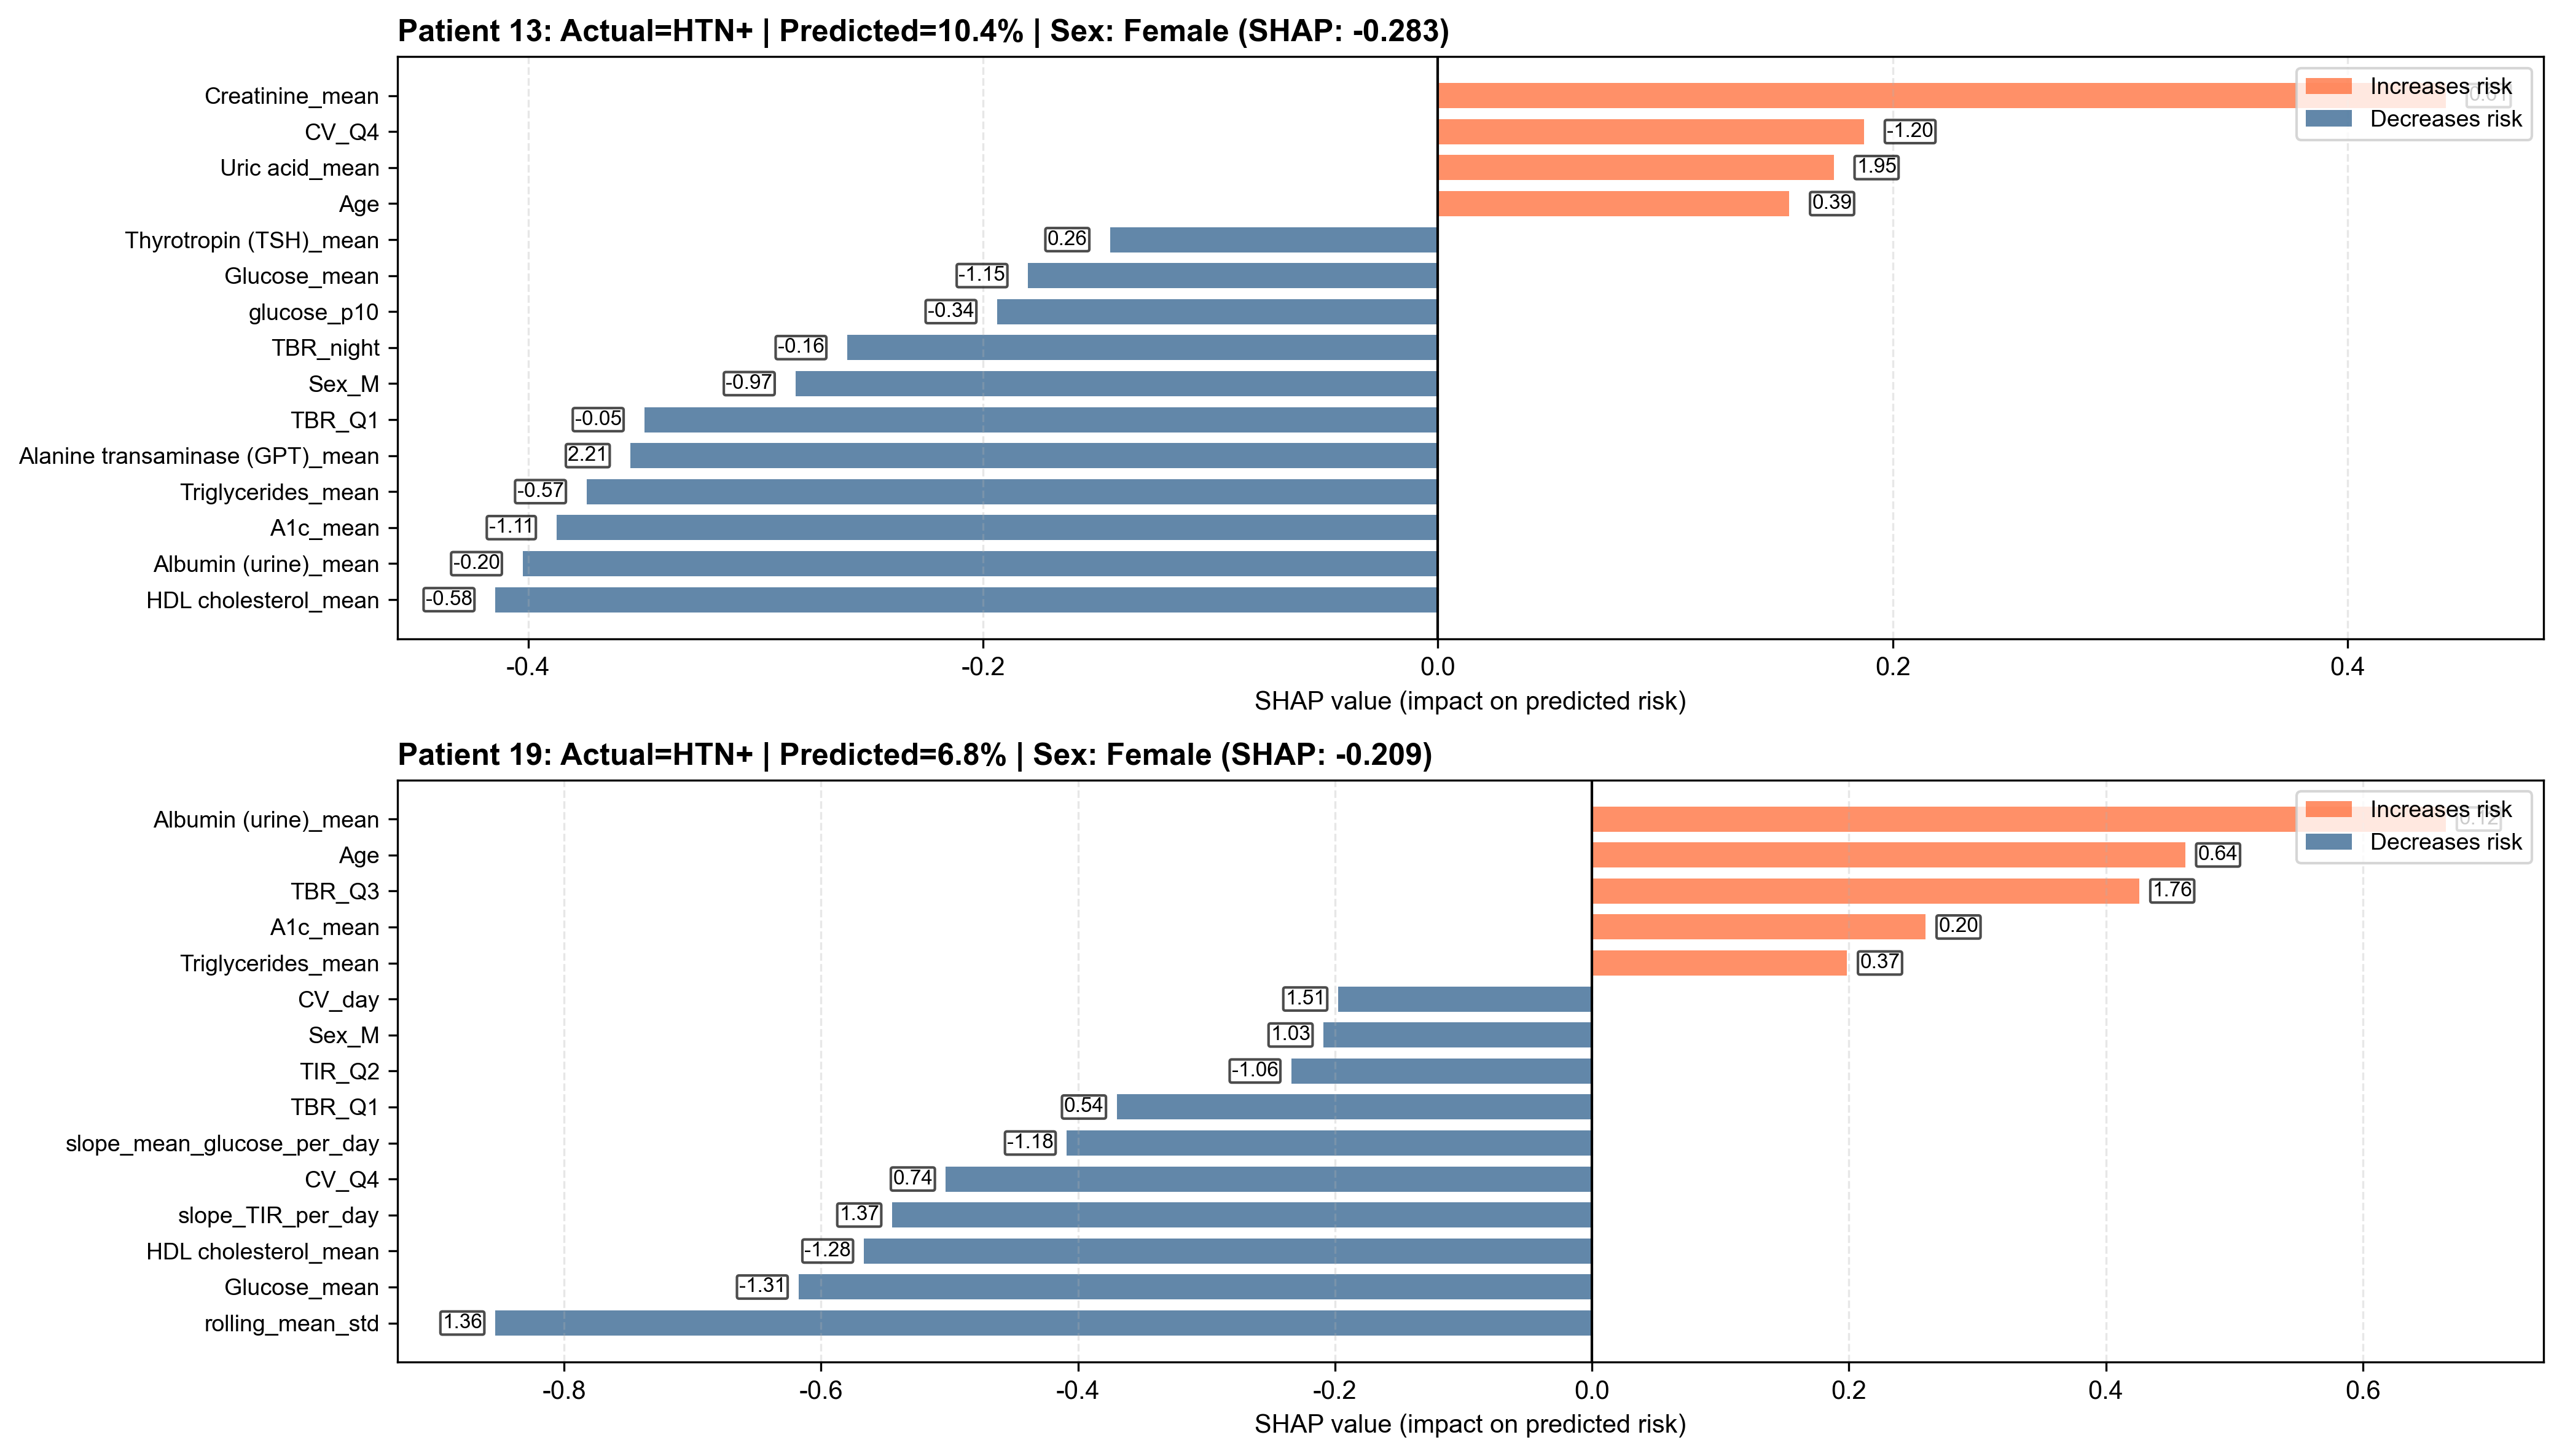


DETAILED PATIENT INSIGHTS

PATIENT 1: Index 13
• Predicted hypertension risk: 10.38%
• Actual outcome: Hypertensive (False Negative)
• Sex: Female (SHAP: -0.2825)

TOP PROTECTIVE FACTORS (reduced risk):
  • HDL cholesterol_mean: -0.58 (↓) → SHAP: -0.4145
  • Albumin (urine)_mean: -0.20 (↓) → SHAP: -0.4025
  • A1c_mean: -1.11 (↓) → SHAP: -0.3875
  • Triglycerides_mean: -0.57 (↓) → SHAP: -0.3743
  • Alanine transaminase (GPT)_mean: 2.21 (↓) → SHAP: -0.3550

TOP RISK FACTORS (increased risk):
  • Creatinine_mean: 0.61 (↓) → SHAP: 0.4432
  • CV_Q4: -1.20 (↓) → SHAP: 0.1874
  • Uric acid_mean: 1.95 (↓) → SHAP: 0.1741
  • Age: 0.39 (↓) → SHAP: 0.1545
  • glucose_p50: -0.96 (↓) → SHAP: 0.1295

COUNTERFACTUAL INSIGHT:
  If HDL cholesterol_mean were at median level, 
  predicted risk would increase by ~0.415

PATIENT 2: Index 19
• Predicted hypertension risk: 6.75%
• Actual outcome: Hypertensive (False Negative)
• Sex: Female (SHAP: -0.2090)

TOP PROTECTIVE FACTORS (reduced risk):
  • rolling_

In [27]:
def counterfactual_analysis_misclassified(
    model,
    X_test,
    y_test,
    y_pred_proba,
    shap_values,
    feature_names,
    n_examples=5,
    threshold=0.3,
    random_state=42,
    save_path='figures/counterfactual_analysis.png'
):

    print("\n" + "=" * 70)
    print("COUNTERFACTUAL PROXY ANALYSIS: Hypertension False Negatives")
    print("=" * 70 + "\n")
    
    print("=== INPUT DIAGNOSTICS ===")
    print(f"X_test shape: {X_test.shape}")
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Number of features: {len(feature_names)}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_pred_proba shape: {y_pred_proba.shape}")
    
    if len(y_pred_proba.shape) > 1:
        y_pred_proba = y_pred_proba.flatten()
        print("Flattened y_pred_proba to 1D array")

    false_negatives = (y_test == 1) & (y_pred_proba < threshold)
    fn_indices = np.where(false_negatives)[0]

    print(f"\n=== FALSE NEGATIVE STATISTICS ===")
    print(f"Found {len(fn_indices)} false-negative cases (threshold={threshold})")
    
    if len(fn_indices) == 0:
        print("No false negatives found — aborting counterfactual analysis.")
        return None, None

    print(f"Predicted risk range in FN: [{y_pred_proba[fn_indices].min():.3f}, "
          f"{y_pred_proba[fn_indices].max():.3f}]")
    print(f"Mean predicted risk in FN: {y_pred_proba[fn_indices].mean():.3f}")

    if not hasattr(X_test, "iloc"):
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
    else:
        X_test_df = X_test.copy()
        if hasattr(X_test, 'columns'):
            X_test_df.columns = feature_names

    sex_feature = None
    sex_idx = None
    for feat in feature_names:
        if feat.lower() in ['sex', 'sex_m', 'male', 'is_male'] or 'sex' in feat.lower():
            sex_feature = feat
            sex_idx = feature_names.index(feat)
            break

    if sex_feature is not None:
        print(f"\n=== SEX FEATURE ANALYSIS ===")
        print(f"Using sex feature: '{sex_feature}' at index {sex_idx}")
        
        sex_values = X_test_df.iloc[fn_indices][sex_feature].values
        unique_vals, counts = np.unique(sex_values, return_counts=True)
        sex_dist = dict(zip(unique_vals, counts))
        print(f"Sex distribution in false negatives: {sex_dist}")
        
        male_mask = sex_values == 1
        female_mask = sex_values == 0
        
        if np.any(male_mask):
            male_shap = shap_values[fn_indices][male_mask, sex_idx]
            print(f"Male (1) in FN: {male_shap.shape[0]} cases, "
                  f"Mean SHAP = {male_shap.mean():.4f}")
        
        if np.any(female_mask):
            female_shap = shap_values[fn_indices][female_mask, sex_idx]
            print(f"Female (0) in FN: {female_shap.shape[0]} cases, "
                  f"Mean SHAP = {female_shap.mean():.4f}")

    print(f"\n=== PATIENT SELECTION ===")
    print(f"Random state: {random_state}")
    np.random.seed(random_state)
    
    if len(fn_indices) <= n_examples:
        selected_fn = fn_indices
        print(f"Using all {len(fn_indices)} false negative cases")
    else:
        selected_fn = np.random.choice(fn_indices, size=n_examples, replace=False)
        selected_fn = np.sort(selected_fn)
        print(f"Randomly selected {n_examples} cases")
    
    print(f"Selected patient indices: {selected_fn}")
    
    print("\n=== VERIFYING PATIENT UNIQUENESS ===")
    patient_data = X_test_df.iloc[selected_fn]
    
    n_unique = len(patient_data.drop_duplicates())
    print(f"Unique patients in selection: {n_unique}/{len(selected_fn)}")
    
    if n_unique < len(selected_fn):
        print("WARNING: Some patients appear similar/duplicated!")
        from scipy.spatial.distance import pdist, squareform
        distances = pdist(patient_data.values, metric='euclidean')
        dist_matrix = squareform(distances)
        np.fill_diagonal(dist_matrix, np.inf)
        min_dist = dist_matrix.min()
        print(f"Minimum Euclidean distance between patients: {min_dist:.4f}")

    n_show = len(selected_fn)
    fig, axes = plt.subplots(n_show, 1, figsize=(14, 4 * n_show))
    if n_show == 1:
        axes = [axes]

    for ax, idx in zip(axes, selected_fn):
        patient_shap = shap_values[idx]
        patient_features = X_test_df.iloc[idx]

        df_patient = pd.DataFrame({
            "Feature": feature_names,
            "SHAP": patient_shap,
            "Value": patient_features.values
        })
        
        df_sorted = df_patient.copy()
        df_sorted["abs_SHAP"] = np.abs(df_sorted["SHAP"])
        df_sorted = df_sorted.sort_values("abs_SHAP", ascending=False).head(15)
        
        df_sorted = df_sorted.sort_values("SHAP", ascending=False)
        
        colors = ['#ff6b35' if s > 0 else '#2d5f8d' for s in df_sorted["SHAP"]]
        
        bars = ax.barh(
            range(len(df_sorted)),
            df_sorted["SHAP"],
            color=colors,
            alpha=0.75,
            height=0.7
        )
        
        for i, (shap_val, feat_val) in enumerate(zip(df_sorted["SHAP"], df_sorted["Value"])):
            x_pos = shap_val + (0.01 if shap_val >= 0 else -0.01)
            ha = 'left' if shap_val >= 0 else 'right'
            ax.text(x_pos, i, f"{feat_val:.2f}", 
                   va='center', ha=ha, fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.7))
        
        ax.set_yticks(range(len(df_sorted)))
        ax.set_yticklabels(df_sorted["Feature"], fontsize=9)
        ax.axvline(0, color="black", linewidth=1.0, linestyle='-')
        
        sex_info = ""
        if sex_feature is not None:
            sex_val = patient_features[sex_feature]
            sex_shap = patient_shap[sex_idx]
            sex_info = f" | Sex: {'Male' if sex_val == 1 else 'Female'} (SHAP: {sex_shap:.3f})"
        
        ax.set_title(
            f"Patient {idx}: Actual=HTN+ | Predicted={y_pred_proba[idx]:.1%}{sex_info}",
            fontsize=12,
            fontweight="bold",
            loc='left'
        )
        ax.set_xlabel("SHAP value (impact on predicted risk)", fontsize=10)
        ax.invert_yaxis()
        ax.grid(axis="x", alpha=0.3, linestyle='--')
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#ff6b35', alpha=0.75, label='Increases risk'),
            Patch(facecolor='#2d5f8d', alpha=0.75, label='Decreases risk')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\n✓ Counterfactual analysis saved to: {save_path}")
    plt.show()

    print("\n" + "=" * 70)
    print("DETAILED PATIENT INSIGHTS")
    print("=" * 70)
    
    for i, idx in enumerate(selected_fn[:min(5, len(selected_fn))], 1):
        df = pd.DataFrame({
            "Feature": feature_names,
            "SHAP": shap_values[idx],
            "Value": X_test_df.iloc[idx].values
        })
        
        print(f"\n{'='*40}")
        print(f"PATIENT {i}: Index {idx}")
        print(f"{'='*40}")
        print(f"• Predicted hypertension risk: {y_pred_proba[idx]:.2%}")
        print(f"• Actual outcome: Hypertensive (False Negative)")
        
        if sex_feature is not None:
            sex_val = X_test_df.iloc[idx][sex_feature]
            sex_shap = shap_values[idx][sex_idx]
            print(f"• Sex: {'Male' if sex_val == 1 else 'Female'} (SHAP: {sex_shap:.4f})")
        
        protective = df[df["SHAP"] < 0].copy()
        protective["abs_SHAP"] = np.abs(protective["SHAP"])
        protective = protective.sort_values("abs_SHAP", ascending=False).head(5)
        
        if len(protective) > 0:
            print(f"\nTOP PROTECTIVE FACTORS (reduced risk):")
            for _, row in protective.iterrows():
                direction = "↑" if row["Value"] > df[df["Feature"]==row["Feature"]]["Value"].median() else "↓"
                print(f"  • {row['Feature']}: {row['Value']:.2f} ({direction}) → SHAP: {row['SHAP']:.4f}")
        
        risk = df[df["SHAP"] > 0].copy()
        risk["abs_SHAP"] = np.abs(risk["SHAP"])
        risk = risk.sort_values("abs_SHAP", ascending=False).head(5)
        
        if len(risk) > 0:
            print(f"\nTOP RISK FACTORS (increased risk):")
            for _, row in risk.iterrows():
                direction = "↑" if row["Value"] > df[df["Feature"]==row["Feature"]]["Value"].median() else "↓"
                print(f"  • {row['Feature']}: {row['Value']:.2f} ({direction}) → SHAP: {row['SHAP']:.4f}")
        
        print(f"\nCOUNTERFACTUAL INSIGHT:")
        if len(protective) > 0:
            top_protective = protective.iloc[0]
            print(f"  If {top_protective['Feature']} were at median level, ")
            print(f"  predicted risk would increase by ~{abs(top_protective['SHAP']):.3f}")

    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS FOR SELECTED PATIENTS")
    print("=" * 70)
    
    selected_data = {
        "Patient_Index": selected_fn,
        "Predicted_Risk": y_pred_proba[selected_fn],
        "Mean_Protective_SHAP": [],
        "Mean_Risk_SHAP": []
    }
    
    for idx in selected_fn:
        patient_shap = shap_values[idx]
        protective_mean = patient_shap[patient_shap < 0].mean() if np.any(patient_shap < 0) else 0
        risk_mean = patient_shap[patient_shap > 0].mean() if np.any(patient_shap > 0) else 0
        selected_data["Mean_Protective_SHAP"].append(protective_mean)
        selected_data["Mean_Risk_SHAP"].append(risk_mean)
    
    summary_df = pd.DataFrame(selected_data)
    print(summary_df.to_string(index=False))
    
    print(f"\nAverage predicted risk: {summary_df['Predicted_Risk'].mean():.3f}")
    print(f"Average protective SHAP: {summary_df['Mean_Protective_SHAP'].mean():.4f}")
    print(f"Average risk SHAP: {summary_df['Mean_Risk_SHAP'].mean():.4f}")
    
    return selected_fn, summary_df


condition = 'Hypertension'
seed = 42
results = all_results[condition][seed]

fold_idx = 0

model = results['with_cgm']['models'][fold_idx]
X_test = results['with_cgm']['X_test_scaled'][fold_idx]
feature_names = results['feature_names']['with_cgm']

y_test = None
y_pred_proba = None
for fold_data in results['with_cgm']['fold_seed_data']:
    if fold_data['fold'] == fold_idx + 1:
        y_test = fold_data['y_true']
        y_pred_proba = fold_data['y_pred']
        break

explainer = shap.TreeExplainer(model)

if not isinstance(X_test, np.ndarray):
    X_test_array = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
else:
    X_test_array = X_test

shap_values_all = explainer.shap_values(X_test_array)

if isinstance(shap_values_all, list):
    print(f"Binary classification detected: {len(shap_values_all)} classes")
    shap_values_hypertension = shap_values_all[1]
else:
    shap_values_hypertension = shap_values_all

print(f"SHAP values shape: {shap_values_hypertension.shape}")
print(f"Expected: ({X_test_array.shape[0]}, {X_test_array.shape[1]})")

selected_cases, summary_df = counterfactual_analysis_misclassified(
    model=model,
    X_test=X_test_array,
    y_test=y_test,
    y_pred_proba=y_pred_proba,
    shap_values=shap_values_hypertension,
    feature_names=feature_names,
    n_examples=5,
    threshold=0.22,
    random_state=42,
    save_path='figures/counterfactual_analysis.png'
)

if selected_cases is not None:
    print(f"\nAnalyzed {len(selected_cases)} false negative patients")
    print("Summary DataFrame:")
    print(summary_df)

In [19]:
df_analysis = df_complete.copy()

if 'Age_Group' in df_analysis.columns:
    df_analysis = df_analysis.drop(columns=['Age_Group'])
if 'HbA1c_Control' in df_analysis.columns:
    df_analysis = df_analysis.drop(columns=['HbA1c_Control'])

def prepare_subgroup_data(df, subgroup_col, subgroup_value, cols_to_drop):
    """Filter and clean data for subgroup analysis"""
    df_subset = df[df[subgroup_col] == subgroup_value].copy()
    df_subset = df_subset.drop(columns=cols_to_drop, errors='ignore')
    return df_subset

subgroup_results = {
    'age': {},
    'sex': {},
    'hba1c': {}
}

# AGE SUBGROUPS

print("\n" + "="*80)
print("AGE SUBGROUP ANALYSIS")
print("="*80 + "\n")

df_age = df_complete.copy()
df_age['Age_Group'] = df_age['Age'].apply(lambda x: '<40' if x < 40 else '>=40')
print(f"Age group distribution:\n{df_age['Age_Group'].value_counts()}\n")

for age_group in ['<40', '>=40']:
    print(f"\n{'*'*60}")
    print(f"Analyzing: Age {age_group}")
    print(f"{'*'*60}")
    
    df_age_subset = prepare_subgroup_data(df_age, 'Age_Group', age_group, ['Age_Group'])
    
    n_pos = int(df_age_subset[condition].sum())
    print(f"Subset size: {len(df_age_subset)}")
    print(f"Positive cases: {n_pos}")
    
    if len(df_age_subset) < 20 or n_pos < 10:
        print(f"WARNING: Insufficient positive cases (need >=10, have {n_pos}), skipping...")
        continue
    
    subgroup_results['age'][age_group] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_age_subset,
                target_col=condition,
                n_splits=min(10, n_pos),
                random_state=seed
            )
            
            subgroup_results['age'][age_group][seed] = {
                'results': results,
                'n_samples': len(df_age_subset),
                'n_positive': n_pos
            }
            
            with_cgm_aucs = [d['roc_auc'] for d in results['with_cgm']['fold_seed_data']]
            without_cgm_aucs = [d['roc_auc'] for d in results['without_cgm']['fold_seed_data']]
            
            print(f"\nSeed {seed} - Age {age_group}:")
            print(f"  ROC-AUC With CGM:    {np.mean(with_cgm_aucs):.3f} ± {np.std(with_cgm_aucs):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(without_cgm_aucs):.3f} ± {np.std(without_cgm_aucs):.3f}")
            delta = np.mean(with_cgm_aucs) - np.mean(without_cgm_aucs)
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")

# SEX SUBGROUPS

print("\n" + "="*80)
print("SEX SUBGROUP ANALYSIS")
print("="*80 + "\n")

print(f"Sex distribution:\n{df_complete['Sex'].value_counts()}\n")

for sex in df_analysis['Sex'].unique():
    print(f"\n{'*'*60}")
    print(f"Analyzing: Sex = {sex}")
    print(f"{'*'*60}")
    
    df_sex_subset = df_analysis[df_analysis['Sex'] == sex].copy()
    
    n_pos = int(df_sex_subset[condition].sum())
    print(f"Subset size: {len(df_sex_subset)}")
    print(f"Positive cases: {n_pos}")
    
    if len(df_sex_subset) < 20 or n_pos < 5:
        print("WARNING: Insufficient samples, skipping...")
        continue
    
    subgroup_results['sex'][sex] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_sex_subset,
                target_col=condition,
                n_splits=min(10, n_pos),
                random_state=seed
            )
            
            subgroup_results['sex'][sex][seed] = {
                'results': results,
                'n_samples': len(df_sex_subset),
                'n_positive': n_pos
            }
            
            with_cgm_aucs = [d['roc_auc'] for d in results['with_cgm']['fold_seed_data']]
            without_cgm_aucs = [d['roc_auc'] for d in results['without_cgm']['fold_seed_data']]
            
            print(f"\nSeed {seed} - Sex {sex}:")
            print(f"  ROC-AUC Combined:    {np.mean(with_cgm_aucs):.3f} ± {np.std(with_cgm_aucs):.3f}")
            print(f"  ROC-AUC Biochemical: {np.mean(without_cgm_aucs):.3f} ± {np.std(without_cgm_aucs):.3f}")
            delta = np.mean(with_cgm_aucs) - np.mean(without_cgm_aucs)
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")
            
# HbA1c CONTROL SUBGROUPS

print("\n" + "="*80)
print("HbA1c CONTROL SUBGROUP ANALYSIS")
print("="*80 + "\n")

df_hba1c = df_analysis.dropna(subset=['A1c_mean']).copy()
df_hba1c['HbA1c_Control'] = df_hba1c['A1c_mean'].apply(
    lambda x: 'Good (<7.5%)' if x < 7.5 else 'Poor (>=7.5%)'
)
print(f"HbA1c control distribution:\n{df_hba1c['HbA1c_Control'].value_counts()}\n")

for hba1c_group in ['Good (<7.5%)', 'Poor (>=7.5%)']:
    print(f"\n{'*'*60}")
    print(f"Analyzing: HbA1c Control = {hba1c_group}")
    print(f"{'*'*60}")
    
    df_hba1c_subset = prepare_subgroup_data(df_hba1c, 'HbA1c_Control', hba1c_group, ['HbA1c_Control'])
    
    n_pos = int(df_hba1c_subset[condition].sum())
    print(f"Subset size: {len(df_hba1c_subset)}")
    print(f"Positive cases: {n_pos}")
    
    if len(df_hba1c_subset) < 20 or n_pos < 5:
        print("WARNING: Insufficient samples, skipping...")
        continue
    
    subgroup_results['hba1c'][hba1c_group] = {}
    
    for seed in seeds:
        try:
            results, features_with, features_without, features_only = run_cross_validation_xgboost(
                df_hba1c_subset,
                target_col=condition,
                n_splits=min(10, n_pos),
                random_state=seed
            )
            
            subgroup_results['hba1c'][hba1c_group][seed] = {
                'results': results,
                'n_samples': len(df_hba1c_subset),
                'n_positive': n_pos
            }
            
            with_cgm_aucs = [d['roc_auc'] for d in results['with_cgm']['fold_seed_data']]
            without_cgm_aucs = [d['roc_auc'] for d in results['without_cgm']['fold_seed_data']]
            
            print(f"\nSeed {seed} - HbA1c {hba1c_group}:")
            print(f"  ROC-AUC With CGM:    {np.mean(with_cgm_aucs):.3f} ± {np.std(with_cgm_aucs):.3f}")
            print(f"  ROC-AUC Without CGM: {np.mean(without_cgm_aucs):.3f} ± {np.std(without_cgm_aucs):.3f}")
            delta = np.mean(with_cgm_aucs) - np.mean(without_cgm_aucs)
            print(f"  Delta AUC (CGM benefit): {delta:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")

# SUMMARY TABLE WITH DELONG TEST

print("\n\n" + "="*100)
print("SUMMARY TABLE - SUBGROUP ANALYSIS WITH DELONG TEST")
print("="*100 + "\n")

summary_rows = []

for analysis_type in ['age', 'sex', 'hba1c']:
    for subgroup_name in subgroup_results[analysis_type].keys():
        
        all_fold_vals_with = []
        all_fold_vals_without = []
        y_true_all_folds = []
        y_pred_with_all_folds = []
        y_pred_without_all_folds = []
        
        n_samples = 0
        n_pos = 0
        
        for seed, data in subgroup_results[analysis_type][subgroup_name].items():
            results = data['results']
            n_samples = data['n_samples']
            n_pos = data['n_positive']
            
            for fold_data in results['with_cgm']['fold_seed_data']:
                all_fold_vals_with.append(fold_data['roc_auc'])
                y_pred_with_all_folds.append(fold_data['y_pred'])
                y_true_all_folds.append(fold_data['y_true'])
            
            for fold_data in results['without_cgm']['fold_seed_data']:
                all_fold_vals_without.append(fold_data['roc_auc'])
                y_pred_without_all_folds.append(fold_data['y_pred'])
        
        mean_with = np.mean(all_fold_vals_with)
        std_with = np.std(all_fold_vals_with, ddof=1)
        mean_without = np.mean(all_fold_vals_without)
        std_without = np.std(all_fold_vals_without, ddof=1)
        delta_auc = mean_with - mean_without
        
        y_true_concat = np.concatenate(y_true_all_folds)
        y_pred_with_concat = np.concatenate(y_pred_with_all_folds)
        y_pred_without_concat = np.concatenate(y_pred_without_all_folds)
        
        p_value = delong_roc_test_pvalue(y_true_concat, y_pred_with_concat, y_pred_without_concat)
        
        signif = '*' if p_value < 0.05 else ''
        
        row = {
            'Analysis': analysis_type.upper(),
            'Subgroup': subgroup_name,
            'N': n_samples,
            'N_pos': n_pos,
            'Prev_%': f"{(n_pos/n_samples*100):.1f}",
            'AUC_Combined': f"{mean_with:.3f}±{std_with:.3f}",
            'AUC_Biochem': f"{mean_without:.3f}±{std_without:.3f}",
            'Delta_AUC': f"{delta_auc:.3f}",
            'p-value': f"{p_value:.4f}",
            'Sig': signif,
            'n_folds': len(all_fold_vals_with)
        }
        summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df.drop(columns=['n_folds']).to_string(index=False))

import pickle
with open(f'subgroup_results_{condition}.pkl', 'wb') as f:
    pickle.dump(subgroup_results, f)
print(f"\n\nResults saved to: subgroup_results_{condition}.pkl")

summary_df.to_csv(f'subgroup_summary_{condition}.csv', index=False)
print(f"Summary table saved to: subgroup_summary_{condition}.csv")


AGE SUBGROUP ANALYSIS

Age group distribution:
Age_Group
>=40    372
<40     317
Name: count, dtype: int64


************************************************************
Analyzing: Age <40
************************************************************
Subset size: 317
Positive cases: 5

************************************************************
Analyzing: Age >=40
************************************************************
Subset size: 372
Positive cases: 62
Fold  1: With=0.719, Without=0.793, 
Fold  2: With=0.608, Without=0.581, 
Fold  3: With=0.661, Without=0.597, 
Fold  4: With=0.677, Without=0.731, 
Fold  5: With=0.581, Without=0.597, 
Fold  6: With=0.753, Without=0.780, 
Fold  7: With=0.737, Without=0.672, 
Fold  8: With=0.527, Without=0.817, 
Fold  9: With=0.677, Without=0.715, 
Fold 10: With=0.667, Without=0.742, 

Seed 42 - Age >=40:
  ROC-AUC With CGM:    0.661 ± 0.067
  ROC-AUC Without CGM: 0.702 ± 0.082
  Delta AUC (CGM benefit): -0.042
Fold  1: With=0.585, Without=0.737, 


DCA at 22% threshold:
  Net Benefit (Combined)              : 0.0079
  Net Benefit (Biochemical-and-Demog) : -0.0029
  Delta Net Benefit                   : +0.0107


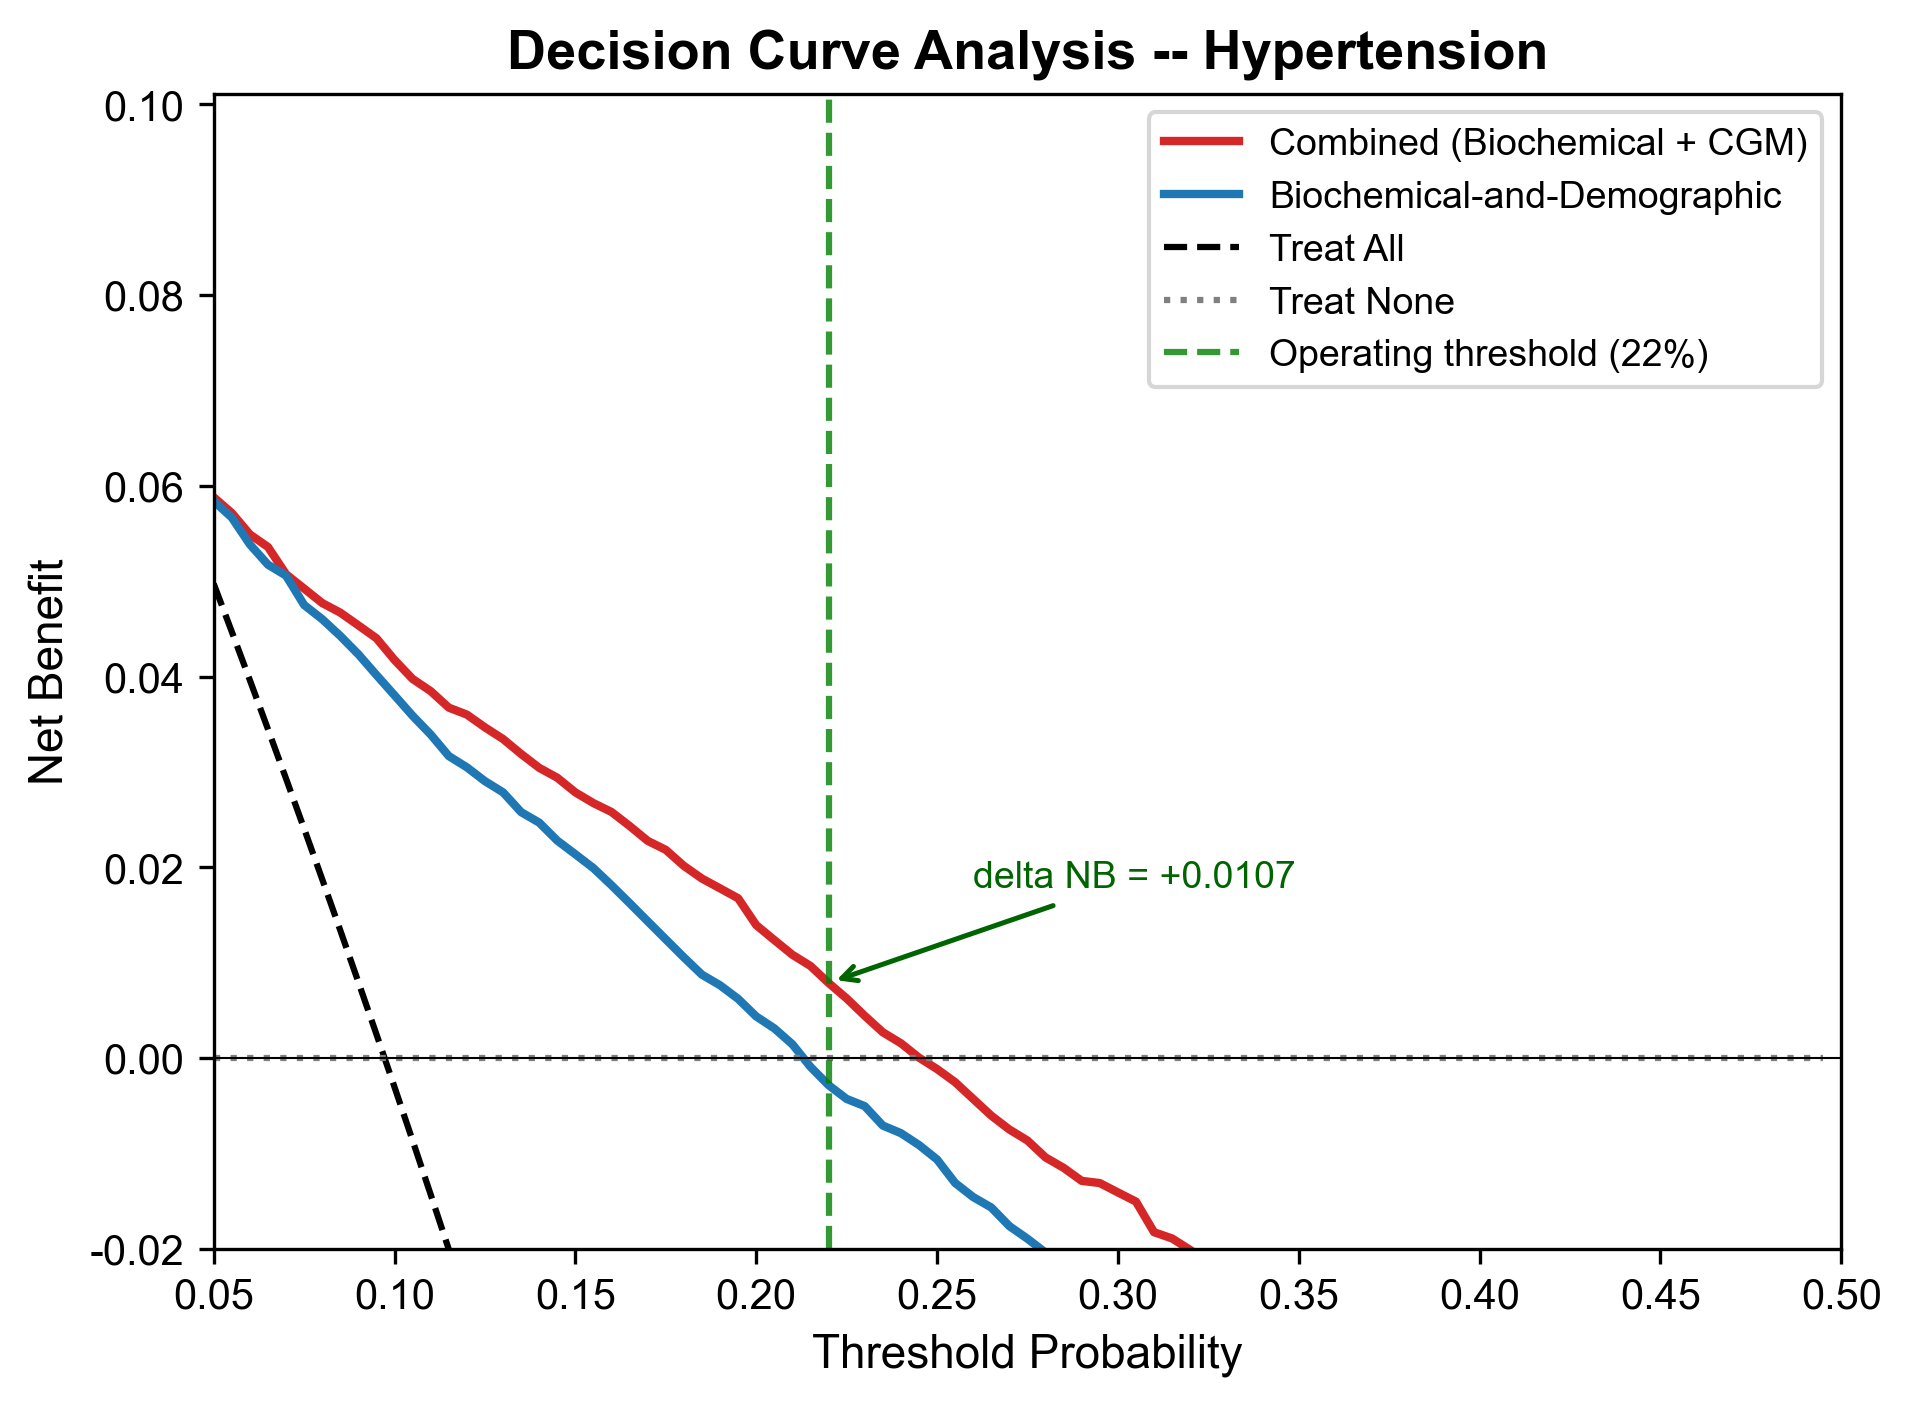

In [30]:
def pool_predictions(all_results, condition, model_key):
    y_true_all, y_pred_all = [], []
    for seed, results in all_results[condition].items():
        for fold_data in results[model_key]['fold_seed_data']:
            y_true_all.append(fold_data['y_true'])
            y_pred_all.append(fold_data['y_pred'])
    return np.concatenate(y_true_all), np.concatenate(y_pred_all)


def _net_benefit_at_threshold(y_true, y_pred, threshold):
    if threshold >= 1.0:
        return np.nan
    n = len(y_true)
    y_bin = (y_pred >= threshold).astype(int)
    tp = np.sum((y_bin == 1) & (y_true == 1))
    fp = np.sum((y_bin == 1) & (y_true == 0))
    return (tp / n) - (fp / n) * (threshold / (1.0 - threshold))


def _dca_curve(y_true, y_pred, thresholds):
    return np.array([_net_benefit_at_threshold(y_true, y_pred, t) for t in thresholds])


def run_dca(all_results, condition='Hypertension', threshold_range=(0.05, 0.50),
            decision_threshold=0.30, ax=None):
    """
    Decision Curve Analysis for with_cgm vs without_cgm.
    Net benefit computed from first principles -- no dcurves package needed.
    """
    y_true, y_pred_with    = pool_predictions(all_results, condition, 'with_cgm')
    _,      y_pred_without = pool_predictions(all_results, condition, 'without_cgm')

    prevalence = np.mean(y_true)
    thresholds = np.arange(threshold_range[0], threshold_range[1], 0.005)

    nb_with       = _dca_curve(y_true, y_pred_with,    thresholds)
    nb_without    = _dca_curve(y_true, y_pred_without, thresholds)
    nb_treat_all  = prevalence - (1 - prevalence) * (thresholds / (1.0 - thresholds))
    nb_treat_none = np.zeros_like(thresholds)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    ax.plot(thresholds, nb_with,       color='#d62728', lw=2,
            label='Combined (Biochemical + CGM)')
    ax.plot(thresholds, nb_without,    color='#1f77b4', lw=2,
            label='Biochemical-and-Demographic')
    ax.plot(thresholds, nb_treat_all,  color='black',   lw=1.5, linestyle='--',
            label='Treat All')
    ax.plot(thresholds, nb_treat_none, color='gray',    lw=1.5, linestyle=':',
            label='Treat None')
    ax.axvline(x=decision_threshold, color='green', linestyle='--', alpha=0.8,
               label=f'Operating threshold ({int(decision_threshold*100)}%)')

    nb_at_with    = _net_benefit_at_threshold(y_true, y_pred_with,    decision_threshold)
    nb_at_without = _net_benefit_at_threshold(y_true, y_pred_without, decision_threshold)
    delta_nb = nb_at_with - nb_at_without
    ax.annotate(
        f'delta NB = {delta_nb:+.4f}',
        xy=(decision_threshold, nb_at_with),
        xytext=(decision_threshold + 0.04, nb_at_with + 0.01),
        fontsize=9, color='darkgreen',
        arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.2)
    )

    ax.set_xlim(threshold_range)
    ax.set_ylim(bottom=-0.02)
    ax.set_title(f'Decision Curve Analysis -- {condition}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Threshold Probability', fontsize=11)
    ax.set_ylabel('Net Benefit', fontsize=11)
    ax.legend(fontsize=9, loc='upper right')
    ax.axhline(0, color='black', lw=0.5)

    dca_df = pd.DataFrame({
        'threshold':       thresholds,
        'nb_with_cgm':    nb_with,
        'nb_without_cgm': nb_without,
        'nb_treat_all':   nb_treat_all,
    })

    print(f"\nDCA at {int(decision_threshold*100)}% threshold:")
    print(f"  Net Benefit (Combined)              : {nb_at_with:.4f}")
    print(f"  Net Benefit (Biochemical-and-Demog) : {nb_at_without:.4f}")
    print(f"  Delta Net Benefit                   : {delta_nb:+.4f}")

    return dca_df, ax

if __name__ == '__main__':

    dca_df, _ = run_dca(all_results, condition='Hypertension', decision_threshold=0.22)

    plt.show()